In [66]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as ag
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import os
from scipy import signal
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable
import time

torch.set_printoptions(precision=6)


def readDepthMap(depthMap_filename, depthmap_training_stack, batch_size, k):
    depth_training_file = open(depthmap_filename, "rb")
    height = int.from_bytes(depth_training_file.read(4), byteorder='little')
    width = int.from_bytes(depth_training_file.read(4), byteorder='little')
    training_depthmap = np.frombuffer(depth_training_file.read(), dtype=np.float32)
    training_depthmap.shape = (width, height)
    training_depthmap = np.flip(training_depthmap,axis=0)
    depthmap_training_stack[k // batch_size][k%batch_size, :, :,:] = torch.from_numpy(np.ascontiguousarray(training_depthmap))
    #plt.imshow(training_depthmap, cmap='gray', vmin=0, vmax=1)
    depth_training_file.close()
    
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(torch.cat([init_dim * torch.arange(n_tile) + i for i in range(init_dim)])).to(device='cuda:0')
    return torch.index_select(a, dim, order_index)


In [67]:
#load the training and test datasets
  # Training dataset
depthmap_training_directory = "\\\wsl$\\Ubuntu\\home\\flora\\depth_map_generation\\depth_maps\\bear\\DepthMaps\\51x51_162"
file_ext = ".dat"
image_param = depthmap_training_directory.split(os.sep)[-1]
nb_training_images = int(image_param.split("_")[-1])
[width, height] = (image_param.split("_")[0]).split("x")
width = int(width)
height = int(height)
batch_size = 32
    # original dataset
depthmap_training_stack = [torch.zeros([batch_size, 1, height, width]) for i in range(nb_training_images//batch_size + 1 if nb_training_images%batch_size > 0 else nb_training_images//batch_size)]
k= 0
for subdirectory in os.listdir(depthmap_training_directory):
    depthmap_name = "bear-51x51-" + subdirectory + "-originalDepthMap" + file_ext
    depthmap_filename = os.path.join(depthmap_training_directory, subdirectory, depthmap_name)
    readDepthMap(depthmap_filename, depthmap_training_stack, batch_size, k)
    k = k+1
    
    # augmented dataset
depthmap_augmented_training_directory = "\\\wsl$\\Ubuntu\\home\\flora\\depth_map_generation\\depth_maps\\bear\\DepthMaps\\51x51_162_translated"
depthmap_augmented_training_stack = [torch.zeros([batch_size, 1, height, width]) for i in range(nb_training_images//batch_size + 1 if nb_training_images%batch_size > 0 else nb_training_images//batch_size)]
k = 0
for depthmap_name in os.listdir(depthmap_augmented_training_directory):
    depthmap_filename = os.path.join(depthmap_augmented_training_directory, depthmap_name)
    readDepthMap(depthmap_filename, depthmap_augmented_training_stack, batch_size, k)
    k = k+1
 
    # merged dataset
depthmap_merged_training_stack = depthmap_training_stack[:-1] + depthmap_augmented_training_stack[:-1]


  # Test dataset
depthmap_test_directory = "\\\wsl$\\Ubuntu\\home\\flora\\depth_map_generation\\depth_maps\\bear\\DepthMaps\\51x51_642"
image_param = depthmap_test_directory.split(os.sep)[-1]
nb_test_images = int(image_param.split("_")[-1])
depthmap_test_stack = [torch.zeros([batch_size, 1, height, width]) for i in range(nb_test_images//batch_size + 1 if nb_test_images%batch_size > 0 else nb_test_images//batch_size)]
k= 0
for subdirectory in os.listdir(depthmap_test_directory):
    depthmap_name = "bear-51x51-" + subdirectory + "-originalDepthMap" + file_ext
    depthmap_filename = os.path.join(depthmap_test_directory, subdirectory, depthmap_name)
    readDepthMap(depthmap_filename, depthmap_test_stack, batch_size, k)
    k = k+1

In [68]:
class SatLin(torch.autograd.Function):
  
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0, max=1)
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        grad_input[input > 1] = 0
        return grad_input
    
    
class PureLin(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return grad_output
    

class MyReLu(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

In [69]:
#Define the Convolutional Autoencoder
class MLPAutoencoder(nn.Module):
    def __init__(self):
        super(MLPAutoencoder, self).__init__()
       
        #Encoder
        self.fc1 = nn.Linear(51*51, 30)
       
        #Decoder
        self.t_fc1 = nn.Linear(30, 51*51)
        
        # create shortcuts for BReLU
        self.sl = SatLin.apply
        self.pl = PureLin.apply

    def forward(self, x, return_comp=False):
        #encoder
        # add hidden layers with relu activation function
        # and maxpooling after
        print(x.size())
        old_size = x.size()[0:]
        x = x.view(-1, self.num_flat_features(x))
        print(x.size())
        x = self.sl(self.fc1(x))
        print(x.size())
        x_comp = x  # compressed representation
        
        #decoder
        # add transpose conv layers, with relu activation function
        x = self.pl(self.t_fc1(x))
        print(x.size())
        x = x.view([int(s) for s in old_size[0:]])
        print(x.size())

        if return_comp:
            return x, x_comp
        else:
            return x
        
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
    
# instanciate the model
model = MLPAutoencoder()
print(model)
params = list(model.parameters())
print(len(params))
print(params)



MLPAutoencoder(
  (fc1): Linear(in_features=2601, out_features=30, bias=True)
  (t_fc1): Linear(in_features=30, out_features=2601, bias=True)
)
4
[Parameter containing:
tensor([[-0.008095,  0.015795,  0.000986,  ..., -0.010587, -0.007371,
         -0.014184],
        [ 0.019026,  0.017403, -0.010562,  ..., -0.000131, -0.016739,
         -0.017107],
        [-0.014823,  0.018709,  0.018895,  ..., -0.003778,  0.010057,
         -0.007259],
        ...,
        [ 0.003948, -0.010259, -0.002967,  ...,  0.008216, -0.011341,
         -0.011569],
        [-0.006392, -0.005230,  0.003169,  ...,  0.012293,  0.004408,
          0.011336],
        [ 0.011274, -0.007439,  0.015219,  ...,  0.011494,  0.009562,
          0.000261]], requires_grad=True), Parameter containing:
tensor([-0.001402,  0.013833, -0.010314,  0.005319,  0.018917, -0.000296,
        -0.006488,  0.000650,  0.012058, -0.005401, -0.004158, -0.003638,
         0.019123,  0.000566, -0.014890,  0.000620, -0.010829,  0.001105,
      

In [70]:
# change dynamic range of image
def change_grey_dynamic(batch_images, max_dynamic):
    batch_size = len(batch_images)
    height = batch_images.size()[2]
    width = batch_images.size()[3]
    max_value = torch.max(batch_images)
    min_value = torch.min(batch_images)
    #inverse the gray levels and put values between [-max_dynamic/2, max_dynamic/2]
    #dynamic_changed = torch.floor((1-(batch_images - min_value)/(max_value - min_value))*max_dynamic) - (max_dynamic+1)//2
    dynamic_changed = (1-batch_images)*max_dynamic #- (max_dynamic+1)//2
    #dynamic_changed[(dynamic_changed == - (max_dynamic+1)//2).nonzero()] = 0;
    return dynamic_changed

#Loss function  -- old 
def loss_function(batch_images, outputs, batch_size, height, width):
    y_true = change_dynamic(batch_images, batch_size, height, width)
    y_pred = change_dynamic(outputs, batch_size, height, width) 
    loss = 0
    for k in range(batch_size):
        cor = F.conv2d(y_true[k, :,:,:].view(1, 1, height, width), y_pred[k, :,:,:].view(1, 1, height, width), stride = [1, 1], padding = [height//2, width//2])
        max_corr = torch.max(cor)
        max_lag = np.unravel_index((torch.argmax(cor, axis=None)).cpu(), torch.squeeze(cor).shape)
        #print("k : ", k)
        true_ind = [max(max_lag[0] - height//2, 0), min(max_lag[0] + height//2 +1, height), max(max_lag[1] - width//2, 0), min(max_lag[1] + width//2 +1, width)]
        pred_ind = [max(height//2 - max_lag[0], 0), min(height, height//2 + height - max_lag[0]), max(width//2 - max_lag[1], 0), min(width, width//2 + width - max_lag[1])]
        #print(y_true[k, 0, true_ind[0]:true_ind[1], true_ind[2]:true_ind[3]].size()), print(y_pred[k, 0, pred_ind[0]:pred_ind[1], pred_ind[2]:pred_ind[3]].size())
        mse = torch.sum((y_true[k, 0, true_ind[0]:true_ind[1], true_ind[2]:true_ind[3]] -  y_pred[k, 0, pred_ind[0]:pred_ind[1], pred_ind[2]:pred_ind[3]])**2)
        loss += mse/((255**2)*height*width)
    return loss
# ______________________________________________________________


#Loss function
def mse_function(batch_images, outputs):
    mse = torch.sum((batch_images - outputs)**2)/np.prod(batch_images.size())
    return mse

def image_corr(batch_images, outputs):
    batch_size = len(batch_images)
    #print(batch_size)
    height = batch_images.size()[2]
    width = batch_images.size()[3]
    lags_mat = np.zeros((batch_size,2))
    maxCorr = np.zeros((1, batch_size))
    for k in range(batch_size):
        #cor = F.conv2d(batch_images[k, :,:,:].view(1, 1, height, width), torch.flip(torch.unsqueeze(outputs[k, :,:,:], 0), [2 , 3]), stride = [1, 1], padding = [height//2, width//2])
        cor = F.conv2d(batch_images[k, :,:,:].view(1, 1, height, width), torch.unsqueeze(outputs[k, :,:,:], 0), stride = [1, 1], padding = [height//2, width//2])
        max_corr = torch.max(cor)
        maxCorr[0, k] = max_corr
        max_lag = np.unravel_index((torch.argmax(torch.squeeze(cor), axis=None)).cpu(), torch.squeeze(cor).shape)
        #print(max_lag)
        lag_i = torch.argmax(torch.max(torch.squeeze(cor), 1)[0])
        #print("line : ")
        #print(lag_i)
        lag_j = (torch.argmax(torch.squeeze(cor), axis=1))[lag_i]
        #print("col : " )
        #print(lag_j)
        lags_mat[k, :] = max_lag
        #if max_lag[0] != 25 | max_lag[1] != 25 :
            #print(max_lag)
            #print(lag_i, lag_j)
            
        #print(max_lag)
    return lags_mat, maxCorr

        
def mse_corr(batch_images, outputs):
    height = batch_images.size()[2]
    width = batch_images.size()[3]
    batch_images_new_dyn = change_grey_dynamic(batch_images, 255)
    outputs_new_dyn = change_grey_dynamic(outputs, 255)
    lags_mat, maxCorr = image_corr(batch_images_new_dyn, outputs_new_dyn)
    lags_mat = lags_mat.astype(int)
    tot_squared_sum = 0;
    for k in range(batch_size):
        batch_images_corr_i = [max(0, lags_mat[k, 0]- height//2), min(height, height//2 + lags_mat[k, 0] +1)]
        batch_images_corr_j = [max(0, lags_mat[k, 1]- width//2), min(width, width//2 + lags_mat[k, 1] +1)]
        outputs_corr_i = [max(0, height//2 -lags_mat[k, 0]), min(height, height + height//2-lags_mat[k, 0])]
        outputs_corr_j = [max(0, width//2 -lags_mat[k, 1]), min(width, width + width//2-lags_mat[k, 1])]
        #print("portion of input : " , batch_images_corr_i, " , ", batch_images_corr_j)
        #print("portion of output : ", outputs_corr_i, " , ", outputs_corr_j)
        squared_sum_over_px_corr = torch.sum((batch_images[k, :, batch_images_corr_i[0]:batch_images_corr_i[1], batch_images_corr_j[0]:batch_images_corr_j[1]] - outputs[k, :, outputs_corr_i[0]:outputs_corr_i[1], outputs_corr_j[0]:outputs_corr_j[1]])**2)
        tot_squared_sum += squared_sum_over_px_corr 
    return tot_squared_sum/np.prod(batch_images.size())


def weights_reg(model):
    params = list(model.parameters())
    loss = 0.0
    for parameter in params:
        loss = loss + torch.sum(parameter**2)
    return loss/2

def sparsity_reg(x_comp, desired_activation):
    dim_bottleneck = np.prod(x_comp.size())//len(x_comp)
    features = torch.reshape(x_comp, [len(x_comp), dim_bottleneck])
    features_clone =  features.clone()
    features_clone[features!=0] = 1
    mean_activations = torch.sum(features_clone, dim=0)/len(x_comp)
    loss = torch.sum(desired_activation*torch.log(desired_activation/mean_activations) + (1- desired_activation)*torch.log((1-desired_activation)/(1-mean_activations)))
    print("loss sparsity : ", loss)
    return loss

def total_loss(x, model, x_comp, x_rec, desired_activation, gamma, beta):
    mse_loss = mse_function(x, x_rec)
    weights_reg_loss = weights_reg(model)
    sparsity_reg_loss = sparsity_reg(x_comp, desired_activation)
    return mse_loss  + gamma*weights_reg_loss + beta*sparsity_reg_loss
    

def getMostSimilarBottleneckVector(query_vectors, database_vectors, metric_type):
    if metric_type == "L2":
        #print(database_vectors.repeat([len(query_vectors)] + [1 for x in database_vectors.shape[1:]]).size())
        #print(((database_vectors.repeat([len(query_vectors)] + [1 for x in database_vectors.shape[1:]]) - tile(query_vectors, 0, len(database_vectors)))**2).size())
        #print(((database_vectors.repeat([len(query_vectors)] + [1 for x in database_vectors.shape[1:]]) - tile(query_vectors, 0, len(database_vectors)))**2).view((len(database_vectors)*len(query_vectors), -1)).size())
        res = torch.sqrt(torch.sum(((database_vectors.repeat([len(query_vectors)] + [1 for x in database_vectors.shape[1:]]) - tile(query_vectors, 0, len(database_vectors)))**2).view((len(database_vectors)*len(query_vectors), -1)), 1))
        #print(res.size())
        #print(torch.argmin(res.view((len(query_vectors),len(database_vectors))), axis = 1).size())
        return torch.argmin(res.view((len(query_vectors),len(database_vectors))), axis = 1)

    else:
        print("error, this metric doesn't exists or is not implemented yet")
        return -1
    
def getMostSimilarDepthMap(depthMaps_query, depthMaps_ref, metric_type):
    nb_query = len(depthMaps_query)
    nb_ref = len(depthMaps_ref)
    height = depthMaps_query.size()[2]
    width = depthMaps_query.size()[3]
    depthMaps_query_stacked = tile(depthMaps_query, 0, nb_ref)
    depthMaps_ref_stacked = depthMaps_ref.repeat([nb_query] + [1 for x in depthMaps_ref.shape[1:]])
    if metric_type== "L2":
        s = torch.sqrt(torch.sum(torch.squeeze((depthMaps_query_stacked - depthMaps_ref_stacked)**2), (2, 1)))
        s = s.view(nb_query, nb_ref)
        most_sim_ind = torch.argmin(s, dim=1)
        #print(most_sim_ind)
        return depthMaps_ref[most_sim_ind, :, :, :]
    else : 
        if metric_type== "corr":
            depthMaps_query_stacked_new_dyn = change_grey_dynamic(depthMaps_query_stacked, 255)
            depthMaps_ref_stacked_new_dyn = change_grey_dynamic(depthMaps_ref_stacked, 255)
            lags_mat, maxCorr = image_corr(depthMaps_ref_stacked_new_dyn, depthMaps_query_stacked_new_dyn)
            lags_mat = lags_mat.astype(int)
            maxCorr = maxCorr.reshape((nb_query, nb_ref))
            #print(maxCorr)
            corr_ind = np.argmax(maxCorr, axis=1)
            #print(corr_ind)
            #print(np.size(maxCorr, 1))
            #return depthMaps_ref[corr_ind, :, :, :]
        
            # corr indices
            s = torch.zeros(nb_ref*nb_query, 1)
            for k in range(nb_ref*nb_query):
                depthMaps_ref_i = [max(0, lags_mat[k, 0]- height//2), min(height, height//2 + lags_mat[k, 0] +1)]
                depthMaps_ref_j = [max(0, lags_mat[k, 1]- width//2), min(width, width//2 + lags_mat[k, 1] +1)]
                depthMaps_query_i = [max(0, height//2 -lags_mat[k, 0]), min(height, height + height//2-lags_mat[k, 0])]
                depthMaps_query_j = [max(0, width//2 -lags_mat[k, 1]), min(width, width + width//2-lags_mat[k, 1])]
                s[k, 0] = torch.sqrt(torch.sum(torch.squeeze((depthMaps_query_stacked[k,:,depthMaps_query_i[0]:depthMaps_query_i[1],depthMaps_query_j[0]:depthMaps_query_j[1]] - depthMaps_ref_stacked[k,:,depthMaps_ref_i[0]:depthMaps_ref_i[1], depthMaps_ref_j[0]:depthMaps_ref_j[1]])**2)))
            s = s.view(nb_query, nb_ref)
            #print(s)
            #print(s[0, 156])
            #print(s[0, torch.argmin(s, dim=1)])
            most_sim_ind = torch.argmin(s, dim=1)
            #print(most_sim_ind)
            return depthMaps_ref[most_sim_ind, :, :, :]
        else:
            return -1
    

#criterion = nn.BCELoss()
#criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [71]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device) # transfert du model au gpu

cuda:0


MLPAutoencoder(
  (fc1): Linear(in_features=2601, out_features=30, bias=True)
  (t_fc1): Linear(in_features=30, out_features=2601, bias=True)
)

nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 6.415892e-04,  7.371513e-04,  6.779149e-04,  ...,
          6.316214e-04,  6.444879e-04,  6.172339e-04],
        [ 7.610358e-05,  6.961025e-05, -4.224807e-05,  ...,
         -5.230233e-07, -6.695498e-05, -6.842627e-05],
        [-5.929366e-05,  7.483786e-05,  7.558013e-05,  ...,
         -1.511370e-05,  4.022666e-05, -2.903679e-05],
        ...,
        [ 6.532907e-03,  6.476081e-03,  6.505250e-03,  ...,
          6.549981e-03,  6.471752e-03,  6.470842e-03],
        [-2.556796e-05, -2.092163e-05,  1.267401e-05,  ...,
          4.917094e-05,  1.763188e-05,  4.534415e-05],
        [ 4.176830e-03,  4.101977e-03,  4.192609e-03,  ...,
          4.177709e-03,  4.169981e-03,  4.132777e-03]], device='cuda:0')
traini

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.148095e-03,  1.243654e-03,  1.184419e-03,  ...,
          1.138128e-03,  1.150994e-03,  1.123741e-03],
        [ 7.610083e-05,  6.960777e-05, -4.224656e-05,  ...,
         -5.230045e-07, -6.695257e-05, -6.842379e-05],
        [-5.929151e-05,  7.483517e-05,  7.557738e-05,  ...,
         -1.511316e-05,  4.022522e-05, -2.903575e-05],
        ...,
        [ 5.545157e-03,  5.488332e-03,  5.517500e-03,  ...,
          5.562230e-03,  5.484004e-03,  5.483093e-03],
        [-2.556704e-05, -2.092087e-05,  1.267356e-05,  ...,
          4.916916e-05,  1.763124e-05,  4.534251e-05],
        [ 2.896366e-03,  2.821516e-03,  2.912145e-03,  ...,
          2.897245e-03,  2.889517e-03,  2.852314e-03]], device='cuda:0')
Epoch: 1 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch

          1.311027e-03,  1.303300e-03,  1.266098e-03]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 9.637362e-04,  1.059291e-03,  1.000059e-03,  ...,
          9.537691e-04,  9.666345e-04,  9.393826e-04],
        [ 7.609778e-05,  6.960501e-05, -4.224488e-05,  ...,
         -5.229835e-07, -6.694988e-05, -6.842103e-05],
        [-5.928913e-05,  7.483220e-05,  7.557432e-05,  ...,
         -1.511255e-05,  4.022362e-05, -2.903459e-05],
        ...,
        [ 4.055633e-03,  3.998811e-03,  4.027978e-03,  ...,
          4.072705e-03,  3.994482e-03,  3.993572e-03],
        [-2.556602e-05, -2.092003e-05,  1.267306e-05,  ...,
          4.916719e-05,  1.763054e-05,  4.534069e-05],
        [ 2.330641e-03,  2.255794e-03,  2.346419e-03,  ...,
          2.331520e-03,  2.323793e-03,  2.28659

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.949310e-04,  9.904824e-04,  9.312526e-04,  ...,
          8.849643e-04,  8.978293e-04,  8.705784e-04],
        [ 7.609503e-05,  6.960253e-05, -4.224337e-05,  ...,
         -5.229647e-07, -6.694747e-05, -6.841855e-05],
        [-5.928698e-05,  7.482951e-05,  7.557158e-05,  ...,
         -1.511201e-05,  4.022218e-05, -2.903355e-05],
        ...,
        [ 3.063518e-03,  3.006698e-03,  3.035864e-03,  ...,
          3.080589e-03,  3.002369e-03,  3.001459e-03],
        [-2.556510e-05, -2.091928e-05,  1.267260e-05,  ...,
          4.916541e-05,  1.762990e-05,  4.533904e-05],
        [ 5.723641e-04,  4.975195e-04,  5.881416e-04,  ...,
          5.732428e-04,  5.655157e-04,  5.283154e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[ 7.055591e-04,  8.011067e-04,  7.418792e-04,  ...,
          6.955928e-04,  7.084573e-04,  6.812075e-04],
        [ 7.609197e-05,  6.959977e-05, -4.224170e-05,  ...,
         -5.229437e-07, -6.694479e-05, -6.841579e-05],
        [-5.928460e-05,  7.482654e-05,  7.556853e-05,  ...,
         -1.511140e-05,  4.022058e-05, -2.903240e-05],
        ...,
        [ 1.946622e-03,  1.889804e-03,  1.918968e-03,  ...,
          1.963693e-03,  1.885475e-03,  1.884565e-03],
        [-2.556407e-05, -2.091844e-05,  1.267210e-05,  ...,
          4.916343e-05,  1.762919e-05,  4.533722e-05],
        [ 2.879931e-04,  2.131515e-04,  3.037699e-04,  ...,
          2.888718e-04,  2.811450e-04,  2.439462e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 7.732722e-04,  8

training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.372079e-04,  6.327513e-04,  5.735264e-04,  ...,
          5.272420e-04,  5.401059e-04,  5.128573e-04],
        [ 7.608861e-05,  6.959674e-05, -4.223985e-05,  ...,
         -5.229206e-07, -6.694184e-05, -6.841276e-05],
        [-5.928198e-05,  7.482326e-05,  7.556516e-05,  ...,
         -1.511074e-05,  4.021881e-05, -2.903113e-05],
        ...,
        [ 1.320652e-03,  1.263837e-03,  1.293000e-03,  ...,
          1.337723e-03,  1.259509e-03,  1.258599e-03],
        [-2.556295e-05, -2.091752e-05,  1.267155e-05,  ...,
          4.916126e-05,  1.762841e-05,  4.533521e-05],
        [ 1.329197e-03,  1.254358e-03,  1.344973e-03,  ...,
          1.330075e-03,  1.322349e-03,  1.285152e-03]], device='cuda:0')
Epoch: 5 	Training Loss: inf
nb batch: 10
nb ba

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.109332e-04,  6.064727e-04,  5.472502e-04,  ...,
          5.009677e-04,  5.138310e-04,  4.865835e-04],
        [ 7.608555e-05,  6.959398e-05, -4.223817e-05,  ...,
         -5.228997e-07, -6.693916e-05, -6.841000e-05],
        [-5.927960e-05,  7.482027e-05,  7.556211e-05,  ...,
         -1.511013e-05,  4.021721e-05, -2.902997e-05],
        ...,
        [ 9.757846e-04,  9.189717e-04,  9.481338e-04,  ...,
          9.928542e-04,  9.146436e-04,  9.137335e-04],
        [-2.556192e-05, -2.091668e-05,  1.267104e-05,  ...,
          4.915929e-05,  1.762771e-05,  4.533339e-05],
        [ 1.209070e-03,  1.134235e-03,  1.224846e-03,  ...,
          1.209949e-03,  1.202223e-03,  1.165027e-03]], device='cuda:0')
Epoch: 6 	Training Loss: inf
nb batch: 10
nb batch minus last one

conv1.weights grad:  tensor([[ 6.067972e-04,  7.023332e-04,  6.431129e-04,  ...,
          5.968320e-04,  6.096950e-04,  5.824484e-04],
        [ 7.608280e-05,  6.959150e-05, -4.223666e-05,  ...,
         -5.228808e-07, -6.693674e-05, -6.840752e-05],
        [-5.927745e-05,  7.481760e-05,  7.555936e-05,  ...,
         -1.510959e-05,  4.021577e-05, -2.902894e-05],
        ...,
        [ 7.798249e-04,  7.230140e-04,  7.521751e-04,  ...,
          7.968940e-04,  7.186860e-04,  7.177760e-04],
        [-2.556100e-05, -2.091593e-05,  1.267059e-05,  ...,
          4.915751e-05,  1.762707e-05,  4.533174e-05],
        [ 8.640579e-05,  1.157315e-05,  1.021807e-04,  ...,
          8.728437e-05,  7.955852e-05,  4.236417e-05]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.007029e-04,  3

conv1.weights grad:  tensor([[ 6.160425e-04,  7.115747e-04,  6.523568e-04,  ...,
          6.060778e-04,  6.189402e-04,  5.916947e-04],
        [ 7.607976e-05,  6.958874e-05, -4.223499e-05,  ...,
         -5.228599e-07, -6.693406e-05, -6.840477e-05],
        [-5.927506e-05,  7.481461e-05,  7.555630e-05,  ...,
         -1.510898e-05,  4.021417e-05, -2.902778e-05],
        ...,
        [ 5.743292e-04,  5.175206e-04,  5.466805e-04,  ...,
          5.913976e-04,  5.131928e-04,  5.122828e-04],
        [-2.555997e-05, -2.091509e-05,  1.267009e-05,  ...,
          4.915554e-05,  1.762636e-05,  4.532991e-05],
        [ 1.301496e-04,  5.531995e-05,  1.459239e-04,  ...,
          1.310281e-04,  1.233026e-04,  8.610974e-05]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.131782e-04,  4

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.976668e-04,  3.931949e-04,  3.339796e-04,  ...,
          2.877026e-04,  3.005644e-04,  2.733202e-04],
        [ 7.607639e-05,  6.958572e-05, -4.223315e-05,  ...,
         -5.228368e-07, -6.693111e-05, -6.840174e-05],
        [-5.927244e-05,  7.481134e-05,  7.555295e-05,  ...,
         -1.510832e-05,  4.021241e-05, -2.902651e-05],
        ...,
        [ 4.967056e-04,  4.398995e-04,  4.690582e-04,  ...,
          5.137733e-04,  4.355719e-04,  4.346620e-04],
        [-2.555885e-05, -2.091417e-05,  1.266954e-05,  ...,
          4.915336e-05,  1.762558e-05,  4.532791e-05],
        [ 6.672668e-04,  5.924405e-04,  6.830405e-04,  ...,
          6.681454e-04,  6.604202e-04,  6.232290e-04]], device='cuda:0')
Epoch: 9 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch

conv1.weights grad:  tensor([[ 5.754025e-04,  6.709271e-04,  6.117139e-04,  ...,
          5.654386e-04,  5.782999e-04,  5.510566e-04],
        [ 7.607364e-05,  6.958324e-05, -4.223164e-05,  ...,
         -5.228180e-07, -6.692870e-05, -6.839925e-05],
        [-5.927030e-05,  7.480865e-05,  7.555020e-05,  ...,
         -1.510777e-05,  4.021097e-05, -2.902547e-05],
        ...,
        [ 4.218188e-04,  3.650147e-04,  3.941723e-04,  ...,
          4.388858e-04,  3.606872e-04,  3.597773e-04],
        [-2.555793e-05, -2.091341e-05,  1.266908e-05,  ...,
          4.915159e-05,  1.762495e-05,  4.532627e-05],
        [-8.858118e-06, -8.368176e-05,  6.914917e-06,  ...,
         -7.979648e-06, -1.570454e-05, -5.289444e-05]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.424362e-04,  4

conv1.weights grad:  tensor([[ 5.657047e-04,  6.612255e-04,  6.020147e-04,  ...,
          5.557411e-04,  5.686020e-04,  5.413598e-04],
        [ 7.607059e-05,  6.958048e-05, -4.222996e-05,  ...,
         -5.227970e-07, -6.692601e-05, -6.839650e-05],
        [-5.926791e-05,  7.480567e-05,  7.554714e-05,  ...,
         -1.510717e-05,  4.020936e-05, -2.902432e-05],
        ...,
        [ 2.802919e-04,  2.234901e-04,  2.526465e-04,  ...,
          2.973582e-04,  2.191628e-04,  2.182529e-04],
        [-2.555690e-05, -2.091257e-05,  1.266858e-05,  ...,
          4.914961e-05,  1.762424e-05,  4.532444e-05],
        [-4.728033e-05, -1.221010e-04, -3.150792e-05,  ...,
         -4.640190e-05, -5.412647e-05, -9.131488e-05]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.668112e-04,  3

conv1.weights grad:  tensor([[ 6.267395e-04,  7.222565e-04,  6.630480e-04,  ...,
          6.167763e-04,  6.296367e-04,  6.023956e-04],
        [ 7.606753e-05,  6.957772e-05, -4.222828e-05,  ...,
         -5.227761e-07, -6.692333e-05, -6.839374e-05],
        [-5.926553e-05,  7.480269e-05,  7.554409e-05,  ...,
         -1.510656e-05,  4.020776e-05, -2.902316e-05],
        ...,
        [ 2.587088e-04,  2.019092e-04,  2.310645e-04,  ...,
          2.757744e-04,  1.975821e-04,  1.966723e-04],
        [-2.555588e-05, -2.091174e-05,  1.266808e-05,  ...,
          4.914764e-05,  1.762353e-05,  4.532261e-05],
        [ 4.795455e-05, -2.686311e-05,  6.372632e-05,  ...,
          4.883295e-05,  4.110868e-05,  3.921751e-06]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.095273e-04,  3

conv1.weights grad:  tensor([[ 3.052248e-04,  4.007384e-04,  3.415320e-04,  ...,
          2.952621e-04,  3.081220e-04,  2.808818e-04],
        [ 7.606478e-05,  6.957524e-05, -4.222677e-05,  ...,
         -5.227572e-07, -6.692092e-05, -6.839126e-05],
        [-5.926338e-05,  7.480001e-05,  7.554133e-05,  ...,
         -1.510602e-05,  4.020632e-05, -2.902212e-05],
        ...,
        [ 6.540120e-04,  5.972144e-04,  6.263687e-04,  ...,
          6.710770e-04,  5.928875e-04,  5.919777e-04],
        [-2.555495e-05, -2.091098e-05,  1.266763e-05,  ...,
          4.914586e-05,  1.762289e-05,  4.532097e-05],
        [ 1.619804e-04,  8.716538e-05,  1.777516e-04,  ...,
          1.628587e-04,  1.551347e-04,  1.179491e-04]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 6.315836e-04,  7

conv1.weights grad:  tensor([[ 2.969706e-04,  3.924803e-04,  3.332763e-04,  ...,
          2.870082e-04,  2.998676e-04,  2.726285e-04],
        [ 7.606173e-05,  6.957248e-05, -4.222510e-05,  ...,
         -5.227362e-07, -6.691823e-05, -6.838850e-05],
        [-5.926100e-05,  7.479703e-05,  7.553828e-05,  ...,
         -1.510541e-05,  4.020472e-05, -2.902097e-05],
        ...,
        [ 5.233976e-04,  4.666024e-04,  4.957555e-04,  ...,
          5.404620e-04,  4.622756e-04,  4.613658e-04],
        [-2.555393e-05, -2.091014e-05,  1.266712e-05,  ...,
          4.914389e-05,  1.762219e-05,  4.531915e-05],
        [ 1.443207e-04,  6.950877e-05,  1.600913e-04,  ...,
          1.451991e-04,  1.374754e-04,  1.002913e-04]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 7.333824e-04,  8

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.068531e-04,  3.023591e-04,  2.431574e-04,  ...,
          1.968912e-04,  2.097500e-04,  1.825120e-04],
        [ 7.605868e-05,  6.956972e-05, -4.222342e-05,  ...,
         -5.227153e-07, -6.691556e-05, -6.838574e-05],
        [-5.925861e-05,  7.479405e-05,  7.553522e-05,  ...,
         -1.510481e-05,  4.020311e-05, -2.901981e-05],
        ...,
        [ 4.571508e-04,  4.003579e-04,  4.295097e-04,  ...,
          4.742145e-04,  3.960313e-04,  3.951215e-04],
        [-2.555290e-05, -2.090931e-05,  1.266662e-05,  ...,
          4.914191e-05,  1.762148e-05,  4.531732e-05],
        [ 9.241963e-05,  1.761064e-05,  1.081896e-04,  ...,
          9.329792e-05,  8.557453e-05,  4.839193e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

          9.240939e-05,  8.468628e-05,  4.750502e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.204196e-04,  3.159217e-04,  2.567224e-04,  ...,
          2.104580e-04,  2.233164e-04,  1.960795e-04],
        [ 7.605562e-05,  6.956697e-05, -4.222175e-05,  ...,
         -5.226943e-07, -6.691287e-05, -6.838299e-05],
        [-5.925623e-05,  7.479107e-05,  7.553217e-05,  ...,
         -1.510420e-05,  4.020151e-05, -2.901866e-05],
        ...,
        [ 4.429818e-04,  3.861911e-04,  4.153418e-04,  ...,
          4.600448e-04,  3.818647e-04,  3.809550e-04],
        [-2.555188e-05, -2.090847e-05,  1.266612e-05,  ...,
          4.913994e-05,  1.762077e-05,  4.531549e-05],
        [ 9.528964e-05,  2.048364e-05,  1.110589e-04,  ...,
          9.616789e-05,  8.844481e-05,  5.12637

conv1.weights grad:  tensor([[-5.898395e-05,  3.651474e-05, -2.268242e-05,  ...,
         -6.894517e-05, -5.608729e-05, -8.332318e-05],
        [ 7.605287e-05,  6.956448e-05, -4.222024e-05,  ...,
         -5.226755e-07, -6.691046e-05, -6.838050e-05],
        [-5.925408e-05,  7.478839e-05,  7.552942e-05,  ...,
         -1.510366e-05,  4.020007e-05, -2.901762e-05],
        ...,
        [ 2.561555e-04,  1.993669e-04,  2.285165e-04,  ...,
          2.732179e-04,  1.950406e-04,  1.941309e-04],
        [-2.555096e-05, -2.090771e-05,  1.266566e-05,  ...,
          4.913816e-05,  1.762013e-05,  4.531385e-05],
        [ 7.684316e-05,  2.039858e-06,  9.261190e-05,  ...,
          7.772138e-05,  6.999858e-05,  3.281881e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.335014e-04,  3

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.304876e-05,  8.244612e-05,  2.325133e-05,  ...,
         -2.300957e-05, -1.015220e-05, -3.738701e-05],
        [ 7.604982e-05,  6.956173e-05, -4.221856e-05,  ...,
         -5.226545e-07, -6.690777e-05, -6.837775e-05],
        [-5.925170e-05,  7.478541e-05,  7.552637e-05,  ...,
         -1.510305e-05,  4.019847e-05, -2.901646e-05],
        ...,
        [ 2.485964e-04,  1.918101e-04,  2.209586e-04,  ...,
          2.656581e-04,  1.874840e-04,  1.865743e-04],
        [-2.554993e-05, -2.090687e-05,  1.266516e-05,  ...,
          4.913619e-05,  1.761942e-05,  4.531203e-05],
        [ 1.886987e-05, -5.593044e-05,  3.463797e-05,  ...,
          1.974806e-05,  1.202557e-05, -2.515272e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.368474e-05,  1.091758e-04,  4.998338e-05,  ...,
          3.724334e-06,  1.658118e-05, -1.065254e-05],
        [ 7.604676e-05,  6.955898e-05, -4.221689e-05,  ...,
         -5.226336e-07, -6.690509e-05, -6.837500e-05],
        [-5.924932e-05,  7.478243e-05,  7.552331e-05,  ...,
         -1.510245e-05,  4.019687e-05, -2.901531e-05],
        ...,
        [ 2.415439e-04,  1.847598e-04,  2.139071e-04,  ...,
          2.586049e-04,  1.804339e-04,  1.795242e-04],
        [-2.554891e-05, -2.090604e-05,  1.266466e-05,  ...,
          4.913421e-05,  1.761872e-05,  4.531020e-05],
        [ 4.282739e-05, -3.196994e-05,  5.859486e-05,  ...,
          4.370554e-05,  3.598336e-05, -1.193450e-06]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-2.317834e-05,  7.230890e-05,  1.311884e-05,  ...,
         -3.313835e-05, -2.028202e-05, -4.751465e-05],
        [ 7.604370e-05,  6.955622e-05, -4.221521e-05,  ...,
         -5.226126e-07, -6.690241e-05, -6.837224e-05],
        [-5.924693e-05,  7.477945e-05,  7.552026e-05,  ...,
         -1.510184e-05,  4.019527e-05, -2.901415e-05],
        ...,
        [ 1.466878e-04,  8.990603e-05,  1.190522e-04,  ...,
          1.637482e-04,  8.558029e-05,  8.467071e-05],
        [-2.554789e-05, -2.090520e-05,  1.266415e-05,  ...,
          4.913224e-05,  1.761801e-05,  4.530838e-05],
        [-1.878288e-08, -7.481311e-05,  1.574807e-05,  ...,
          8.593379e-07, -6.862534e-06, -4.403785e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.769963e-04,  3

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.209309e-05,  6.339033e-05,  4.202643e-06,  ...,
         -4.205270e-05, -2.919688e-05, -5.642843e-05],
        [ 7.604065e-05,  6.955346e-05, -4.221353e-05,  ...,
         -5.225917e-07, -6.689973e-05, -6.836948e-05],
        [-5.924455e-05,  7.477646e-05,  7.551720e-05,  ...,
         -1.510123e-05,  4.019366e-05, -2.901300e-05],
        ...,
        [ 7.400652e-05,  1.722699e-05,  4.637196e-05,  ...,
          9.106617e-05,  1.290141e-05,  1.199187e-05],
        [-2.554686e-05, -2.090436e-05,  1.266365e-05,  ...,
          4.913026e-05,  1.761730e-05,  4.530655e-05],
        [ 9.557567e-06, -6.523376e-05,  2.532379e-05,  ...,
          1.043565e-05,  2.714089e-06, -3.445974e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.181091e-05,  6.366870e-05,  4.483376e-06,  ...,
         -4.177011e-05, -2.891481e-05, -5.614528e-05],
        [ 7.603760e-05,  6.955070e-05, -4.221185e-05,  ...,
         -5.225707e-07, -6.689705e-05, -6.836672e-05],
        [-5.924216e-05,  7.477349e-05,  7.551415e-05,  ...,
         -1.510063e-05,  4.019206e-05, -2.901184e-05],
        ...,
        [ 4.945474e-05, -7.322509e-06,  2.182129e-05,  ...,
          6.651370e-05, -1.164792e-05, -1.255742e-05],
        [-2.554584e-05, -2.090352e-05,  1.266315e-05,  ...,
          4.912829e-05,  1.761659e-05,  4.530473e-05],
        [ 1.412369e-06, -7.337598e-05,  1.717796e-05,  ...,
          2.290421e-06, -5.430840e-06, -4.260318e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-8.956692e-05,  5.908867e-06, -5.327409e-05,  ...,
         -9.952573e-05, -8.667095e-05, -1.139003e-04],
        [ 7.603454e-05,  6.954795e-05, -4.221018e-05,  ...,
         -5.225498e-07, -6.689436e-05, -6.836397e-05],
        [-5.923978e-05,  7.477051e-05,  7.551110e-05,  ...,
         -1.510002e-05,  4.019046e-05, -2.901069e-05],
        ...,
        [ 7.681043e-05,  2.003545e-05,  4.917808e-05,  ...,
          9.386872e-05,  1.571023e-05,  1.480076e-05],
        [-2.554481e-05, -2.090268e-05,  1.266265e-05,  ...,
          4.912631e-05,  1.761588e-05,  4.530290e-05],
        [ 5.671554e-05, -1.806982e-05,  7.248050e-05,  ...,
          5.759356e-05,  4.987260e-05,  1.270174e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.376504e-04,  4.331220e-04,  3.739416e-04,  ...,
          3.276920e-04,  3.405462e-04,  3.133181e-04],
        [ 7.603118e-05,  6.954491e-05, -4.220834e-05,  ...,
         -5.225267e-07, -6.689141e-05, -6.836093e-05],
        [-5.923715e-05,  7.476723e-05,  7.550773e-05,  ...,
         -1.509936e-05,  4.018870e-05, -2.900942e-05],
        ...,
        [ 3.596120e-04,  3.028395e-04,  3.319809e-04,  ...,
          3.766696e-04,  2.985145e-04,  2.976051e-04],
        [-2.554369e-05, -2.090176e-05,  1.266209e-05,  ...,
          4.912414e-05,  1.761511e-05,  4.530089e-05],
        [ 9.305434e-05,  1.827227e-05,  1.088186e-04,  ...,
          9.393231e-05,  8.621169e-05,  4.904248e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.065365e-05,  3.481450e-05, -2.436371e-05,  ...,
         -7.061166e-05, -5.775789e-05, -8.498510e-05],
        [ 7.602843e-05,  6.954243e-05, -4.220683e-05,  ...,
         -5.225078e-07, -6.688900e-05, -6.835845e-05],
        [-5.923501e-05,  7.476455e-05,  7.550498e-05,  ...,
         -1.509881e-05,  4.018726e-05, -2.900838e-05],
        ...,
        [ 7.531256e-05,  1.854212e-05,  4.768242e-05,  ...,
          9.236950e-05,  1.421725e-05,  1.330786e-05],
        [-2.554276e-05, -2.090101e-05,  1.266164e-05,  ...,
          4.912237e-05,  1.761447e-05,  4.529925e-05],
        [ 1.276471e-04,  5.286775e-05,  1.434108e-04,  ...,
          1.285251e-04,  1.208047e-04,  8.363685e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-9.930127e-05, -3.836933e-06, -6.301278e-05,  ...,
         -1.092589e-04, -9.640563e-05, -1.236317e-04],
        [ 7.602538e-05,  6.953967e-05, -4.220515e-05,  ...,
         -5.224869e-07, -6.688631e-05, -6.835570e-05],
        [-5.923263e-05,  7.476156e-05,  7.550193e-05,  ...,
         -1.509821e-05,  4.018566e-05, -2.900722e-05],
        ...,
        [ 1.481195e-05, -4.195622e-05, -1.281708e-05,  ...,
          3.186822e-05, -4.628090e-05, -4.719026e-05],
        [-2.554174e-05, -2.090017e-05,  1.266114e-05,  ...,
          4.912039e-05,  1.761376e-05,  4.529742e-05],
        [ 1.231666e-04,  4.839020e-05,  1.389297e-04,  ...,
          1.240445e-04,  1.163245e-04,  7.915808e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 4.313560e-04,  5

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 4.130220e-04,  5.084822e-04,  4.493089e-04,  ...,
          4.030649e-04,  4.159175e-04,  3.886926e-04],
        [ 7.602202e-05,  6.953665e-05, -4.220330e-05,  ...,
         -5.224638e-07, -6.688337e-05, -6.835267e-05],
        [-5.923000e-05,  7.475829e-05,  7.549857e-05,  ...,
         -1.509754e-05,  4.018389e-05, -2.900595e-05],
        ...,
        [ 3.476593e-04,  2.908936e-04,  3.200315e-04,  ...,
          3.647148e-04,  2.865691e-04,  2.856598e-04],
        [-2.554061e-05, -2.089925e-05,  1.266058e-05,  ...,
          4.911822e-05,  1.761298e-05,  4.529542e-05],
        [ 8.551878e-05,  1.074569e-05,  1.012811e-04,  ...,
          8.639664e-05,  7.867696e-05,  4.151220e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.863315e-04,  4.817878e-04,  4.226170e-04,  ...,
          3.763748e-04,  3.892269e-04,  3.620031e-04],
        [ 7.601897e-05,  6.953389e-05, -4.220163e-05,  ...,
         -5.224429e-07, -6.688068e-05, -6.834991e-05],
        [-5.922762e-05,  7.475531e-05,  7.549552e-05,  ...,
         -1.509694e-05,  4.018229e-05, -2.900480e-05],
        ...,
        [ 3.436464e-04,  2.868830e-04,  3.160197e-04,  ...,
          3.607013e-04,  2.825587e-04,  2.816494e-04],
        [-2.553959e-05, -2.089841e-05,  1.266008e-05,  ...,
          4.911625e-05,  1.761228e-05,  4.529359e-05],
        [ 8.390831e-05,  9.138206e-06,  9.967004e-05,  ...,
          8.478614e-05,  7.706677e-05,  3.990349e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
t

         -1.898057e-05, -2.669970e-05, -6.386179e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.326504e-05,  5.218782e-05, -6.980922e-06,  ...,
         -5.322147e-05, -4.036976e-05, -6.759261e-05],
        [ 7.601621e-05,  6.953141e-05, -4.220012e-05,  ...,
         -5.224240e-07, -6.687827e-05, -6.834743e-05],
        [-5.922547e-05,  7.475263e-05,  7.549277e-05,  ...,
         -1.509639e-05,  4.018085e-05, -2.900376e-05],
        ...,
        [ 1.480003e-05, -4.196131e-05, -1.282568e-05,  ...,
          3.185427e-05, -4.628548e-05, -4.719472e-05],
        [-2.553867e-05, -2.089765e-05,  1.265963e-05,  ...,
          4.911447e-05,  1.761164e-05,  4.529195e-05],
        [ 6.353211e-05, -1.123530e-05,  7.929328e-05,  ...,
          6.440991e-05,  5.669081e-05,  1.95288

          4.715135e-04,  4.637947e-04,  4.266340e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 6.136781e-04,  7.091275e-04,  6.499609e-04,  ...,
          6.037220e-04,  6.165732e-04,  5.893513e-04],
        [ 7.601346e-05,  6.952893e-05, -4.219861e-05,  ...,
         -5.224052e-07, -6.687586e-05, -6.834495e-05],
        [-5.922333e-05,  7.474994e-05,  7.549002e-05,  ...,
         -1.509585e-05,  4.017941e-05, -2.900272e-05],
        ...,
        [ 5.792044e-05,  1.161134e-06,  3.029571e-05,  ...,
          7.497406e-05, -3.162877e-06, -4.072088e-06],
        [-2.553774e-05, -2.089690e-05,  1.265918e-05,  ...,
          4.911269e-05,  1.761100e-05,  4.529030e-05],
        [-2.311613e-05, -9.788085e-05, -7.355538e-06,  ...,
         -2.223837e-05, -2.995719e-05, -6.71177

          4.671689e-04,  4.594504e-04,  4.222911e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.851359e-04,  6.805816e-04,  6.214173e-04,  ...,
          5.751802e-04,  5.880310e-04,  5.608102e-04],
        [ 7.601041e-05,  6.952617e-05, -4.219693e-05,  ...,
         -5.223842e-07, -6.687317e-05, -6.834219e-05],
        [-5.922094e-05,  7.474696e-05,  7.548696e-05,  ...,
         -1.509524e-05,  4.017781e-05, -2.900157e-05],
        ...,
        [ 5.706746e-05,  3.104324e-07,  2.944385e-05,  ...,
          7.412040e-05, -4.013404e-06, -4.922578e-06],
        [-2.553672e-05, -2.089606e-05,  1.265867e-05,  ...,
          4.911072e-05,  1.761029e-05,  4.528848e-05],
        [-2.619760e-05, -1.009593e-04, -1.043764e-05,  ...,
         -2.531988e-05, -3.303839e-05, -7.01975

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 4.895619e-04,  5.850037e-04,  5.258418e-04,  ...,
          4.796066e-04,  4.924569e-04,  4.652372e-04],
        [ 7.600735e-05,  6.952341e-05, -4.219526e-05,  ...,
         -5.223633e-07, -6.687049e-05, -6.833943e-05],
        [-5.921856e-05,  7.474398e-05,  7.548391e-05,  ...,
         -1.509464e-05,  4.017620e-05, -2.900041e-05],
        ...,
        [ 5.621855e-05, -5.362017e-07,  2.859605e-05,  ...,
          7.327081e-05, -4.859863e-06, -5.769001e-06],
        [-2.553570e-05, -2.089522e-05,  1.265817e-05,  ...,
          4.910874e-05,  1.760959e-05,  4.528666e-05],
        [-2.929629e-05, -1.040550e-04, -1.353696e-05,  ...,
         -2.841860e-05, -3.613680e-05, -7.329442e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 4.679651e-04,  5.634031e-04,  5.042435e-04,  ...,
          4.580102e-04,  4.708599e-04,  4.436413e-04],
        [ 7.600430e-05,  6.952065e-05, -4.219358e-05,  ...,
         -5.223423e-07, -6.686781e-05, -6.833667e-05],
        [-5.921617e-05,  7.474100e-05,  7.548085e-05,  ...,
         -1.509403e-05,  4.017460e-05, -2.899925e-05],
        ...,
        [ 5.537178e-05, -1.380700e-06,  2.775038e-05,  ...,
          7.242335e-05, -5.704187e-06, -6.613285e-06],
        [-2.553467e-05, -2.089439e-05,  1.265767e-05,  ...,
          4.910677e-05,  1.760888e-05,  4.528483e-05],
        [-3.285053e-05, -1.076063e-04, -1.709183e-05,  ...,
         -3.197288e-05, -3.969077e-05, -7.684691e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 4.916901e-04,  5.871243e-04,  5.279671e-04,  ...,
          4.817357e-04,  4.945848e-04,  4.673673e-04],
        [ 7.600125e-05,  6.951790e-05, -4.219191e-05,  ...,
         -5.223213e-07, -6.686513e-05, -6.833392e-05],
        [-5.921379e-05,  7.473802e-05,  7.547779e-05,  ...,
         -1.509342e-05,  4.017300e-05, -2.899810e-05],
        ...,
        [ 5.467810e-05, -2.072116e-06,  2.705780e-05,  ...,
          7.172899e-05, -6.395418e-06, -7.304483e-06],
        [-2.553365e-05, -2.089355e-05,  1.265716e-05,  ...,
          4.910479e-05,  1.760817e-05,  4.528300e-05],
        [-3.610759e-05, -1.108604e-04, -2.034952e-05,  ...,
         -3.522996e-05, -4.294755e-05, -8.010220e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-2.471190e-04, -1.516882e-04, -2.108433e-04,  ...,
         -2.570731e-04, -2.442244e-04, -2.714409e-04],
        [ 7.599850e-05,  6.951542e-05, -4.219040e-05,  ...,
         -5.223025e-07, -6.686271e-05, -6.833144e-05],
        [-5.921164e-05,  7.473534e-05,  7.547505e-05,  ...,
         -1.509288e-05,  4.017156e-05, -2.899706e-05],
        ...,
        [ 1.399912e-04,  8.324302e-05,  1.123719e-04,  ...,
          1.570415e-04,  7.891989e-05,  7.801085e-05],
        [-2.553272e-05, -2.089279e-05,  1.265671e-05,  ...,
          4.910302e-05,  1.760753e-05,  4.528136e-05],
        [ 3.457012e-04,  2.709511e-04,  3.614587e-04,  ...,
          3.465788e-04,  3.388615e-04,  3.017082e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 4.724742e-04,  5

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.170471e-04, -2.162018e-05, -8.077284e-05,  ...,
         -1.270008e-04, -1.141526e-04, -1.413681e-04],
        [ 7.599544e-05,  6.951266e-05, -4.218872e-05,  ...,
         -5.222815e-07, -6.686003e-05, -6.832869e-05],
        [-5.920926e-05,  7.473236e-05,  7.547199e-05,  ...,
         -1.509228e-05,  4.016995e-05, -2.899591e-05],
        ...,
        [ 8.462393e-05,  2.787802e-05,  5.700573e-05,  ...,
          1.016735e-04,  2.355507e-05,  2.264607e-05],
        [-2.553170e-05, -2.089195e-05,  1.265621e-05,  ...,
          4.910104e-05,  1.760683e-05,  4.527954e-05],
        [ 3.436835e-04,  2.689364e-04,  3.594403e-04,  ...,
          3.445610e-04,  3.368440e-04,  2.996922e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.275803e-04, -3.215720e-05, -9.130749e-05,  ...,
         -1.375336e-04, -1.246859e-04, -1.519003e-04],
        [ 7.599239e-05,  6.950991e-05, -4.218705e-05,  ...,
         -5.222606e-07, -6.685735e-05, -6.832593e-05],
        [-5.920688e-05,  7.472938e-05,  7.546894e-05,  ...,
         -1.509167e-05,  4.016835e-05, -2.899475e-05],
        ...,
        [ 8.426146e-05,  2.751782e-05,  5.664436e-05,  ...,
          1.013104e-04,  2.319504e-05,  2.228608e-05],
        [-2.553067e-05, -2.089112e-05,  1.265571e-05,  ...,
          4.909907e-05,  1.760612e-05,  4.527771e-05],
        [ 3.416045e-04,  2.668604e-04,  3.573608e-04,  ...,
          3.424821e-04,  3.347654e-04,  2.976150e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 4.313996e-04,  5

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.365357e-04, -4.111639e-05, -1.002643e-04,  ...,
         -1.464886e-04, -1.336414e-04, -1.608547e-04],
        [ 7.598933e-05,  6.950715e-05, -4.218537e-05,  ...,
         -5.222396e-07, -6.685466e-05, -6.832317e-05],
        [-5.920449e-05,  7.472640e-05,  7.546588e-05,  ...,
         -1.509106e-05,  4.016675e-05, -2.899360e-05],
        ...,
        [ 8.389836e-05,  2.715698e-05,  5.628236e-05,  ...,
          1.009466e-04,  2.283439e-05,  2.192547e-05],
        [-2.552965e-05, -2.089028e-05,  1.265520e-05,  ...,
          4.909709e-05,  1.760541e-05,  4.527588e-05],
        [ 3.397120e-04,  2.649709e-04,  3.554676e-04,  ...,
          3.405895e-04,  3.328731e-04,  2.957242e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.378726e-04, -1.424568e-04, -2.016026e-04,  ...,
         -2.478252e-04, -2.349785e-04, -2.621907e-04],
        [ 7.598658e-05,  6.950467e-05, -4.218386e-05,  ...,
         -5.222208e-07, -6.685226e-05, -6.832069e-05],
        [-5.920235e-05,  7.472371e-05,  7.546313e-05,  ...,
         -1.509052e-05,  4.016531e-05, -2.899256e-05],
        ...,
        [ 1.477049e-05, -4.196885e-05, -1.284452e-05,  ...,
          3.181812e-05, -4.629128e-05, -4.720017e-05],
        [-2.552873e-05, -2.088952e-05,  1.265475e-05,  ...,
          4.909532e-05,  1.760477e-05,  4.527424e-05],
        [ 4.428883e-05, -3.044958e-05,  6.004389e-05,  ...,
          4.516628e-05,  3.745020e-05,  3.026703e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.542180e-04, -5.880636e-05, -1.179496e-04,  ...,
         -1.641702e-04, -1.513240e-04, -1.785351e-04],
        [ 7.598323e-05,  6.950164e-05, -4.218202e-05,  ...,
         -5.221977e-07, -6.684930e-05, -6.831765e-05],
        [-5.919972e-05,  7.472044e-05,  7.545977e-05,  ...,
         -1.508985e-05,  4.016355e-05, -2.899129e-05],
        ...,
        [ 8.317528e-05,  2.643842e-05,  5.556147e-05,  ...,
          1.002222e-04,  2.211620e-05,  2.120735e-05],
        [-2.552760e-05, -2.088860e-05,  1.265420e-05,  ...,
          4.909315e-05,  1.760399e-05,  4.527223e-05],
        [ 3.359663e-04,  2.612312e-04,  3.517207e-04,  ...,
          3.368437e-04,  3.291280e-04,  2.919821e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.640990e-04, -6.869122e-05, -1.278320e-04,  ...,
         -1.740508e-04, -1.612051e-04, -1.884151e-04],
        [ 7.598017e-05,  6.949888e-05, -4.218034e-05,  ...,
         -5.221768e-07, -6.684662e-05, -6.831490e-05],
        [-5.919734e-05,  7.471746e-05,  7.545672e-05,  ...,
         -1.508925e-05,  4.016195e-05, -2.899013e-05],
        ...,
        [ 8.281328e-05,  2.607869e-05,  5.520058e-05,  ...,
          9.985948e-05,  2.175665e-05,  2.084784e-05],
        [-2.552658e-05, -2.088776e-05,  1.265369e-05,  ...,
          4.909117e-05,  1.760329e-05,  4.527041e-05],
        [ 3.339013e-04,  2.591692e-04,  3.496551e-04,  ...,
          3.347787e-04,  3.270633e-04,  2.899189e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.752473e-04, -7.984289e-05, -1.389816e-04,  ...,
         -1.851986e-04, -1.723535e-04, -1.995625e-04],
        [ 7.597742e-05,  6.949640e-05, -4.217883e-05,  ...,
         -5.221579e-07, -6.684421e-05, -6.831242e-05],
        [-5.919519e-05,  7.471478e-05,  7.545397e-05,  ...,
         -1.508870e-05,  4.016051e-05, -2.898909e-05],
        ...,
        [ 1.476348e-05, -4.196907e-05, -1.284823e-05,  ...,
          3.180907e-05, -4.629095e-05, -4.719973e-05],
        [-2.552565e-05, -2.088701e-05,  1.265324e-05,  ...,
          4.908939e-05,  1.760265e-05,  4.526876e-05],
        [ 4.427833e-05, -3.045110e-05,  6.003151e-05,  ...,
          4.515569e-05,  3.744053e-05,  2.974555e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

          1.635056e-04,  1.557907e-04,  1.186490e-04]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.854244e-04, -9.002379e-05, -1.491601e-04,  ...,
         -1.953754e-04, -1.825307e-04, -2.097386e-04],
        [ 7.597436e-05,  6.949364e-05, -4.217715e-05,  ...,
         -5.221369e-07, -6.684152e-05, -6.830966e-05],
        [-5.919281e-05,  7.471180e-05,  7.545092e-05,  ...,
         -1.508810e-05,  4.015890e-05, -2.898794e-05],
        ...,
        [ 1.476157e-05, -4.196872e-05, -1.284904e-05,  ...,
          3.180648e-05, -4.629041e-05, -4.719916e-05],
        [-2.552463e-05, -2.088617e-05,  1.265274e-05,  ...,
          4.908742e-05,  1.760194e-05,  4.526694e-05],
        [ 4.427514e-05, -3.045130e-05,  6.002770e-05,  ...,
          4.515248e-05,  3.743761e-05,  2.96031

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 7.614732e-05,  1.715444e-04,  1.124102e-04,  ...,
          6.619668e-05,  7.904090e-05,  5.183394e-05],
        [ 7.597161e-05,  6.949116e-05, -4.217564e-05,  ...,
         -5.221181e-07, -6.683911e-05, -6.830718e-05],
        [-5.919066e-05,  7.470911e-05,  7.544817e-05,  ...,
         -1.508755e-05,  4.015746e-05, -2.898690e-05],
        ...,
        [ 1.476013e-05, -4.196811e-05, -1.284948e-05,  ...,
          3.180443e-05, -4.628965e-05, -4.719835e-05],
        [-2.552371e-05, -2.088542e-05,  1.265229e-05,  ...,
          4.908564e-05,  1.760131e-05,  4.526530e-05],
        [ 1.615699e-04,  8.684612e-05,  1.773219e-04,  ...,
          1.624472e-04,  1.547326e-04,  1.175923e-04]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.394956e-04, -2.441019e-04, -3.032339e-04,  ...,
         -3.494459e-04, -3.366021e-04, -3.638081e-04],
        [ 7.596886e-05,  6.948868e-05, -4.217414e-05,  ...,
         -5.220992e-07, -6.683669e-05, -6.830470e-05],
        [-5.918852e-05,  7.470643e-05,  7.544542e-05,  ...,
         -1.508701e-05,  4.015602e-05, -2.898586e-05],
        ...,
        [ 1.475870e-05, -4.196750e-05, -1.284993e-05,  ...,
          3.180239e-05, -4.628887e-05, -4.719755e-05],
        [-2.552279e-05, -2.088466e-05,  1.265183e-05,  ...,
          4.908386e-05,  1.760067e-05,  4.526365e-05],
        [ 6.059690e-06, -6.866136e-05,  2.181112e-05,  ...,
          6.936971e-06, -7.773342e-07, -3.791624e-05]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 4.929338e-05,  1.446829e-04,  8.555341e-05,  ...,
          3.934355e-05,  5.218673e-05,  2.498196e-05],
        [ 7.596551e-05,  6.948564e-05, -4.217229e-05,  ...,
         -5.220762e-07, -6.683375e-05, -6.830167e-05],
        [-5.918590e-05,  7.470315e-05,  7.544205e-05,  ...,
         -1.508634e-05,  4.015426e-05, -2.898459e-05],
        ...,
        [ 1.475716e-05, -4.196656e-05, -1.285026e-05,  ...,
          3.180009e-05, -4.628773e-05, -4.719636e-05],
        [-2.552166e-05, -2.088374e-05,  1.265128e-05,  ...,
          4.908169e-05,  1.759989e-05,  4.526165e-05],
        [ 1.595340e-04,  8.481621e-05,  1.752847e-04,  ...,
          1.604112e-04,  1.526972e-04,  1.155600e-04]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

conv1.weights grad:  tensor([[-3.557045e-04, -2.603185e-04, -3.194458e-04,  ...,
         -3.656540e-04, -3.528113e-04, -3.800151e-04],
        [ 7.596276e-05,  6.948316e-05, -4.217078e-05,  ...,
         -5.220573e-07, -6.683133e-05, -6.829919e-05],
        [-5.918375e-05,  7.470047e-05,  7.543931e-05,  ...,
         -1.508580e-05,  4.015282e-05, -2.898355e-05],
        ...,
        [ 1.475573e-05, -4.196594e-05, -1.285070e-05,  ...,
          3.179806e-05, -4.628695e-05, -4.719555e-05],
        [-2.552074e-05, -2.088299e-05,  1.265083e-05,  ...,
          4.907992e-05,  1.759925e-05,  4.526000e-05],
        [ 5.317856e-06, -6.939722e-05,  2.106804e-05,  ...,
          6.195070e-06, -1.518623e-06, -3.865456e-05]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.024016e-04,  1

conv1.weights grad:  tensor([[ 2.761345e-04,  3.715171e-04,  3.123919e-04,  ...,
          2.661854e-04,  2.790277e-04,  2.518249e-04],
        [ 7.596001e-05,  6.948068e-05, -4.216927e-05,  ...,
         -5.220385e-07, -6.682891e-05, -6.829671e-05],
        [-5.918160e-05,  7.469779e-05,  7.543657e-05,  ...,
         -1.508525e-05,  4.015138e-05, -2.898251e-05],
        ...,
        [ 1.475431e-05, -4.196533e-05, -1.285113e-05,  ...,
          3.179602e-05, -4.628617e-05, -4.719474e-05],
        [-2.551982e-05, -2.088223e-05,  1.265037e-05,  ...,
          4.907814e-05,  1.759862e-05,  4.525836e-05],
        [ 1.316001e-04,  5.688771e-05,  1.473497e-04,  ...,
          1.324773e-04,  1.247639e-04,  8.762928e-05]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.330945e-04, -2

          8.183424e-05,  7.412108e-05,  3.698783e-05]], device='cuda:0')
Epoch: 48 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.672199e-04,  3.625987e-04,  3.034759e-04,  ...,
          2.572712e-04,  2.701130e-04,  2.429112e-04],
        [ 7.595695e-05,  6.947793e-05, -4.216760e-05,  ...,
         -5.220175e-07, -6.682624e-05, -6.829395e-05],
        [-5.917922e-05,  7.469481e-05,  7.543359e-05,  ...,
         -1.508465e-05,  4.014977e-05, -2.898136e-05],
        ...,
        [ 1.475283e-05, -4.196454e-05, -1.285150e-05,  ...,
          3.179386e-05, -4.628520e-05, -4.719373e-05],
        [-2.551879e-05, -2.088139e-05,  1.264987e-05,  ...,
          4.907616e-05,  1.759791e-05,  4.525654e-05],
        [ 1.312617e-04,  5.655231e-0

conv1.weights grad:  tensor([[ 9.353664e-05,  1.889120e-04,  1.297913e-04,  ...,
          8.358830e-05,  9.642958e-05,  6.922882e-05],
        [ 7.595420e-05,  6.947545e-05, -4.216609e-05,  ...,
         -5.219986e-07, -6.682382e-05, -6.829147e-05],
        [-5.917707e-05,  7.469213e-05,  7.543090e-05,  ...,
         -1.508410e-05,  4.014833e-05, -2.898032e-05],
        ...,
        [ 1.475142e-05, -4.196392e-05, -1.285193e-05,  ...,
          3.179183e-05, -4.628441e-05, -4.719291e-05],
        [-2.551787e-05, -2.088064e-05,  1.264942e-05,  ...,
          4.907439e-05,  1.759727e-05,  4.525489e-05],
        [ 7.866451e-05,  3.957803e-06,  9.441294e-05,  ...,
          7.954164e-05,  7.182879e-05,  3.469702e-05]], device='cuda:0')
Epoch: 49 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', 

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.901457e-04,  2.855177e-04,  2.263991e-04,  ...,
          1.801977e-04,  1.930385e-04,  1.658388e-04],
        [ 7.595145e-05,  6.947297e-05, -4.216458e-05,  ...,
         -5.219798e-07, -6.682141e-05, -6.828899e-05],
        [-5.917493e-05,  7.468944e-05,  7.542822e-05,  ...,
         -1.508356e-05,  4.014689e-05, -2.897928e-05],
        ...,
        [ 3.844612e-05, -1.826718e-05,  1.084376e-05,  ...,
          5.548592e-05, -2.258751e-05, -2.349597e-05],
        [-2.551695e-05, -2.087988e-05,  1.264897e-05,  ...,
          4.907261e-05,  1.759663e-05,  4.525325e-05],
        [ 3.783476e-06, -7.092054e-05,  1.953134e-05,  ...,
          4.660575e-06, -3.051991e-06, -4.018243e-05]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[ 5.953039e-05,  1.548989e-04,  9.578245e-05,  ...,
          4.958276e-05,  6.242311e-05,  3.522431e-05],
        [ 7.594870e-05,  6.947049e-05, -4.216307e-05,  ...,
         -5.219609e-07, -6.681899e-05, -6.828651e-05],
        [-5.917278e-05,  7.468676e-05,  7.542554e-05,  ...,
         -1.508301e-05,  4.014545e-05, -2.897824e-05],
        ...,
        [ 1.458746e-04,  8.916338e-05,  1.182733e-04,  ...,
          1.629138e-04,  8.484322e-05,  8.393479e-05],
        [-2.551602e-05, -2.087913e-05,  1.264851e-05,  ...,
          4.907083e-05,  1.759600e-05,  4.525161e-05],
        [ 6.009526e-05, -1.460607e-05,  7.584256e-05,  ...,
          6.097233e-05,  5.326003e-05,  1.613094e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.829387e-04,  2

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.361903e-05,  1.489837e-04,  8.986964e-05,  ...,
          4.367179e-05,  5.651164e-05,  2.931393e-05],
        [ 7.594565e-05,  6.946773e-05, -4.216139e-05,  ...,
         -5.219400e-07, -6.681631e-05, -6.828375e-05],
        [-5.917040e-05,  7.468378e-05,  7.542256e-05,  ...,
         -1.508241e-05,  4.014384e-05, -2.897708e-05],
        ...,
        [ 1.457176e-04,  8.900859e-05,  1.181173e-04,  ...,
          1.627561e-04,  8.468862e-05,  8.378022e-05],
        [-2.551500e-05, -2.087829e-05,  1.264801e-05,  ...,
          4.906886e-05,  1.759529e-05,  4.524978e-05],
        [ 5.929264e-05, -1.540570e-05,  7.503932e-05,  ...,
          6.016968e-05,  5.245769e-05,  1.533008e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

          1.931166e-05,  1.159995e-05, -2.552633e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 4.721834e-05,  1.425793e-04,  8.346750e-05,  ...,
          3.727150e-05,  5.011084e-05,  2.291422e-05],
        [ 7.594260e-05,  6.946497e-05, -4.215972e-05,  ...,
         -5.219190e-07, -6.681363e-05, -6.828099e-05],
        [-5.916801e-05,  7.468080e-05,  7.541958e-05,  ...,
         -1.508180e-05,  4.014224e-05, -2.897593e-05],
        ...,
        [ 1.455575e-04,  8.885081e-05,  1.179584e-04,  ...,
          1.625954e-04,  8.453102e-05,  8.362267e-05],
        [-2.551398e-05, -2.087745e-05,  1.264751e-05,  ...,
          4.906689e-05,  1.759458e-05,  4.524795e-05],
        [ 5.851674e-05, -1.617860e-05,  7.426280e-05,  ...,
          5.939376e-05,  5.168208e-05,  1.45559

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.416499e-04, -4.629246e-05, -1.054021e-04,  ...,
         -1.515964e-04, -1.387575e-04, -1.659532e-04],
        [ 7.593985e-05,  6.946249e-05, -4.215821e-05,  ...,
         -5.219002e-07, -6.681121e-05, -6.827851e-05],
        [-5.916587e-05,  7.467812e-05,  7.541689e-05,  ...,
         -1.508126e-05,  4.014080e-05, -2.897489e-05],
        ...,
        [ 1.474594e-05, -4.195876e-05, -1.285224e-05,  ...,
          3.178315e-05, -4.627839e-05, -4.718671e-05],
        [-2.551305e-05, -2.087670e-05,  1.264706e-05,  ...,
          4.906511e-05,  1.759394e-05,  4.524631e-05],
        [ 1.778511e-05, -5.690755e-05,  3.353061e-05,  ...,
          1.866210e-05,  1.095069e-05, -2.617410e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.459952e-04, -5.064151e-05, -1.097488e-04,  ...,
         -1.559413e-04, -1.431029e-04, -1.702974e-04],
        [ 7.593679e-05,  6.945973e-05, -4.215653e-05,  ...,
         -5.218792e-07, -6.680853e-05, -6.827575e-05],
        [-5.916349e-05,  7.467514e-05,  7.541392e-05,  ...,
         -1.508065e-05,  4.013920e-05, -2.897373e-05],
        ...,
        [ 1.474483e-05, -4.195760e-05, -1.285225e-05,  ...,
          3.178136e-05, -4.627705e-05, -4.718533e-05],
        [-2.551203e-05, -2.087586e-05,  1.264655e-05,  ...,
          4.906313e-05,  1.759324e-05,  4.524449e-05],
        [ 1.715149e-05, -5.753817e-05,  3.289637e-05,  ...,
          1.802845e-05,  1.031735e-05, -2.680595e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.365316e-04,  4.318819e-04,  3.727767e-04,  ...,
          3.265859e-04,  3.394238e-04,  3.122302e-04],
        [ 7.593404e-05,  6.945725e-05, -4.215502e-05,  ...,
         -5.218603e-07, -6.680612e-05, -6.827327e-05],
        [-5.916134e-05,  7.467245e-05,  7.541123e-05,  ...,
         -1.508011e-05,  4.013776e-05, -2.897269e-05],
        ...,
        [ 1.474378e-05, -4.195662e-05, -1.285231e-05,  ...,
          3.177971e-05, -4.627589e-05, -4.718414e-05],
        [-2.551111e-05, -2.087511e-05,  1.264610e-05,  ...,
          4.906136e-05,  1.759260e-05,  4.524284e-05],
        [-3.250166e-05, -1.071886e-04, -1.675735e-05,  ...,
         -3.162473e-05, -3.933555e-05, -7.645752e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.325344e-04,  4.278808e-04,  3.687780e-04,  ...,
          3.225891e-04,  3.354264e-04,  3.082340e-04],
        [ 7.593098e-05,  6.945449e-05, -4.215335e-05,  ...,
         -5.218394e-07, -6.680343e-05, -6.827051e-05],
        [-5.915895e-05,  7.466948e-05,  7.540825e-05,  ...,
         -1.507950e-05,  4.013616e-05, -2.897154e-05],
        ...,
        [ 1.474267e-05, -4.195546e-05, -1.285232e-05,  ...,
          3.177792e-05, -4.627455e-05, -4.718277e-05],
        [-2.551008e-05, -2.087427e-05,  1.264560e-05,  ...,
          4.905938e-05,  1.759189e-05,  4.524102e-05],
        [-3.409202e-05, -1.087760e-04, -1.834834e-05,  ...,
         -3.321513e-05, -4.092565e-05, -7.804613e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.273433e-04,  4.226859e-04,  3.635855e-04,  ...,
          3.173984e-04,  3.302353e-04,  3.030439e-04],
        [ 7.592793e-05,  6.945174e-05, -4.215167e-05,  ...,
         -5.218184e-07, -6.680076e-05, -6.826776e-05],
        [-5.915657e-05,  7.466650e-05,  7.540527e-05,  ...,
         -1.507890e-05,  4.013455e-05, -2.897038e-05],
        ...,
        [ 1.474156e-05, -4.195431e-05, -1.285233e-05,  ...,
          3.177613e-05, -4.627321e-05, -4.718139e-05],
        [-2.550906e-05, -2.087343e-05,  1.264509e-05,  ...,
          4.905741e-05,  1.759118e-05,  4.523919e-05],
        [-3.564041e-05, -1.103214e-04, -1.989737e-05,  ...,
         -3.476357e-05, -4.247378e-05, -7.959278e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.140504e-04, -1.871126e-05, -7.780953e-05,  ...,
         -1.239950e-04, -1.111586e-04, -1.383490e-04],
        [ 7.592519e-05,  6.944926e-05, -4.215016e-05,  ...,
         -5.217996e-07, -6.679834e-05, -6.826528e-05],
        [-5.915442e-05,  7.466381e-05,  7.540259e-05,  ...,
         -1.507835e-05,  4.013311e-05, -2.896935e-05],
        ...,
        [ 1.474051e-05, -4.195332e-05, -1.285239e-05,  ...,
          3.177447e-05, -4.627206e-05, -4.718020e-05],
        [-2.550814e-05, -2.087268e-05,  1.264464e-05,  ...,
          4.905563e-05,  1.759055e-05,  4.523755e-05],
        [ 3.047221e-04,  2.300438e-04,  3.204646e-04,  ...,
          3.055990e-04,  2.978890e-04,  2.607713e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.159639e-04, -2.062853e-05, -7.972444e-05,  ...,
         -1.259081e-04, -1.130722e-04, -1.402615e-04],
        [ 7.592213e-05,  6.944650e-05, -4.214849e-05,  ...,
         -5.217786e-07, -6.679566e-05, -6.826252e-05],
        [-5.915204e-05,  7.466083e-05,  7.539961e-05,  ...,
         -1.507775e-05,  4.013151e-05, -2.896819e-05],
        ...,
        [ 1.473941e-05, -4.195216e-05, -1.285240e-05,  ...,
          3.177268e-05, -4.627071e-05, -4.717882e-05],
        [-2.550711e-05, -2.087184e-05,  1.264414e-05,  ...,
          4.905365e-05,  1.758984e-05,  4.523573e-05],
        [ 3.032470e-04,  2.285717e-04,  3.189889e-04,  ...,
          3.041238e-04,  2.964142e-04,  2.592980e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
t

          4.509601e-05,  3.738666e-05,  2.718136e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.176969e-04, -2.236531e-05, -8.145886e-05,  ...,
         -1.276406e-04, -1.148053e-04, -1.419935e-04],
        [ 7.591907e-05,  6.944374e-05, -4.214681e-05,  ...,
         -5.217577e-07, -6.679298e-05, -6.825977e-05],
        [-5.914966e-05,  7.465785e-05,  7.539663e-05,  ...,
         -1.507714e-05,  4.012991e-05, -2.896704e-05],
        ...,
        [ 1.473830e-05, -4.195100e-05, -1.285240e-05,  ...,
          3.177089e-05, -4.626938e-05, -4.717744e-05],
        [-2.550609e-05, -2.087100e-05,  1.264364e-05,  ...,
          4.905168e-05,  1.758913e-05,  4.523390e-05],
        [ 3.018232e-04,  2.271509e-04,  3.175644e-04,  ...,
          3.027000e-04,  2.949907e-04,  2.57875

training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.193896e-04, -2.406188e-05, -8.315307e-05,  ...,
         -1.293330e-04, -1.164981e-04, -1.436853e-04],
        [ 7.591602e-05,  6.944099e-05, -4.214514e-05,  ...,
         -5.217367e-07, -6.679029e-05, -6.825701e-05],
        [-5.914727e-05,  7.465488e-05,  7.539365e-05,  ...,
         -1.507654e-05,  4.012831e-05, -2.896588e-05],
        ...,
        [ 1.473719e-05, -4.194984e-05, -1.285241e-05,  ...,
          3.176911e-05, -4.626803e-05, -4.717606e-05],
        [-2.550506e-05, -2.087016e-05,  1.264313e-05,  ...,
          4.904971e-05,  1.758842e-05,  4.523207e-05],
        [ 3.008202e-04,  2.261508e-04,  3.165608e-04,  ...,
          3.016969e-04,  2.939879e-04,  2.568747e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
t

training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.743806e-04, -7.905625e-05, -1.381453e-04,  ...,
         -1.843236e-04, -1.714892e-04, -1.986753e-04],
        [ 7.591327e-05,  6.943851e-05, -4.214363e-05,  ...,
         -5.217178e-07, -6.678788e-05, -6.825453e-05],
        [-5.914512e-05,  7.465219e-05,  7.539097e-05,  ...,
         -1.507599e-05,  4.012687e-05, -2.896484e-05],
        ...,
        [ 1.473615e-05, -4.194885e-05, -1.285246e-05,  ...,
          3.176745e-05, -4.626687e-05, -4.717487e-05],
        [-2.550414e-05, -2.086941e-05,  1.264268e-05,  ...,
          4.904793e-05,  1.758778e-05,  4.523043e-05],
        [ 4.421411e-05, -3.045259e-05,  5.995412e-05,  ...,
          4.509079e-05,  3.738204e-05,  2.701688e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
t

conv1.weights grad:  tensor([[ 5.871068e-05,  1.540316e-04,  9.494464e-05,  ...,
          4.876804e-05,  6.160198e-05,  3.441679e-05],
        [ 7.591052e-05,  6.943603e-05, -4.214212e-05,  ...,
         -5.216990e-07, -6.678546e-05, -6.825205e-05],
        [-5.914298e-05,  7.464951e-05,  7.538829e-05,  ...,
         -1.507545e-05,  4.012543e-05, -2.896380e-05],
        ...,
        [ 1.473510e-05, -4.194786e-05, -1.285252e-05,  ...,
          3.176579e-05, -4.626571e-05, -4.717368e-05],
        [-2.550322e-05, -2.086865e-05,  1.264223e-05,  ...,
          4.904615e-05,  1.758715e-05,  4.522879e-05],
        [ 1.389357e-04,  6.427163e-05,  1.546751e-04,  ...,
          1.398123e-04,  1.321038e-04,  9.499329e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.772926e-04, -8

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.634344e-05,  1.516605e-04,  9.257595e-05,  ...,
          4.640120e-05,  5.923463e-05,  3.205052e-05],
        [ 7.590747e-05,  6.943327e-05, -4.214044e-05,  ...,
         -5.216780e-07, -6.678278e-05, -6.824929e-05],
        [-5.914060e-05,  7.464653e-05,  7.538531e-05,  ...,
         -1.507484e-05,  4.012382e-05, -2.896265e-05],
        ...,
        [ 1.473400e-05, -4.194670e-05, -1.285253e-05,  ...,
          3.176401e-05, -4.626437e-05, -4.717230e-05],
        [-2.550220e-05, -2.086781e-05,  1.264172e-05,  ...,
          4.904418e-05,  1.758644e-05,  4.522696e-05],
        [ 1.386529e-04,  6.399181e-05,  1.543917e-04,  ...,
          1.395295e-04,  1.318213e-04,  9.471225e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.341742e-05,  1.487307e-04,  8.964848e-05,  ...,
          4.347558e-05,  5.630850e-05,  2.912547e-05],
        [ 7.590441e-05,  6.943051e-05, -4.213876e-05,  ...,
         -5.216571e-07, -6.678010e-05, -6.824653e-05],
        [-5.913822e-05,  7.464355e-05,  7.538233e-05,  ...,
         -1.507424e-05,  4.012222e-05, -2.896149e-05],
        ...,
        [ 1.473290e-05, -4.194554e-05, -1.285253e-05,  ...,
          3.176223e-05, -4.626302e-05, -4.717091e-05],
        [-2.550117e-05, -2.086698e-05,  1.264122e-05,  ...,
          4.904221e-05,  1.758573e-05,  4.522514e-05],
        [ 1.383758e-04,  6.371776e-05,  1.541140e-04,  ...,
          1.392524e-04,  1.315445e-04,  9.443697e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.044263e-04, -2.091164e-04, -2.681965e-04,  ...,
         -3.143678e-04, -3.015353e-04, -3.287173e-04],
        [ 7.590166e-05,  6.942803e-05, -4.213726e-05,  ...,
         -5.216382e-07, -6.677768e-05, -6.824405e-05],
        [-5.913611e-05,  7.464087e-05,  7.537964e-05,  ...,
         -1.507369e-05,  4.012078e-05, -2.896045e-05],
        ...,
        [ 1.473185e-05, -4.194455e-05, -1.285258e-05,  ...,
          3.176057e-05, -4.626186e-05, -4.716972e-05],
        [-2.550025e-05, -2.086622e-05,  1.264077e-05,  ...,
          4.904043e-05,  1.758510e-05,  4.522350e-05],
        [ 4.420541e-05, -3.044998e-05,  5.994302e-05,  ...,
          4.508195e-05,  3.737436e-05,  2.681255e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.075030e-05,  1

torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.063411e-04, -2.110351e-04, -2.701128e-04,  ...,
         -3.162822e-04, -3.034503e-04, -3.306312e-04],
        [ 7.589861e-05,  6.942527e-05, -4.213558e-05,  ...,
         -5.216173e-07, -6.677501e-05, -6.824129e-05],
        [-5.913376e-05,  7.463789e-05,  7.537667e-05,  ...,
         -1.507308e-05,  4.011918e-05, -2.895930e-05],
        ...,
        [ 1.473075e-05, -4.194339e-05, -1.285259e-05,  ...,
          3.175879e-05, -4.626052e-05, -4.716834e-05],
        [-2.549922e-05, -2.086538e-05,  1.264027e-05,  ...,
          4.903845e-05,  1.758439e-05,  4.522167e-05],
        [ 4.420314e-05, -3.044927e-05,  5.994012e-05,  ...,
          4.507964e-05,  3.737236e-05,  2.676069e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
tor

conv1.weights grad:  tensor([[ 2.013382e-04,  2.966408e-04,  2.375652e-04,  ...,
          1.913975e-04,  2.042289e-04,  1.770490e-04],
        [ 7.589586e-05,  6.942279e-05, -4.213407e-05,  ...,
         -5.215984e-07, -6.677259e-05, -6.823881e-05],
        [-5.913165e-05,  7.463520e-05,  7.537398e-05,  ...,
         -1.507254e-05,  4.011773e-05, -2.895826e-05],
        ...,
        [ 1.472971e-05, -4.194239e-05, -1.285264e-05,  ...,
          3.175714e-05, -4.625936e-05, -4.716714e-05],
        [-2.549830e-05, -2.086463e-05,  1.263981e-05,  ...,
          4.903668e-05,  1.758375e-05,  4.522003e-05],
        [ 4.420122e-05, -3.044850e-05,  5.993763e-05,  ...,
          4.507769e-05,  3.737069e-05,  2.672662e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.167385e-04, -2

torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.183435e-04, -2.230452e-04, -2.821181e-04,  ...,
         -3.282838e-04, -3.154529e-04, -3.426317e-04],
        [ 7.589249e-05,  6.941976e-05, -4.213223e-05,  ...,
         -5.215754e-07, -6.676964e-05, -6.823578e-05],
        [-5.912907e-05,  7.463193e-05,  7.537071e-05,  ...,
         -1.507187e-05,  4.011597e-05, -2.895699e-05],
        ...,
        [ 1.472855e-05, -4.194106e-05, -1.285259e-05,  ...,
          3.175523e-05, -4.625782e-05, -4.716557e-05],
        [-2.549717e-05, -2.086371e-05,  1.263926e-05,  ...,
          4.903450e-05,  1.758297e-05,  4.521802e-05],
        [ 4.419896e-05, -3.044749e-05,  5.993468e-05,  ...,
          4.507539e-05,  3.736873e-05,  2.669308e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  te

          4.507345e-05,  3.736707e-05,  2.666050e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.197482e-04, -2.244536e-04, -2.835242e-04,  ...,
         -3.296881e-04, -3.168577e-04, -3.440354e-04],
        [ 7.588944e-05,  6.941700e-05, -4.213055e-05,  ...,
         -5.215544e-07, -6.676696e-05, -6.823302e-05],
        [-5.912672e-05,  7.462894e-05,  7.536772e-05,  ...,
         -1.507127e-05,  4.011437e-05, -2.895583e-05],
        ...,
        [ 1.472745e-05, -4.193990e-05, -1.285259e-05,  ...,
          3.175345e-05, -4.625647e-05, -4.716418e-05],
        [-2.549615e-05, -2.086287e-05,  1.263876e-05,  ...,
          4.903253e-05,  1.758226e-05,  4.521619e-05],
        [ 4.419688e-05, -3.044659e-05,  5.993196e-05,  ...,
          4.507327e-05,  3.736692e-05,  2.66604

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.211375e-04, -2.258468e-04, -2.849150e-04,  ...,
         -3.310770e-04, -3.182471e-04, -3.454237e-04],
        [ 7.588639e-05,  6.941424e-05, -4.212888e-05,  ...,
         -5.215334e-07, -6.676427e-05, -6.823027e-05],
        [-5.912438e-05,  7.462597e-05,  7.536474e-05,  ...,
         -1.507066e-05,  4.011277e-05, -2.895468e-05],
        ...,
        [ 1.472635e-05, -4.193874e-05, -1.285259e-05,  ...,
          3.175167e-05, -4.625513e-05, -4.716280e-05],
        [-2.549513e-05, -2.086203e-05,  1.263825e-05,  ...,
          4.903056e-05,  1.758156e-05,  4.521437e-05],
        [ 4.419481e-05, -3.044568e-05,  5.992927e-05,  ...,
          4.507117e-05,  3.736511e-05,  2.662843e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.380624e-04, -1.427754e-04, -2.018413e-04,  ...,
         -2.480015e-04, -2.351721e-04, -2.623476e-04],
        [ 7.588333e-05,  6.941149e-05, -4.212720e-05,  ...,
         -5.215125e-07, -6.676160e-05, -6.822751e-05],
        [-5.912203e-05,  7.462299e-05,  7.536176e-05,  ...,
         -1.507006e-05,  4.011117e-05, -2.895352e-05],
        ...,
        [ 1.472525e-05, -4.193757e-05, -1.285259e-05,  ...,
          3.174989e-05, -4.625378e-05, -4.716141e-05],
        [-2.549410e-05, -2.086119e-05,  1.263775e-05,  ...,
          4.902858e-05,  1.758085e-05,  4.521254e-05],
        [ 4.419274e-05, -3.044477e-05,  5.992657e-05,  ...,
          4.506907e-05,  3.736332e-05,  2.659717e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.061675e-05,  1.158995e-04,  5.683621e-05,  ...,
          1.067807e-05,  2.350689e-05, -3.667436e-06],
        [ 7.587997e-05,  6.940846e-05, -4.212535e-05,  ...,
         -5.214894e-07, -6.675864e-05, -6.822448e-05],
        [-5.911945e-05,  7.461970e-05,  7.535848e-05,  ...,
         -1.506939e-05,  4.010940e-05, -2.895225e-05],
        ...,
        [ 1.472409e-05, -4.193624e-05, -1.285254e-05,  ...,
          3.174798e-05, -4.625224e-05, -4.715984e-05],
        [-2.549297e-05, -2.086027e-05,  1.263720e-05,  ...,
          4.902641e-05,  1.758007e-05,  4.521053e-05],
        [ 9.530741e-05,  2.067317e-05,  1.110405e-04,  ...,
          9.618369e-05,  8.847828e-05,  5.138256e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.758624e-05,  4.769231e-05, -1.136838e-05,  ...,
         -5.752449e-05, -4.469624e-05, -7.186936e-05],
        [ 7.587661e-05,  6.940543e-05, -4.212351e-05,  ...,
         -5.214664e-07, -6.675570e-05, -6.822144e-05],
        [-5.911686e-05,  7.461643e-05,  7.535521e-05,  ...,
         -1.506873e-05,  4.010764e-05, -2.895098e-05],
        ...,
        [ 1.472294e-05, -4.193490e-05, -1.285248e-05,  ...,
          3.174608e-05, -4.625070e-05, -4.715825e-05],
        [-2.549185e-05, -2.085935e-05,  1.263665e-05,  ...,
          4.902424e-05,  1.757929e-05,  4.520853e-05],
        [ 4.418808e-05, -3.044288e-05,  5.992052e-05,  ...,
          4.506433e-05,  3.735925e-05,  2.651603e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-5.203905e-05,  4.323569e-05, -1.582264e-05,  ...,
         -6.197690e-05, -4.914916e-05, -7.632120e-05],
        [ 7.587356e-05,  6.940267e-05, -4.212183e-05,  ...,
         -5.214454e-07, -6.675301e-05, -6.821869e-05],
        [-5.911452e-05,  7.461345e-05,  7.535223e-05,  ...,
         -1.506812e-05,  4.010604e-05, -2.894983e-05],
        ...,
        [ 1.472184e-05, -4.193374e-05, -1.285248e-05,  ...,
          3.174430e-05, -4.624935e-05, -4.715686e-05],
        [-2.549082e-05, -2.085851e-05,  1.263614e-05,  ...,
          4.902226e-05,  1.757858e-05,  4.520670e-05],
        [ 4.418604e-05, -3.044194e-05,  5.991784e-05,  ...,
          4.506225e-05,  3.735747e-05,  2.648677e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.066845e-06,  9

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.635391e-05,  3.891701e-05, -2.013895e-05,  ...,
         -6.629137e-05, -5.346414e-05, -8.063509e-05],
        [ 7.587050e-05,  6.939991e-05, -4.212016e-05,  ...,
         -5.214245e-07, -6.675033e-05, -6.821593e-05],
        [-5.911217e-05,  7.461047e-05,  7.534924e-05,  ...,
         -1.506752e-05,  4.010444e-05, -2.894867e-05],
        ...,
        [ 1.472074e-05, -4.193257e-05, -1.285248e-05,  ...,
          3.174253e-05, -4.624800e-05, -4.715547e-05],
        [-2.548980e-05, -2.085767e-05,  1.263564e-05,  ...,
          4.902029e-05,  1.757788e-05,  4.520488e-05],
        [ 4.418400e-05, -3.044101e-05,  5.991517e-05,  ...,
          4.506017e-05,  3.735571e-05,  2.645816e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.020782e-05,  3.505929e-05, -2.399431e-05,  ...,
         -7.014489e-05, -5.731816e-05, -8.448803e-05],
        [ 7.586745e-05,  6.939715e-05, -4.211848e-05,  ...,
         -5.214035e-07, -6.674765e-05, -6.821317e-05],
        [-5.910983e-05,  7.460749e-05,  7.534627e-05,  ...,
         -1.506691e-05,  4.010284e-05, -2.894752e-05],
        ...,
        [ 1.471965e-05, -4.193141e-05, -1.285247e-05,  ...,
          3.174075e-05, -4.624665e-05, -4.715408e-05],
        [-2.548877e-05, -2.085683e-05,  1.263514e-05,  ...,
          4.901832e-05,  1.757717e-05,  4.520305e-05],
        [ 4.418197e-05, -3.044006e-05,  5.991251e-05,  ...,
          4.505810e-05,  3.735394e-05,  2.643016e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.825916e-06,  8.943700e-05,  3.038600e-05,  ...,
         -1.576255e-05, -2.936387e-06, -3.010507e-05],
        [ 7.586409e-05,  6.939413e-05, -4.211664e-05,  ...,
         -5.213805e-07, -6.674469e-05, -6.821015e-05],
        [-5.910724e-05,  7.460421e-05,  7.534298e-05,  ...,
         -1.506624e-05,  4.010108e-05, -2.894625e-05],
        ...,
        [ 1.471849e-05, -4.193007e-05, -1.285242e-05,  ...,
          3.173885e-05, -4.624511e-05, -4.715251e-05],
        [-2.548765e-05, -2.085591e-05,  1.263458e-05,  ...,
          4.901614e-05,  1.757639e-05,  4.520104e-05],
        [ 2.382074e-04,  1.635886e-04,  2.539372e-04,  ...,
          2.390835e-04,  2.313796e-04,  1.942916e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
t

          4.505399e-05,  3.735044e-05,  2.637597e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-7.267599e-06,  8.799152e-05,  2.894287e-05,  ...,
         -1.720383e-05, -4.378186e-06, -3.154578e-05],
        [ 7.586103e-05,  6.939137e-05, -4.211496e-05,  ...,
         -5.213595e-07, -6.674201e-05, -6.820739e-05],
        [-5.910490e-05,  7.460123e-05,  7.534001e-05,  ...,
         -1.506564e-05,  4.009947e-05, -2.894509e-05],
        ...,
        [ 1.471740e-05, -4.192890e-05, -1.285241e-05,  ...,
          3.173708e-05, -4.624376e-05, -4.715112e-05],
        [-2.548662e-05, -2.085507e-05,  1.263408e-05,  ...,
          4.901417e-05,  1.757568e-05,  4.519922e-05],
        [ 2.379419e-04,  1.633261e-04,  2.536711e-04,  ...,
          2.388179e-04,  2.311144e-04,  1.94027

          4.505194e-05,  3.734869e-05,  2.634974e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-8.644432e-06,  8.661087e-05,  2.756459e-05,  ...,
         -1.858027e-05, -5.755131e-06, -3.292164e-05],
        [ 7.585798e-05,  6.938861e-05, -4.211328e-05,  ...,
         -5.213386e-07, -6.673933e-05, -6.820463e-05],
        [-5.910255e-05,  7.459825e-05,  7.533703e-05,  ...,
         -1.506503e-05,  4.009787e-05, -2.894394e-05],
        ...,
        [ 1.471631e-05, -4.192773e-05, -1.285241e-05,  ...,
          3.173530e-05, -4.624240e-05, -4.714972e-05],
        [-2.548560e-05, -2.085424e-05,  1.263358e-05,  ...,
          4.901219e-05,  1.757497e-05,  4.519739e-05],
        [ 2.376786e-04,  1.630658e-04,  2.534072e-04,  ...,
          2.385546e-04,  2.308514e-04,  1.93766

conv1.weights grad:  tensor([[-7.400008e-05,  2.125179e-05, -3.779236e-05,  ...,
         -8.393556e-05, -7.111089e-05, -9.827642e-05],
        [ 7.585523e-05,  6.938613e-05, -4.211178e-05,  ...,
         -5.213197e-07, -6.673692e-05, -6.820215e-05],
        [-5.910044e-05,  7.459557e-05,  7.533434e-05,  ...,
         -1.506449e-05,  4.009643e-05, -2.894290e-05],
        ...,
        [ 1.471527e-05, -4.192672e-05, -1.285245e-05,  ...,
          3.173366e-05, -4.624123e-05, -4.714852e-05],
        [-2.548468e-05, -2.085348e-05,  1.263313e-05,  ...,
          4.901042e-05,  1.757434e-05,  4.519575e-05],
        [ 4.417391e-05, -3.043622e-05,  5.990192e-05,  ...,
          4.504989e-05,  3.734695e-05,  2.632407e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-9.945068e-06,  8

conv1.weights grad:  tensor([[-5.509507e-05,  4.015338e-05, -1.888865e-05,  ...,
         -6.503020e-05, -5.220598e-05, -7.937053e-05],
        [ 7.585248e-05,  6.938365e-05, -4.211027e-05,  ...,
         -5.213009e-07, -6.673450e-05, -6.819967e-05],
        [-5.909833e-05,  7.459288e-05,  7.533166e-05,  ...,
         -1.506394e-05,  4.009499e-05, -2.894186e-05],
        ...,
        [ 1.471424e-05, -4.192572e-05, -1.285250e-05,  ...,
          3.173201e-05, -4.624006e-05, -4.714732e-05],
        [-2.548375e-05, -2.085273e-05,  1.263267e-05,  ...,
          4.900864e-05,  1.757370e-05,  4.519411e-05],
        [ 9.477603e-05,  2.016859e-05,  1.105035e-04,  ...,
          9.565199e-05,  8.794932e-05,  5.086695e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-7.719378e-05,  1

conv1.weights grad:  tensor([[-1.053743e-04, -1.012965e-05, -6.916933e-05,  ...,
         -1.153090e-04, -1.024853e-04, -1.296488e-04],
        [ 7.584943e-05,  6.938089e-05, -4.210859e-05,  ...,
         -5.212799e-07, -6.673182e-05, -6.819691e-05],
        [-5.909598e-05,  7.458990e-05,  7.532868e-05,  ...,
         -1.506334e-05,  4.009339e-05, -2.894071e-05],
        ...,
        [ 1.471314e-05, -4.192455e-05, -1.285249e-05,  ...,
          3.173024e-05, -4.623870e-05, -4.714592e-05],
        [-2.548273e-05, -2.085189e-05,  1.263217e-05,  ...,
          4.900667e-05,  1.757299e-05,  4.519228e-05],
        [ 9.472348e-05,  2.011902e-05,  1.104503e-04,  ...,
          9.559939e-05,  8.789703e-05,  5.081614e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-9.641104e-05, -1

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.050284e-05,  6.473800e-05,  5.700690e-06,  ...,
         -4.043716e-05, -2.761397e-05, -5.477636e-05],
        [ 7.584637e-05,  6.937813e-05, -4.210691e-05,  ...,
         -5.212589e-07, -6.672914e-05, -6.819415e-05],
        [-5.909363e-05,  7.458693e-05,  7.532570e-05,  ...,
         -1.506273e-05,  4.009179e-05, -2.893955e-05],
        ...,
        [ 1.471205e-05, -4.192338e-05, -1.285248e-05,  ...,
          3.172846e-05, -4.623735e-05, -4.714453e-05],
        [-2.548171e-05, -2.085105e-05,  1.263167e-05,  ...,
          4.900469e-05,  1.757229e-05,  4.519046e-05],
        [ 9.467186e-05,  2.007037e-05,  1.103980e-04,  ...,
          9.554773e-05,  8.784568e-05,  5.076627e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.270178e-05,  6.253524e-05,  3.500303e-06,  ...,
         -4.263570e-05, -2.981303e-05, -5.697432e-05],
        [ 7.584332e-05,  6.937538e-05, -4.210524e-05,  ...,
         -5.212380e-07, -6.672645e-05, -6.819140e-05],
        [-5.909128e-05,  7.458394e-05,  7.532272e-05,  ...,
         -1.506213e-05,  4.009018e-05, -2.893840e-05],
        ...,
        [ 1.471096e-05, -4.192221e-05, -1.285247e-05,  ...,
          3.172669e-05, -4.623599e-05, -4.714314e-05],
        [-2.548068e-05, -2.085021e-05,  1.263116e-05,  ...,
          4.900272e-05,  1.757158e-05,  4.518863e-05],
        [ 9.462097e-05,  2.002246e-05,  1.103465e-04,  ...,
          9.549681e-05,  8.779507e-05,  5.071714e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.488561e-05,  6.034760e-05,  1.315022e-06,  ...,
         -4.481913e-05, -3.199697e-05, -5.915719e-05],
        [ 7.584026e-05,  6.937262e-05, -4.210356e-05,  ...,
         -5.212170e-07, -6.672378e-05, -6.818864e-05],
        [-5.908894e-05,  7.458097e-05,  7.531974e-05,  ...,
         -1.506152e-05,  4.008858e-05, -2.893724e-05],
        ...,
        [ 1.470987e-05, -4.192103e-05, -1.285247e-05,  ...,
          3.172493e-05, -4.623464e-05, -4.714174e-05],
        [-2.547966e-05, -2.084937e-05,  1.263066e-05,  ...,
          4.900074e-05,  1.757087e-05,  4.518680e-05],
        [ 9.457066e-05,  1.997513e-05,  1.102956e-04,  ...,
          9.544646e-05,  8.774504e-05,  5.066858e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.699782e-05,  5.823158e-05, -7.986362e-07,  ...,
         -4.693095e-05, -3.410930e-05, -6.126842e-05],
        [ 7.583720e-05,  6.936986e-05, -4.210188e-05,  ...,
         -5.211961e-07, -6.672109e-05, -6.818589e-05],
        [-5.908659e-05,  7.457798e-05,  7.531676e-05,  ...,
         -1.506092e-05,  4.008698e-05, -2.893609e-05],
        ...,
        [ 1.470878e-05, -4.191986e-05, -1.285246e-05,  ...,
          3.172315e-05, -4.623328e-05, -4.714035e-05],
        [-2.547863e-05, -2.084854e-05,  1.263016e-05,  ...,
          4.899877e-05,  1.757016e-05,  4.518498e-05],
        [ 9.452274e-05,  1.993018e-05,  1.102470e-04,  ...,
          9.539851e-05,  8.769738e-05,  5.062241e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.900377e-05,  5.622182e-05, -2.806027e-06,  ...,
         -4.893650e-05, -3.611536e-05, -6.327340e-05],
        [ 7.583415e-05,  6.936711e-05, -4.210021e-05,  ...,
         -5.211751e-07, -6.671841e-05, -6.818313e-05],
        [-5.908424e-05,  7.457500e-05,  7.531378e-05,  ...,
         -1.506031e-05,  4.008538e-05, -2.893493e-05],
        ...,
        [ 1.470769e-05, -4.191869e-05, -1.285245e-05,  ...,
          3.172139e-05, -4.623191e-05, -4.713895e-05],
        [-2.547761e-05, -2.084770e-05,  1.262965e-05,  ...,
          4.899679e-05,  1.756945e-05,  4.518315e-05],
        [ 4.416024e-05, -3.042934e-05,  5.988390e-05,  ...,
          4.503598e-05,  3.733515e-05,  2.616563e-07]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 5

          4.503404e-05,  3.733351e-05,  2.615031e-07]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.113140e-04, -1.609263e-05, -7.511788e-05,  ...,
         -1.212463e-04, -1.084257e-04, -1.355826e-04],
        [ 7.583079e-05,  6.936408e-05, -4.209836e-05,  ...,
         -5.211521e-07, -6.671546e-05, -6.818010e-05],
        [-5.908166e-05,  7.457173e-05,  7.531051e-05,  ...,
         -1.505965e-05,  4.008361e-05, -2.893366e-05],
        ...,
        [ 1.470655e-05, -4.191734e-05, -1.285238e-05,  ...,
          3.171949e-05, -4.623037e-05, -4.713736e-05],
        [-2.547648e-05, -2.084678e-05,  1.262910e-05,  ...,
          4.899462e-05,  1.756867e-05,  4.518115e-05],
        [ 4.415816e-05, -3.042815e-05,  5.988112e-05,  ...,
          4.503386e-05,  3.733336e-05,  2.61502

conv1.weights grad:  tensor([[-1.135179e-04, -1.830030e-05, -7.732320e-05,  ...,
         -1.234498e-04, -1.106297e-04, -1.377855e-04],
        [ 7.582774e-05,  6.936132e-05, -4.209669e-05,  ...,
         -5.211311e-07, -6.671278e-05, -6.817734e-05],
        [-5.907931e-05,  7.456874e-05,  7.530752e-05,  ...,
         -1.505904e-05,  4.008201e-05, -2.893251e-05],
        ...,
        [ 1.470546e-05, -4.191617e-05, -1.285237e-05,  ...,
          3.171772e-05, -4.622901e-05, -4.713597e-05],
        [-2.547546e-05, -2.084594e-05,  1.262860e-05,  ...,
          4.899265e-05,  1.756797e-05,  4.517932e-05],
        [ 4.415626e-05, -3.042707e-05,  5.987860e-05,  ...,
          4.503192e-05,  3.733173e-05,  2.613518e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.464359e-05,  8

conv1.weights grad:  tensor([[-4.442026e-05,  5.079390e-05, -8.226870e-06,  ...,
         -5.435180e-05, -4.153220e-05, -6.868699e-05],
        [ 7.582499e-05,  6.935884e-05, -4.209518e-05,  ...,
         -5.211123e-07, -6.671037e-05, -6.817486e-05],
        [-5.907720e-05,  7.456607e-05,  7.530484e-05,  ...,
         -1.505850e-05,  4.008057e-05, -2.893147e-05],
        ...,
        [ 1.470443e-05, -4.191516e-05, -1.285241e-05,  ...,
          3.171608e-05, -4.622784e-05, -4.713476e-05],
        [-2.547454e-05, -2.084518e-05,  1.262815e-05,  ...,
          4.899087e-05,  1.756733e-05,  4.517768e-05],
        [ 4.415466e-05, -3.042600e-05,  5.987643e-05,  ...,
          4.503029e-05,  3.733037e-05,  2.613246e-07]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.155859e-04, -2

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.593286e-05,  4.927749e-05, -9.740919e-06,  ...,
         -5.586401e-05, -4.304492e-05, -7.019861e-05],
        [ 7.582193e-05,  6.935608e-05, -4.209350e-05,  ...,
         -5.210913e-07, -6.670768e-05, -6.817210e-05],
        [-5.907486e-05,  7.456308e-05,  7.530186e-05,  ...,
         -1.505789e-05,  4.007897e-05, -2.893031e-05],
        ...,
        [ 1.470334e-05, -4.191398e-05, -1.285240e-05,  ...,
          3.171431e-05, -4.622648e-05, -4.713336e-05],
        [-2.547351e-05, -2.084435e-05,  1.262764e-05,  ...,
          4.898890e-05,  1.756662e-05,  4.517585e-05],
        [ 4.415289e-05, -3.042480e-05,  5.987402e-05,  ...,
          4.502848e-05,  3.732885e-05,  2.612967e-07]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.753113e-05,  4.767542e-05, -1.134063e-05,  ...,
         -5.746188e-05, -4.464330e-05, -7.179592e-05],
        [ 7.581888e-05,  6.935332e-05, -4.209183e-05,  ...,
         -5.210704e-07, -6.670500e-05, -6.816934e-05],
        [-5.907251e-05,  7.456010e-05,  7.529888e-05,  ...,
         -1.505729e-05,  4.007737e-05, -2.892916e-05],
        ...,
        [ 1.470226e-05, -4.191281e-05, -1.285239e-05,  ...,
          3.171255e-05, -4.622512e-05, -4.713196e-05],
        [-2.547249e-05, -2.084351e-05,  1.262714e-05,  ...,
          4.898692e-05,  1.756592e-05,  4.517403e-05],
        [ 4.415111e-05, -3.042361e-05,  5.987161e-05,  ...,
          4.502667e-05,  3.732734e-05,  2.612692e-07]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
t

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.250700e-05,  6.269496e-05,  3.681762e-06,  ...,
         -4.243726e-05, -2.961931e-05, -5.677063e-05],
        [ 7.581521e-05,  6.935001e-05, -4.208981e-05,  ...,
         -5.210452e-07, -6.670178e-05, -6.816604e-05],
        [-5.906969e-05,  7.455653e-05,  7.529531e-05,  ...,
         -1.505656e-05,  4.007545e-05, -2.892777e-05],
        ...,
        [ 1.470105e-05, -4.191129e-05, -1.285227e-05,  ...,
          3.171053e-05, -4.622338e-05, -4.713018e-05],
        [-2.547126e-05, -2.084250e-05,  1.262654e-05,  ...,
          4.898455e-05,  1.756507e-05,  4.517184e-05],
        [ 2.353821e-04,  1.608109e-04,  2.511018e-04,  ...,
          2.362576e-04,  2.285586e-04,  1.914943e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

conv1.weights grad:  tensor([[-1.239780e-04, -2.877941e-05, -8.779049e-05,  ...,
         -1.339078e-04, -1.210904e-04, -1.482407e-04],
        [ 7.581247e-05,  6.934753e-05, -4.208830e-05,  ...,
         -5.210263e-07, -6.669937e-05, -6.816356e-05],
        [-5.906758e-05,  7.455384e-05,  7.529262e-05,  ...,
         -1.505601e-05,  4.007400e-05, -2.892673e-05],
        ...,
        [ 1.470003e-05, -4.191028e-05, -1.285231e-05,  ...,
          3.170889e-05, -4.622220e-05, -4.712897e-05],
        [-2.547033e-05, -2.084175e-05,  1.262608e-05,  ...,
          4.898278e-05,  1.756443e-05,  4.517019e-05],
        [ 4.414739e-05, -3.042109e-05,  5.986656e-05,  ...,
          4.502287e-05,  3.732418e-05,  2.612141e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.250742e-05,  6

          4.502124e-05,  3.732282e-05,  2.611887e-07]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.260170e-04, -3.082227e-05, -8.983100e-05,  ...,
         -1.359465e-04, -1.231295e-04, -1.502788e-04],
        [ 7.580941e-05,  6.934478e-05, -4.208663e-05,  ...,
         -5.210054e-07, -6.669668e-05, -6.816080e-05],
        [-5.906523e-05,  7.455087e-05,  7.528964e-05,  ...,
         -1.505541e-05,  4.007240e-05, -2.892558e-05],
        ...,
        [ 1.469894e-05, -4.190911e-05, -1.285229e-05,  ...,
          3.170712e-05, -4.622084e-05, -4.712757e-05],
        [-2.546931e-05, -2.084091e-05,  1.262558e-05,  ...,
          4.898080e-05,  1.756372e-05,  4.516838e-05],
        [ 4.414562e-05, -3.041989e-05,  5.986416e-05,  ...,
          4.502106e-05,  3.732267e-05,  2.61187

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.279694e-04, -3.277847e-05, -9.178484e-05,  ...,
         -1.378985e-04, -1.250820e-04, -1.522302e-04],
        [ 7.580635e-05,  6.934202e-05, -4.208495e-05,  ...,
         -5.209844e-07, -6.669400e-05, -6.815804e-05],
        [-5.906288e-05,  7.454788e-05,  7.528666e-05,  ...,
         -1.505480e-05,  4.007080e-05, -2.892442e-05],
        ...,
        [ 1.469835e-05, -4.190743e-05, -1.285178e-05,  ...,
          3.170586e-05, -4.621897e-05, -4.712567e-05],
        [-2.546829e-05, -2.084007e-05,  1.262508e-05,  ...,
          4.897883e-05,  1.756301e-05,  4.516659e-05],
        [ 4.414385e-05, -3.041869e-05,  5.986175e-05,  ...,
          4.501925e-05,  3.732116e-05,  2.611616e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.299812e-04, -3.479402e-05, -9.379804e-05,  ...,
         -1.399099e-04, -1.270939e-04, -1.542410e-04],
        [ 7.580330e-05,  6.933926e-05, -4.208328e-05,  ...,
         -5.209635e-07, -6.669132e-05, -6.815528e-05],
        [-5.906054e-05,  7.454490e-05,  7.528368e-05,  ...,
         -1.505420e-05,  4.006920e-05, -2.892327e-05],
        ...,
        [ 1.469777e-05, -4.190575e-05, -1.285127e-05,  ...,
          3.170459e-05, -4.621711e-05, -4.712377e-05],
        [-2.546726e-05, -2.083923e-05,  1.262457e-05,  ...,
          4.897685e-05,  1.756230e-05,  4.516481e-05],
        [ 4.414207e-05, -3.041749e-05,  5.985935e-05,  ...,
          4.501744e-05,  3.731965e-05,  2.611358e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.319051e-04, -3.672177e-05, -9.572343e-05,  ...,
         -1.418334e-04, -1.290180e-04, -1.561640e-04],
        [ 7.580024e-05,  6.933651e-05, -4.208160e-05,  ...,
         -5.209425e-07, -6.668864e-05, -6.815253e-05],
        [-5.905819e-05,  7.454192e-05,  7.528070e-05,  ...,
         -1.505359e-05,  4.006760e-05, -2.892211e-05],
        ...,
        [ 1.469718e-05, -4.190408e-05, -1.285076e-05,  ...,
          3.170333e-05, -4.621525e-05, -4.712187e-05],
        [-2.546624e-05, -2.083839e-05,  1.262407e-05,  ...,
          4.897488e-05,  1.756160e-05,  4.516302e-05],
        [ 4.414030e-05, -3.041629e-05,  5.985694e-05,  ...,
          4.501563e-05,  3.731814e-05,  2.611104e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.336860e-04, -3.850646e-05, -9.750576e-05,  ...,
         -1.436139e-04, -1.307990e-04, -1.579439e-04],
        [ 7.579719e-05,  6.933375e-05, -4.207992e-05,  ...,
         -5.209216e-07, -6.668596e-05, -6.814977e-05],
        [-5.905584e-05,  7.453894e-05,  7.527772e-05,  ...,
         -1.505299e-05,  4.006600e-05, -2.892096e-05],
        ...,
        [ 1.469659e-05, -4.190240e-05, -1.285024e-05,  ...,
          3.170206e-05, -4.621339e-05, -4.711997e-05],
        [-2.546521e-05, -2.083755e-05,  1.262357e-05,  ...,
          4.897290e-05,  1.756089e-05,  4.516123e-05],
        [ 4.413853e-05, -3.041509e-05,  5.985454e-05,  ...,
          4.501382e-05,  3.731663e-05,  2.610853e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.353923e-04, -4.021661e-05, -9.921354e-05,  ...,
         -1.453198e-04, -1.325054e-04, -1.596493e-04],
        [ 7.579413e-05,  6.933099e-05, -4.207825e-05,  ...,
         -5.209006e-07, -6.668327e-05, -6.814701e-05],
        [-5.905350e-05,  7.453596e-05,  7.527474e-05,  ...,
         -1.505238e-05,  4.006439e-05, -2.891980e-05],
        ...,
        [ 1.469601e-05, -4.190073e-05, -1.284973e-05,  ...,
          3.170079e-05, -4.621152e-05, -4.711807e-05],
        [-2.546419e-05, -2.083672e-05,  1.262307e-05,  ...,
          4.897093e-05,  1.756018e-05,  4.515944e-05],
        [ 4.413676e-05, -3.041389e-05,  5.985214e-05,  ...,
          4.501201e-05,  3.731512e-05,  2.610605e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.375136e-04, -4.234175e-05, -1.013363e-04,  ...,
         -1.474408e-04, -1.346269e-04, -1.617696e-04],
        [ 7.579108e-05,  6.932823e-05, -4.207657e-05,  ...,
         -5.208797e-07, -6.668059e-05, -6.814425e-05],
        [-5.905115e-05,  7.453298e-05,  7.527176e-05,  ...,
         -1.505178e-05,  4.006279e-05, -2.891865e-05],
        ...,
        [ 1.469542e-05, -4.189905e-05, -1.284922e-05,  ...,
          3.169952e-05, -4.620966e-05, -4.711617e-05],
        [-2.546316e-05, -2.083588e-05,  1.262256e-05,  ...,
          4.896896e-05,  1.755947e-05,  4.515766e-05],
        [ 4.413499e-05, -3.041269e-05,  5.984974e-05,  ...,
          4.501021e-05,  3.731362e-05,  2.610359e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-6.415222e-05,  3.101624e-05, -2.797622e-05,  ...,
         -7.407900e-05, -6.126556e-05, -8.840732e-05],
        [ 7.578833e-05,  6.932575e-05, -4.207506e-05,  ...,
         -5.208608e-07, -6.667818e-05, -6.814177e-05],
        [-5.904904e-05,  7.453030e-05,  7.526908e-05,  ...,
         -1.505123e-05,  4.006135e-05, -2.891761e-05],
        ...,
        [ 1.469489e-05, -4.189754e-05, -1.284876e-05,  ...,
          3.169839e-05, -4.620798e-05, -4.711446e-05],
        [-2.546224e-05, -2.083512e-05,  1.262211e-05,  ...,
          4.896718e-05,  1.755884e-05,  4.515604e-05],
        [ 4.413339e-05, -3.041161e-05,  5.984757e-05,  ...,
          4.500858e-05,  3.731226e-05,  2.610124e-07]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.395635e-04, -4

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.413743e-04, -4.621006e-05, -1.051999e-04,  ...,
         -1.513007e-04, -1.384878e-04, -1.656284e-04],
        [ 7.578497e-05,  6.932273e-05, -4.207322e-05,  ...,
         -5.208378e-07, -6.667522e-05, -6.813875e-05],
        [-5.904646e-05,  7.452702e-05,  7.526580e-05,  ...,
         -1.505057e-05,  4.005959e-05, -2.891634e-05],
        ...,
        [ 1.469425e-05, -4.189570e-05, -1.284819e-05,  ...,
          3.169699e-05, -4.620594e-05, -4.711237e-05],
        [-2.546112e-05, -2.083420e-05,  1.262156e-05,  ...,
          4.896500e-05,  1.755806e-05,  4.515408e-05],
        [ 4.413145e-05, -3.041029e-05,  5.984493e-05,  ...,
          4.500659e-05,  3.731060e-05,  2.609871e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.426289e-04, -4.746843e-05, -1.064559e-04,  ...,
         -1.525548e-04, -1.397424e-04, -1.668819e-04],
        [ 7.578191e-05,  6.931997e-05, -4.207154e-05,  ...,
         -5.208168e-07, -6.667255e-05, -6.813599e-05],
        [-5.904411e-05,  7.452404e-05,  7.526282e-05,  ...,
         -1.504996e-05,  4.005798e-05, -2.891518e-05],
        ...,
        [ 1.469366e-05, -4.189402e-05, -1.284768e-05,  ...,
          3.169573e-05, -4.620407e-05, -4.711047e-05],
        [-2.546009e-05, -2.083336e-05,  1.262106e-05,  ...,
          4.896303e-05,  1.755735e-05,  4.515229e-05],
        [ 4.412968e-05, -3.040909e-05,  5.984252e-05,  ...,
          4.500479e-05,  3.730909e-05,  2.609633e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.438382e-04, -4.868158e-05, -1.076667e-04,  ...,
         -1.537638e-04, -1.409519e-04, -1.680903e-04],
        [ 7.577886e-05,  6.931721e-05, -4.206987e-05,  ...,
         -5.207958e-07, -6.666986e-05, -6.813323e-05],
        [-5.904176e-05,  7.452106e-05,  7.525984e-05,  ...,
         -1.504936e-05,  4.005638e-05, -2.891403e-05],
        ...,
        [ 1.469307e-05, -4.189234e-05, -1.284717e-05,  ...,
          3.169446e-05, -4.620221e-05, -4.710857e-05],
        [-2.545907e-05, -2.083253e-05,  1.262055e-05,  ...,
          4.896106e-05,  1.755664e-05,  4.515050e-05],
        [ 4.412791e-05, -3.040789e-05,  5.984012e-05,  ...,
          4.500298e-05,  3.730758e-05,  2.609396e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.250792e-05,  6

conv1.weights grad:  tensor([[-1.450650e-04, -4.991221e-05, -1.088950e-04,  ...,
         -1.549902e-04, -1.421788e-04, -1.693162e-04],
        [ 7.577580e-05,  6.931445e-05, -4.206819e-05,  ...,
         -5.207749e-07, -6.666718e-05, -6.813047e-05],
        [-5.903942e-05,  7.451808e-05,  7.525686e-05,  ...,
         -1.504875e-05,  4.005478e-05, -2.891287e-05],
        ...,
        [ 1.469249e-05, -4.189067e-05, -1.284666e-05,  ...,
          3.169319e-05, -4.620035e-05, -4.710667e-05],
        [-2.545804e-05, -2.083169e-05,  1.262005e-05,  ...,
          4.895908e-05,  1.755593e-05,  4.514871e-05],
        [ 4.412614e-05, -3.040669e-05,  5.983772e-05,  ...,
          4.500117e-05,  3.730607e-05,  2.609162e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.250753e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.250715e-05,  6.264149e-05,  3.661331e-06,  ...,
         -4.243186e-05, -2.962108e-05, -5.675720e-05],
        [ 7.577245e-05,  6.931142e-05, -4.206635e-05,  ...,
         -5.207518e-07, -6.666423e-05, -6.812744e-05],
        [-5.903684e-05,  7.451480e-05,  7.525358e-05,  ...,
         -1.504808e-05,  4.005302e-05, -2.891160e-05],
        ...,
        [ 1.469184e-05, -4.188882e-05, -1.284609e-05,  ...,
          3.169180e-05, -4.619830e-05, -4.710458e-05],
        [-2.545691e-05, -2.083077e-05,  1.261950e-05,  ...,
          4.895691e-05,  1.755516e-05,  4.514675e-05],
        [ 2.348842e-04,  1.603547e-04,  2.505951e-04,  ...,
          2.357592e-04,  2.280645e-04,  1.910209e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.250674e-05,  6.263809e-05,  3.660300e-06,  ...,
         -4.243104e-05, -2.962078e-05, -5.675582e-05],
        [ 7.576939e-05,  6.930866e-05, -4.206467e-05,  ...,
         -5.207309e-07, -6.666155e-05, -6.812468e-05],
        [-5.903449e-05,  7.451182e-05,  7.525060e-05,  ...,
         -1.504748e-05,  4.005142e-05, -2.891045e-05],
        ...,
        [ 1.469126e-05, -4.188715e-05, -1.284558e-05,  ...,
          3.169053e-05, -4.619644e-05, -4.710268e-05],
        [-2.545589e-05, -2.082993e-05,  1.261899e-05,  ...,
          4.895493e-05,  1.755445e-05,  4.514496e-05],
        [ 2.348499e-04,  1.603233e-04,  2.505602e-04,  ...,
          2.357249e-04,  2.280304e-04,  1.909884e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.250625e-05,  6.263479e-05,  3.659346e-06,  ...,
         -4.243015e-05, -2.962040e-05, -5.675436e-05],
        [ 7.576634e-05,  6.930590e-05, -4.206299e-05,  ...,
         -5.207099e-07, -6.665887e-05, -6.812193e-05],
        [-5.903214e-05,  7.450884e-05,  7.524762e-05,  ...,
         -1.504687e-05,  4.004981e-05, -2.890929e-05],
        ...,
        [ 1.469067e-05, -4.188547e-05, -1.284507e-05,  ...,
          3.168927e-05, -4.619457e-05, -4.710078e-05],
        [-2.545486e-05, -2.082909e-05,  1.261849e-05,  ...,
          4.895296e-05,  1.755374e-05,  4.514317e-05],
        [ 2.348155e-04,  1.602919e-04,  2.505251e-04,  ...,
          2.356904e-04,  2.279962e-04,  1.909557e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.851135e-05,  1

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.733427e-05,  1.824711e-04,  1.234983e-04,  ...,
          7.741082e-05,  9.022000e-05,  6.308722e-05],
        [ 7.576298e-05,  6.930288e-05, -4.206115e-05,  ...,
         -5.206869e-07, -6.665591e-05, -6.811890e-05],
        [-5.902956e-05,  7.450557e-05,  7.524434e-05,  ...,
         -1.504621e-05,  4.004805e-05, -2.890802e-05],
        ...,
        [ 1.469002e-05, -4.188363e-05, -1.284451e-05,  ...,
          3.168787e-05, -4.619253e-05, -4.709869e-05],
        [-2.545374e-05, -2.082817e-05,  1.261794e-05,  ...,
          4.895079e-05,  1.755296e-05,  4.514121e-05],
        [-5.207417e-05, -1.265945e-04, -3.636525e-05,  ...,
         -5.119929e-05, -5.889314e-05, -9.593206e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.597704e-05,  1.811101e-04,  1.221396e-04,  ...,
          7.605399e-05,  8.886265e-05,  6.173097e-05],
        [ 7.575992e-05,  6.930012e-05, -4.205947e-05,  ...,
         -5.206659e-07, -6.665324e-05, -6.811614e-05],
        [-5.902721e-05,  7.450258e-05,  7.524136e-05,  ...,
         -1.504560e-05,  4.004645e-05, -2.890687e-05],
        ...,
        [ 1.468944e-05, -4.188195e-05, -1.284399e-05,  ...,
          3.168661e-05, -4.619066e-05, -4.709679e-05],
        [-2.545271e-05, -2.082733e-05,  1.261743e-05,  ...,
          4.894882e-05,  1.755225e-05,  4.513942e-05],
        [-5.206827e-05, -1.265856e-04, -3.635998e-05,  ...,
         -5.119343e-05, -5.888698e-05, -9.592441e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.464740e-05,  1.797766e-04,  1.208085e-04,  ...,
          7.472475e-05,  8.753289e-05,  6.040229e-05],
        [ 7.575686e-05,  6.929736e-05, -4.205780e-05,  ...,
         -5.206450e-07, -6.665055e-05, -6.811338e-05],
        [-5.902487e-05,  7.449960e-05,  7.523838e-05,  ...,
         -1.504500e-05,  4.004485e-05, -2.890571e-05],
        ...,
        [ 1.468885e-05, -4.188027e-05, -1.284348e-05,  ...,
          3.168534e-05, -4.618880e-05, -4.709489e-05],
        [-2.545169e-05, -2.082649e-05,  1.261693e-05,  ...,
          4.894684e-05,  1.755155e-05,  4.513763e-05],
        [-5.208967e-05, -1.266041e-04, -3.638202e-05,  ...,
         -5.121487e-05, -5.890812e-05, -9.594407e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

         -5.121377e-05, -5.890673e-05, -9.594118e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.039008e-05,  6.473496e-05,  5.769448e-06,  ...,
         -4.031228e-05, -2.750470e-05, -5.463412e-05],
        [ 7.575351e-05,  6.929433e-05, -4.205595e-05,  ...,
         -5.206219e-07, -6.664760e-05, -6.811035e-05],
        [-5.902228e-05,  7.449633e-05,  7.523510e-05,  ...,
         -1.504433e-05,  4.004309e-05, -2.890444e-05],
        ...,
        [ 1.468820e-05, -4.187843e-05, -1.284292e-05,  ...,
          3.168395e-05, -4.618675e-05, -4.709280e-05],
        [-2.545056e-05, -2.082557e-05,  1.261638e-05,  ...,
          4.894467e-05,  1.755077e-05,  4.513566e-05],
        [ 9.316824e-06, -6.519430e-05,  2.502378e-05,  ...,
          1.019159e-05,  2.498662e-06, -3.45356

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.095184e-05,  6.416938e-05,  5.206236e-06,  ...,
         -4.087365e-05, -2.806658e-05, -5.519491e-05],
        [ 7.575045e-05,  6.929157e-05, -4.205427e-05,  ...,
         -5.206010e-07, -6.664492e-05, -6.810759e-05],
        [-5.901994e-05,  7.449334e-05,  7.523212e-05,  ...,
         -1.504373e-05,  4.004149e-05, -2.890329e-05],
        ...,
        [ 1.468762e-05, -4.187675e-05, -1.284241e-05,  ...,
          3.168268e-05, -4.618489e-05, -4.709090e-05],
        [-2.544954e-05, -2.082473e-05,  1.261587e-05,  ...,
          4.894270e-05,  1.755006e-05,  4.513387e-05],
        [ 9.307285e-06, -6.520087e-05,  2.501361e-05,  ...,
          1.018201e-05,  2.489385e-06, -3.454343e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

          1.018395e-05,  2.491626e-06, -3.453971e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.855698e-05,  4.656005e-05, -1.240049e-05,  ...,
         -5.847834e-05, -4.567184e-05, -7.279898e-05],
        [ 7.574709e-05,  6.928854e-05, -4.205243e-05,  ...,
         -5.205779e-07, -6.664197e-05, -6.810456e-05],
        [-5.901735e-05,  7.449007e-05,  7.522885e-05,  ...,
         -1.504306e-05,  4.003972e-05, -2.890202e-05],
        ...,
        [ 1.468697e-05, -4.187491e-05, -1.284184e-05,  ...,
          3.168129e-05, -4.618284e-05, -4.708881e-05],
        [-2.544841e-05, -2.082381e-05,  1.261532e-05,  ...,
          4.894052e-05,  1.754928e-05,  4.513191e-05],
        [ 1.593012e-05, -5.857476e-05,  3.163575e-05,  ...,
          1.680480e-05,  9.112511e-06, -2.79186

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.993797e-05,  4.517524e-05, -1.378293e-05,  ...,
         -5.985894e-05, -4.705295e-05, -7.417900e-05],
        [ 7.574404e-05,  6.928579e-05, -4.205075e-05,  ...,
         -5.205570e-07, -6.663929e-05, -6.810181e-05],
        [-5.901501e-05,  7.448708e-05,  7.522586e-05,  ...,
         -1.504245e-05,  4.003812e-05, -2.890086e-05],
        ...,
        [ 1.468638e-05, -4.187323e-05, -1.284133e-05,  ...,
          3.168002e-05, -4.618098e-05, -4.708691e-05],
        [-2.544739e-05, -2.082297e-05,  1.261482e-05,  ...,
          4.893855e-05,  1.754857e-05,  4.513012e-05],
        [ 1.592153e-05, -5.858038e-05,  3.162653e-05,  ...,
          1.679618e-05,  9.104184e-06, -2.792552e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.178915e-05,  5.331987e-05, -5.635708e-06,  ...,
         -5.170968e-05, -3.890426e-05, -6.602911e-05],
        [ 7.574067e-05,  6.928275e-05, -4.204891e-05,  ...,
         -5.205339e-07, -6.663633e-05, -6.809877e-05],
        [-5.901243e-05,  7.448381e-05,  7.522258e-05,  ...,
         -1.504179e-05,  4.003636e-05, -2.889959e-05],
        ...,
        [ 1.468574e-05, -4.187139e-05, -1.284077e-05,  ...,
          3.167862e-05, -4.617893e-05, -4.708482e-05],
        [-2.544626e-05, -2.082205e-05,  1.261427e-05,  ...,
          4.893638e-05,  1.754779e-05,  4.512815e-05],
        [-7.740138e-05, -1.519000e-04, -6.169708e-05,  ...,
         -7.652678e-05, -8.421844e-05, -1.212465e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.273518e-05,  1.278400e-04,  6.888704e-05,  ...,
          2.281510e-05,  3.561995e-05,  8.496285e-06],
        [ 7.573731e-05,  6.927972e-05, -4.204707e-05,  ...,
         -5.205109e-07, -6.663339e-05, -6.809574e-05],
        [-5.900985e-05,  7.448053e-05,  7.521931e-05,  ...,
         -1.504112e-05,  4.003460e-05, -2.889832e-05],
        ...,
        [ 1.468509e-05, -4.186955e-05, -1.284020e-05,  ...,
          3.167723e-05, -4.617688e-05, -4.708273e-05],
        [-2.544513e-05, -2.082113e-05,  1.261371e-05,  ...,
          4.893421e-05,  1.754702e-05,  4.512618e-05],
        [ 3.890850e-05, -3.558687e-05,  5.461210e-05,  ...,
          3.978307e-05,  3.209174e-05, -4.934702e-06]], device='cuda:0')
Epoch: 120 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.236628e-05,  1.274673e-04,  6.851668e-05,  ...,
          2.244660e-05,  3.525093e-05,  8.128347e-06],
        [ 7.573426e-05,  6.927696e-05, -4.204539e-05,  ...,
         -5.204899e-07, -6.663070e-05, -6.809298e-05],
        [-5.900750e-05,  7.447755e-05,  7.521633e-05,  ...,
         -1.504052e-05,  4.003300e-05, -2.889717e-05],
        ...,
        [ 1.468451e-05, -4.186787e-05, -1.283969e-05,  ...,
          3.167597e-05, -4.617502e-05, -4.708083e-05],
        [-2.544411e-05, -2.082029e-05,  1.261321e-05,  ...,
          4.893223e-05,  1.754631e-05,  4.512439e-05],
        [ 3.948788e-05, -3.500452e-05,  5.519085e-05,  ...,
          4.036241e-05,  3.267138e-05, -4.353578e-06]], device='cuda:0')
Epoch: 121 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 3.200147e-05,  1.270987e-04,  6.815043e-05,  ...,
          2.208219e-05,  3.488601e-05,  7.764509e-06],
        [ 7.573121e-05,  6.927420e-05, -4.204371e-05,  ...,
         -5.204690e-07, -6.662802e-05, -6.809022e-05],
        [-5.900515e-05,  7.447457e-05,  7.521335e-05,  ...,
         -1.503991e-05,  4.003139e-05, -2.889601e-05],
        ...,
        [ 1.468392e-05, -4.186619e-05, -1.283918e-05,  ...,
          3.167470e-05, -4.617315e-05, -4.707893e-05],
        [-2.544308e-05, -2.081945e-05,  1.261271e-05,  ...,
          4.893025e-05,  1.754560e-05,  4.512261e-05],
        [ 3.974298e-05, -3.474644e-05,  5.544533e-05,  ...,
          4.061748e-05,  3.292676e-05, -4.096723e-06]], device='cuda:0')
Epoch: 122 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

conv1.weights grad:  tensor([[ 3.164355e-05,  1.267370e-04,  6.779106e-05,  ...,
          2.172466e-05,  3.452797e-05,  7.407554e-06],
        [ 7.572815e-05,  6.927145e-05, -4.204204e-05,  ...,
         -5.204480e-07, -6.662534e-05, -6.808747e-05],
        [-5.900280e-05,  7.447159e-05,  7.521037e-05,  ...,
         -1.503931e-05,  4.002979e-05, -2.889486e-05],
        ...,
        [ 1.468333e-05, -4.186452e-05, -1.283867e-05,  ...,
          3.167343e-05, -4.617129e-05, -4.707703e-05],
        [-2.544206e-05, -2.081861e-05,  1.261220e-05,  ...,
          4.892828e-05,  1.754489e-05,  4.512082e-05],
        [ 3.999565e-05, -3.449081e-05,  5.569736e-05,  ...,
          4.087011e-05,  3.317969e-05, -3.842310e-06]], device='cuda:0')
Epoch: 123 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

conv1.weights grad:  tensor([[ 3.129134e-05,  1.263809e-04,  6.743740e-05,  ...,
          2.137284e-05,  3.417564e-05,  7.056315e-06],
        [ 7.572510e-05,  6.926870e-05, -4.204036e-05,  ...,
         -5.204270e-07, -6.662266e-05, -6.808472e-05],
        [-5.900046e-05,  7.446861e-05,  7.520738e-05,  ...,
         -1.503870e-05,  4.002819e-05, -2.889370e-05],
        ...,
        [ 1.468275e-05, -4.186284e-05, -1.283815e-05,  ...,
          3.167217e-05, -4.616943e-05, -4.707513e-05],
        [-2.544104e-05, -2.081778e-05,  1.261170e-05,  ...,
          4.892631e-05,  1.754419e-05,  4.511903e-05],
        [ 4.024306e-05, -3.424042e-05,  5.594414e-05,  ...,
          4.111748e-05,  3.342737e-05, -3.593149e-06]], device='cuda:0')
Epoch: 124 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.051185e-05,  1.055973e-04,  4.665632e-05,  ...,
          5.937909e-07,  1.339603e-05, -1.372211e-05],
        [ 7.572173e-05,  6.926566e-05, -4.203852e-05,  ...,
         -5.204040e-07, -6.661971e-05, -6.808168e-05],
        [-5.899788e-05,  7.446533e-05,  7.520411e-05,  ...,
         -1.503803e-05,  4.002643e-05, -2.889243e-05],
        ...,
        [ 1.468210e-05, -4.186100e-05, -1.283759e-05,  ...,
          3.167077e-05, -4.616738e-05, -4.707304e-05],
        [-2.543991e-05, -2.081685e-05,  1.261115e-05,  ...,
          4.892414e-05,  1.754341e-05,  4.511706e-05],
        [ 4.409652e-05, -3.038369e-05,  5.979691e-05,  ...,
          4.497090e-05,  3.728113e-05,  2.622365e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.024650e-05,  1.053281e-04,  4.638952e-05,  ...,
          3.288405e-07,  1.313056e-05, -1.398649e-05],
        [ 7.571868e-05,  6.926290e-05, -4.203684e-05,  ...,
         -5.203830e-07, -6.661702e-05, -6.807892e-05],
        [-5.899553e-05,  7.446235e-05,  7.520113e-05,  ...,
         -1.503743e-05,  4.002482e-05, -2.889128e-05],
        ...,
        [ 1.468152e-05, -4.185932e-05, -1.283708e-05,  ...,
          3.166951e-05, -4.616552e-05, -4.707114e-05],
        [-2.543888e-05, -2.081601e-05,  1.261064e-05,  ...,
          4.892216e-05,  1.754270e-05,  4.511528e-05],
        [ 4.409491e-05, -3.038232e-05,  5.979467e-05,  ...,
          4.496926e-05,  3.727979e-05,  2.623763e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[ 9.987300e-06,  1.050651e-04,  4.612888e-05,  ...,
          7.004928e-08,  1.287125e-05, -1.424472e-05],
        [ 7.571563e-05,  6.926015e-05, -4.203516e-05,  ...,
         -5.203621e-07, -6.661434e-05, -6.807617e-05],
        [-5.899318e-05,  7.445937e-05,  7.519815e-05,  ...,
         -1.503682e-05,  4.002322e-05, -2.889012e-05],
        ...,
        [ 1.468093e-05, -4.185764e-05, -1.283657e-05,  ...,
          3.166824e-05, -4.616366e-05, -4.706924e-05],
        [-2.543786e-05, -2.081518e-05,  1.261014e-05,  ...,
          4.892019e-05,  1.754199e-05,  4.511349e-05],
        [ 4.409330e-05, -3.038097e-05,  5.979243e-05,  ...,
          4.496761e-05,  3.727844e-05,  2.625127e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.249545e-05,  6

conv1.weights grad:  tensor([[ 9.731710e-06,  1.048057e-04,  4.587184e-05,  ...,
         -1.851440e-07,  1.261554e-05, -1.449934e-05],
        [ 7.571257e-05,  6.925739e-05, -4.203349e-05,  ...,
         -5.203411e-07, -6.661166e-05, -6.807341e-05],
        [-5.899083e-05,  7.445639e-05,  7.519517e-05,  ...,
         -1.503622e-05,  4.002162e-05, -2.888897e-05],
        ...,
        [ 1.468034e-05, -4.185597e-05, -1.283605e-05,  ...,
          3.166697e-05, -4.616179e-05, -4.706734e-05],
        [-2.543684e-05, -2.081434e-05,  1.260964e-05,  ...,
          4.891821e-05,  1.754128e-05,  4.511170e-05],
        [ 4.409169e-05, -3.037961e-05,  5.979018e-05,  ...,
          4.496597e-05,  3.727709e-05,  2.626456e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.249442e-05,  6

conv1.weights grad:  tensor([[ 9.482534e-06,  1.045527e-04,  4.562122e-05,  ...,
         -4.339199e-07,  1.236625e-05, -1.474755e-05],
        [ 7.570952e-05,  6.925463e-05, -4.203181e-05,  ...,
         -5.203202e-07, -6.660898e-05, -6.807065e-05],
        [-5.898849e-05,  7.445341e-05,  7.519218e-05,  ...,
         -1.503561e-05,  4.002002e-05, -2.888781e-05],
        ...,
        [ 1.467975e-05, -4.185429e-05, -1.283554e-05,  ...,
          3.166571e-05, -4.615993e-05, -4.706544e-05],
        [-2.543581e-05, -2.081350e-05,  1.260914e-05,  ...,
          4.891624e-05,  1.754057e-05,  4.510991e-05],
        [ 4.409008e-05, -3.037826e-05,  5.978794e-05,  ...,
          4.496432e-05,  3.727575e-05,  2.627752e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.249339e-05,  6

          4.496265e-05,  3.727440e-05,  2.629016e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.249235e-05,  6.257363e-05,  3.644742e-06,  ...,
         -4.240837e-05, -2.960876e-05, -5.672136e-05],
        [ 7.570616e-05,  6.925160e-05, -4.202997e-05,  ...,
         -5.202971e-07, -6.660602e-05, -6.806762e-05],
        [-5.898591e-05,  7.445013e-05,  7.518891e-05,  ...,
         -1.503495e-05,  4.001826e-05, -2.888654e-05],
        ...,
        [ 1.467911e-05, -4.185245e-05, -1.283498e-05,  ...,
          3.166431e-05, -4.615788e-05, -4.706335e-05],
        [-2.543468e-05, -2.081258e-05,  1.260858e-05,  ...,
          4.891407e-05,  1.753980e-05,  4.510794e-05],
        [ 4.408828e-05, -3.037678e-05,  5.978546e-05,  ...,
          4.496247e-05,  3.727425e-05,  2.62900

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.249130e-05,  6.257086e-05,  3.644343e-06,  ...,
         -4.240693e-05, -2.960783e-05, -5.671934e-05],
        [ 7.570310e-05,  6.924885e-05, -4.202829e-05,  ...,
         -5.202762e-07, -6.660334e-05, -6.806487e-05],
        [-5.898356e-05,  7.444715e-05,  7.518593e-05,  ...,
         -1.503434e-05,  4.001666e-05, -2.888539e-05],
        ...,
        [ 1.467852e-05, -4.185077e-05, -1.283447e-05,  ...,
          3.166305e-05, -4.615602e-05, -4.706145e-05],
        [-2.543366e-05, -2.081174e-05,  1.260808e-05,  ...,
          4.891209e-05,  1.753909e-05,  4.510616e-05],
        [ 4.408665e-05, -3.037544e-05,  5.978319e-05,  ...,
          4.496081e-05,  3.727289e-05,  2.630237e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.249024e-05,  6.256811e-05,  3.643952e-06,  ...,
         -4.240547e-05, -2.960689e-05, -5.671731e-05],
        [ 7.570005e-05,  6.924609e-05, -4.202662e-05,  ...,
         -5.202552e-07, -6.660066e-05, -6.806211e-05],
        [-5.898121e-05,  7.444417e-05,  7.518295e-05,  ...,
         -1.503374e-05,  4.001506e-05, -2.888423e-05],
        ...,
        [ 1.467794e-05, -4.184909e-05, -1.283395e-05,  ...,
          3.166178e-05, -4.615415e-05, -4.705955e-05],
        [-2.543264e-05, -2.081090e-05,  1.260758e-05,  ...,
          4.891012e-05,  1.753838e-05,  4.510437e-05],
        [ 4.408501e-05, -3.037409e-05,  5.978093e-05,  ...,
          4.495915e-05,  3.727154e-05,  2.631437e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.248918e-05,  6.256536e-05,  3.643569e-06,  ...,
         -4.240400e-05, -2.960594e-05, -5.671528e-05],
        [ 7.569700e-05,  6.924333e-05, -4.202494e-05,  ...,
         -5.202343e-07, -6.659798e-05, -6.805935e-05],
        [-5.897887e-05,  7.444119e-05,  7.517997e-05,  ...,
         -1.503313e-05,  4.001345e-05, -2.888308e-05],
        ...,
        [ 1.467735e-05, -4.184742e-05, -1.283344e-05,  ...,
          3.166051e-05, -4.615229e-05, -4.705765e-05],
        [-2.543161e-05, -2.081006e-05,  1.260707e-05,  ...,
          4.890814e-05,  1.753767e-05,  4.510258e-05],
        [ 4.408338e-05, -3.037275e-05,  5.977867e-05,  ...,
          4.495748e-05,  3.727017e-05,  2.632607e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.248811e-05,  6.256261e-05,  3.643192e-06,  ...,
         -4.240253e-05, -2.960498e-05, -5.671324e-05],
        [ 7.569394e-05,  6.924057e-05, -4.202326e-05,  ...,
         -5.202133e-07, -6.659530e-05, -6.805659e-05],
        [-5.897652e-05,  7.443821e-05,  7.517699e-05,  ...,
         -1.503253e-05,  4.001185e-05, -2.888192e-05],
        ...,
        [ 1.467676e-05, -4.184574e-05, -1.283293e-05,  ...,
          3.165925e-05, -4.615043e-05, -4.705575e-05],
        [-2.543059e-05, -2.080922e-05,  1.260657e-05,  ...,
          4.890617e-05,  1.753697e-05,  4.510079e-05],
        [ 4.408175e-05, -3.037141e-05,  5.977641e-05,  ...,
          4.495580e-05,  3.726880e-05,  2.633750e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.248703e-05,  6.255988e-05,  3.642824e-06,  ...,
         -4.240105e-05, -2.960402e-05, -5.671120e-05],
        [ 7.569088e-05,  6.923782e-05, -4.202159e-05,  ...,
         -5.201923e-07, -6.659261e-05, -6.805384e-05],
        [-5.897417e-05,  7.443523e-05,  7.517401e-05,  ...,
         -1.503192e-05,  4.001025e-05, -2.888077e-05],
        ...,
        [ 1.467618e-05, -4.184406e-05, -1.283242e-05,  ...,
          3.165798e-05, -4.614857e-05, -4.705385e-05],
        [-2.542956e-05, -2.080839e-05,  1.260607e-05,  ...,
          4.890419e-05,  1.753626e-05,  4.509900e-05],
        [ 4.408011e-05, -3.037007e-05,  5.977415e-05,  ...,
          4.495413e-05,  3.726743e-05,  2.634865e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.248595e-05,  6.255716e-05,  3.642462e-06,  ...,
         -4.239957e-05, -2.960305e-05, -5.670915e-05],
        [ 7.568783e-05,  6.923506e-05, -4.201991e-05,  ...,
         -5.201714e-07, -6.658994e-05, -6.805108e-05],
        [-5.897183e-05,  7.443225e-05,  7.517102e-05,  ...,
         -1.503132e-05,  4.000865e-05, -2.887961e-05],
        ...,
        [ 1.467559e-05, -4.184239e-05, -1.283191e-05,  ...,
          3.165671e-05, -4.614670e-05, -4.705196e-05],
        [-2.542854e-05, -2.080755e-05,  1.260557e-05,  ...,
          4.890222e-05,  1.753555e-05,  4.509721e-05],
        [ 4.407847e-05, -3.036874e-05,  5.977188e-05,  ...,
          4.495246e-05,  3.726606e-05,  2.635952e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.634808e-04, -6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.635917e-04, -6.855281e-05, -1.274649e-04,  ...,
         -1.735049e-04, -1.607090e-04, -1.878139e-04],
        [ 7.568447e-05,  6.923202e-05, -4.201807e-05,  ...,
         -5.201483e-07, -6.658698e-05, -6.804805e-05],
        [-5.896924e-05,  7.442897e-05,  7.516775e-05,  ...,
         -1.503065e-05,  4.000689e-05, -2.887834e-05],
        ...,
        [ 1.467494e-05, -4.184054e-05, -1.283134e-05,  ...,
          3.165532e-05, -4.614465e-05, -4.704986e-05],
        [-2.542741e-05, -2.080663e-05,  1.260501e-05,  ...,
          4.890005e-05,  1.753477e-05,  4.509525e-05],
        [ 9.469660e-05,  2.025266e-05,  1.103893e-04,  ...,
          9.557055e-05,  8.788449e-05,  5.088365e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.636981e-04, -6.866300e-05, -1.275727e-04,  ...,
         -1.736109e-04, -1.608155e-04, -1.879193e-04],
        [ 7.568141e-05,  6.922927e-05, -4.201639e-05,  ...,
         -5.201274e-07, -6.658430e-05, -6.804529e-05],
        [-5.896690e-05,  7.442599e-05,  7.516477e-05,  ...,
         -1.503004e-05,  4.000528e-05, -2.887719e-05],
        ...,
        [ 1.467436e-05, -4.183887e-05, -1.283083e-05,  ...,
          3.165405e-05, -4.614279e-05, -4.704796e-05],
        [-2.542639e-05, -2.080579e-05,  1.260451e-05,  ...,
          4.889807e-05,  1.753406e-05,  4.509346e-05],
        [ 9.471341e-05,  2.027243e-05,  1.104055e-04,  ...,
          9.558733e-05,  8.790157e-05,  5.090220e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.638371e-04, -6.880576e-05, -1.277131e-04,  ...,
         -1.737495e-04, -1.609545e-04, -1.880573e-04],
        [ 7.567836e-05,  6.922652e-05, -4.201471e-05,  ...,
         -5.201064e-07, -6.658162e-05, -6.804254e-05],
        [-5.896455e-05,  7.442301e-05,  7.516179e-05,  ...,
         -1.502944e-05,  4.000368e-05, -2.887603e-05],
        ...,
        [ 1.467377e-05, -4.183719e-05, -1.283032e-05,  ...,
          3.165279e-05, -4.614093e-05, -4.704607e-05],
        [-2.542536e-05, -2.080495e-05,  1.260401e-05,  ...,
          4.889610e-05,  1.753336e-05,  4.509167e-05],
        [ 9.472944e-05,  2.029144e-05,  1.104209e-04,  ...,
          9.560332e-05,  8.791787e-05,  5.091998e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.171988e-05,  7

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.187257e-05,  7.315455e-05,  1.424976e-05,  ...,
         -3.178452e-05, -1.899015e-05, -4.609169e-05],
        [ 7.567500e-05,  6.922348e-05, -4.201287e-05,  ...,
         -5.200834e-07, -6.657866e-05, -6.803950e-05],
        [-5.896197e-05,  7.441973e-05,  7.515851e-05,  ...,
         -1.502877e-05,  4.000192e-05, -2.887476e-05],
        ...,
        [ 1.467312e-05, -4.183535e-05, -1.282975e-05,  ...,
          3.165139e-05, -4.613888e-05, -4.704397e-05],
        [-2.542423e-05, -2.080403e-05,  1.260345e-05,  ...,
          4.889393e-05,  1.753258e-05,  4.508971e-05],
        [ 4.407133e-05, -3.036340e-05,  5.976210e-05,  ...,
          4.494517e-05,  3.726007e-05,  2.637981e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.202032e-05,  7.300299e-05,  1.410056e-05,  ...,
         -3.193188e-05, -1.913803e-05, -4.623848e-05],
        [ 7.567195e-05,  6.922072e-05, -4.201119e-05,  ...,
         -5.200624e-07, -6.657599e-05, -6.803674e-05],
        [-5.895962e-05,  7.441676e-05,  7.515553e-05,  ...,
         -1.502817e-05,  4.000032e-05, -2.887361e-05],
        ...,
        [ 1.467254e-05, -4.183367e-05, -1.282924e-05,  ...,
          3.165013e-05, -4.613702e-05, -4.704207e-05],
        [-2.542321e-05, -2.080319e-05,  1.260295e-05,  ...,
          4.889200e-05,  1.753187e-05,  4.508792e-05],
        [ 4.406967e-05, -3.036208e-05,  5.975982e-05,  ...,
          4.494347e-05,  3.725869e-05,  2.638936e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

          9.564834e-05,  8.796384e-05,  5.097038e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.209948e-05,  7.292004e-05,  1.401996e-05,  ...,
         -3.201064e-05, -1.921729e-05, -4.631667e-05],
        [ 7.566889e-05,  6.921797e-05, -4.200952e-05,  ...,
         -5.200415e-07, -6.657330e-05, -6.803399e-05],
        [-5.895727e-05,  7.441377e-05,  7.515255e-05,  ...,
         -1.502756e-05,  3.999871e-05, -2.887245e-05],
        ...,
        [ 1.467195e-05, -4.183199e-05, -1.282873e-05,  ...,
          3.164886e-05, -4.613516e-05, -4.704018e-05],
        [-2.542218e-05, -2.080235e-05,  1.260245e-05,  ...,
          4.889006e-05,  1.753116e-05,  4.508613e-05],
        [ 4.406801e-05, -3.036076e-05,  5.975753e-05,  ...,
          4.494178e-05,  3.725731e-05,  2.63986

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.642207e-04, -6.920462e-05, -1.281026e-04,  ...,
         -1.741315e-04, -1.613386e-04, -1.884370e-04],
        [ 7.566614e-05,  6.921549e-05, -4.200801e-05,  ...,
         -5.200226e-07, -6.657089e-05, -6.803151e-05],
        [-5.895516e-05,  7.441109e-05,  7.514987e-05,  ...,
         -1.502702e-05,  3.999727e-05, -2.887141e-05],
        ...,
        [ 1.467142e-05, -4.183048e-05, -1.282827e-05,  ...,
          3.164772e-05, -4.613348e-05, -4.703847e-05],
        [-2.542126e-05, -2.080160e-05,  1.260199e-05,  ...,
          4.888832e-05,  1.753052e-05,  4.508452e-05],
        [ 9.478859e-05,  2.036249e-05,  1.104775e-04,  ...,
          9.566232e-05,  8.797813e-05,  5.098614e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

          4.493894e-05,  3.725503e-05,  2.643708e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.642775e-04, -6.926520e-05, -1.281608e-04,  ...,
         -1.741879e-04, -1.613955e-04, -1.884928e-04],
        [ 7.566308e-05,  6.921273e-05, -4.200633e-05,  ...,
         -5.200017e-07, -6.656821e-05, -6.802875e-05],
        [-5.895281e-05,  7.440811e-05,  7.514689e-05,  ...,
         -1.502641e-05,  3.999567e-05, -2.887026e-05],
        ...,
        [ 1.467084e-05, -4.182881e-05, -1.282776e-05,  ...,
          3.164645e-05, -4.613162e-05, -4.703656e-05],
        [-2.542024e-05, -2.080076e-05,  1.260149e-05,  ...,
          4.888638e-05,  1.752982e-05,  4.508273e-05],
        [ 9.480194e-05,  2.037882e-05,  1.104903e-04,  ...,
          9.567564e-05,  8.799176e-05,  5.10012

conv1.weights grad:  tensor([[-3.247589e-05,  6.253297e-05,  3.639510e-06,  ...,
         -4.238593e-05, -2.959402e-05, -5.669036e-05],
        [ 7.566033e-05,  6.921025e-05, -4.200482e-05,  ...,
         -5.199828e-07, -6.656579e-05, -6.802627e-05],
        [-5.895070e-05,  7.440543e-05,  7.514421e-05,  ...,
         -1.502587e-05,  3.999423e-05, -2.886922e-05],
        ...,
        [ 1.467031e-05, -4.182730e-05, -1.282730e-05,  ...,
          3.164532e-05, -4.612994e-05, -4.703485e-05],
        [-2.541932e-05, -2.080001e-05,  1.260104e-05,  ...,
          4.888463e-05,  1.752918e-05,  4.508112e-05],
        [ 4.406357e-05, -3.035687e-05,  5.975133e-05,  ...,
          4.493724e-05,  3.725364e-05,  2.644571e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.643323e-04, -6

conv1.weights grad:  tensor([[-3.247469e-05,  6.253035e-05,  3.639256e-06,  ...,
         -4.238434e-05, -2.959295e-05, -5.668820e-05],
        [ 7.565728e-05,  6.920749e-05, -4.200315e-05,  ...,
         -5.199618e-07, -6.656311e-05, -6.802352e-05],
        [-5.894836e-05,  7.440245e-05,  7.514122e-05,  ...,
         -1.502526e-05,  3.999263e-05, -2.886807e-05],
        ...,
        [ 1.466972e-05, -4.182562e-05, -1.282678e-05,  ...,
          3.164405e-05, -4.612808e-05, -4.703295e-05],
        [-2.541829e-05, -2.079917e-05,  1.260054e-05,  ...,
          4.888270e-05,  1.752847e-05,  4.507933e-05],
        [ 4.406191e-05, -3.035556e-05,  5.974903e-05,  ...,
          4.493554e-05,  3.725224e-05,  2.645411e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.643853e-04, -6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.247349e-05,  6.252772e-05,  3.639007e-06,  ...,
         -4.238274e-05, -2.959187e-05, -5.668603e-05],
        [ 7.565423e-05,  6.920473e-05, -4.200147e-05,  ...,
         -5.199409e-07, -6.656043e-05, -6.802076e-05],
        [-5.894601e-05,  7.439947e-05,  7.513825e-05,  ...,
         -1.502466e-05,  3.999103e-05, -2.886691e-05],
        ...,
        [ 1.466913e-05, -4.182395e-05, -1.282627e-05,  ...,
          3.164278e-05, -4.612621e-05, -4.703107e-05],
        [-2.541727e-05, -2.079833e-05,  1.260003e-05,  ...,
          4.888076e-05,  1.752776e-05,  4.507754e-05],
        [ 4.406025e-05, -3.035425e-05,  5.974673e-05,  ...,
          4.493384e-05,  3.725084e-05,  2.646229e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.247230e-05,  6.252511e-05,  3.638760e-06,  ...,
         -4.238114e-05, -2.959078e-05, -5.668386e-05],
        [ 7.565117e-05,  6.920198e-05, -4.199979e-05,  ...,
         -5.199199e-07, -6.655775e-05, -6.801800e-05],
        [-5.894366e-05,  7.439648e-05,  7.513526e-05,  ...,
         -1.502405e-05,  3.998942e-05, -2.886576e-05],
        ...,
        [ 1.466855e-05, -4.182227e-05, -1.282576e-05,  ...,
          3.164151e-05, -4.612435e-05, -4.702920e-05],
        [-2.541624e-05, -2.079749e-05,  1.259953e-05,  ...,
          4.887882e-05,  1.752706e-05,  4.507576e-05],
        [ 4.405858e-05, -3.035295e-05,  5.974443e-05,  ...,
          4.493213e-05,  3.724943e-05,  2.647027e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.645330e-04, -6.953980e-05, -1.284235e-04,  ...,
         -1.744414e-04, -1.616516e-04, -1.887435e-04],
        [ 7.564781e-05,  6.919895e-05, -4.199795e-05,  ...,
         -5.198969e-07, -6.655479e-05, -6.801497e-05],
        [-5.894108e-05,  7.439321e-05,  7.513199e-05,  ...,
         -1.502338e-05,  3.998766e-05, -2.886449e-05],
        ...,
        [ 1.466790e-05, -4.182043e-05, -1.282519e-05,  ...,
          3.164012e-05, -4.612230e-05, -4.702716e-05],
        [-2.541512e-05, -2.079657e-05,  1.259898e-05,  ...,
          4.887669e-05,  1.752628e-05,  4.507379e-05],
        [ 9.486252e-05,  2.045425e-05,  1.105477e-04,  ...,
          9.573603e-05,  8.805366e-05,  5.107056e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
t

conv1.weights grad:  tensor([[-3.246990e-05,  6.251990e-05,  3.638276e-06,  ...,
         -4.237793e-05, -2.958860e-05, -5.667953e-05],
        [ 7.564506e-05,  6.919647e-05, -4.199644e-05,  ...,
         -5.198780e-07, -6.655238e-05, -6.801249e-05],
        [-5.893897e-05,  7.439053e-05,  7.512930e-05,  ...,
         -1.502284e-05,  3.998622e-05, -2.886345e-05],
        ...,
        [ 1.466737e-05, -4.181892e-05, -1.282473e-05,  ...,
          3.163898e-05, -4.612063e-05, -4.702548e-05],
        [-2.541419e-05, -2.079581e-05,  1.259852e-05,  ...,
          4.887495e-05,  1.752564e-05,  4.507218e-05],
        [ 4.405524e-05, -3.035035e-05,  5.973984e-05,  ...,
          4.492873e-05,  3.724662e-05,  2.648563e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-7.438510e-05,  2

torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-7.449955e-05,  2.048606e-05, -3.839297e-05,  ...,
         -8.440714e-05, -7.161838e-05, -9.870811e-05],
        [ 7.564170e-05,  6.919343e-05, -4.199460e-05,  ...,
         -5.198550e-07, -6.654943e-05, -6.800945e-05],
        [-5.893639e-05,  7.438725e-05,  7.512602e-05,  ...,
         -1.502217e-05,  3.998446e-05, -2.886218e-05],
        ...,
        [ 1.466673e-05, -4.181707e-05, -1.282417e-05,  ...,
          3.163759e-05, -4.611858e-05, -4.702343e-05],
        [-2.541307e-05, -2.079489e-05,  1.259797e-05,  ...,
          4.887282e-05,  1.752486e-05,  4.507021e-05],
        [ 9.488282e-05,  2.048051e-05,  1.105667e-04,  ...,
          9.575627e-05,  8.807451e-05,  5.109437e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-7.461043e-05,  2.037136e-05, -3.850530e-05,  ...,
         -8.451763e-05, -7.172937e-05, -9.881803e-05],
        [ 7.563865e-05,  6.919068e-05, -4.199292e-05,  ...,
         -5.198340e-07, -6.654675e-05, -6.800670e-05],
        [-5.893404e-05,  7.438427e-05,  7.512305e-05,  ...,
         -1.502157e-05,  3.998286e-05, -2.886102e-05],
        ...,
        [ 1.466614e-05, -4.181540e-05, -1.282366e-05,  ...,
          3.163632e-05, -4.611671e-05, -4.702157e-05],
        [-2.541204e-05, -2.079405e-05,  1.259747e-05,  ...,
          4.887088e-05,  1.752415e-05,  4.506843e-05],
        [ 9.489258e-05,  2.049323e-05,  1.105759e-04,  ...,
          9.576599e-05,  8.808453e-05,  5.110587e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-7.471834e-05,  2.025964e-05, -3.861466e-05,  ...,
         -8.462515e-05, -7.183741e-05, -9.892497e-05],
        [ 7.563559e-05,  6.918792e-05, -4.199124e-05,  ...,
         -5.198131e-07, -6.654407e-05, -6.800394e-05],
        [-5.893169e-05,  7.438129e-05,  7.512006e-05,  ...,
         -1.502096e-05,  3.998126e-05, -2.885987e-05],
        ...,
        [ 1.466556e-05, -4.181372e-05, -1.282315e-05,  ...,
          3.163506e-05, -4.611485e-05, -4.701970e-05],
        [-2.541102e-05, -2.079322e-05,  1.259697e-05,  ...,
          4.886894e-05,  1.752345e-05,  4.506664e-05],
        [ 9.490225e-05,  2.050587e-05,  1.105849e-04,  ...,
          9.577562e-05,  8.809446e-05,  5.111728e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-7.482318e-05,  2.015100e-05, -3.872093e-05,  ...,
         -8.472959e-05, -7.194235e-05, -9.902884e-05],
        [ 7.563254e-05,  6.918516e-05, -4.198957e-05,  ...,
         -5.197921e-07, -6.654138e-05, -6.800119e-05],
        [-5.892934e-05,  7.437831e-05,  7.511709e-05,  ...,
         -1.502036e-05,  3.997965e-05, -2.885871e-05],
        ...,
        [ 1.466497e-05, -4.181205e-05, -1.282263e-05,  ...,
          3.163379e-05, -4.611299e-05, -4.701784e-05],
        [-2.540999e-05, -2.079238e-05,  1.259646e-05,  ...,
          4.886701e-05,  1.752274e-05,  4.506485e-05],
        [ 9.491127e-05,  2.051786e-05,  1.105933e-04,  ...,
          9.578461e-05,  8.810374e-05,  5.112805e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.384069e-05,  7

conv1.weights grad:  tensor([[-7.499549e-05,  1.997490e-05, -3.889468e-05,  ...,
         -8.490151e-05, -7.211477e-05, -9.920018e-05],
        [ 7.562948e-05,  6.918241e-05, -4.198789e-05,  ...,
         -5.197712e-07, -6.653871e-05, -6.799843e-05],
        [-5.892700e-05,  7.437533e-05,  7.511411e-05,  ...,
         -1.501975e-05,  3.997805e-05, -2.885756e-05],
        ...,
        [ 1.466438e-05, -4.181037e-05, -1.282212e-05,  ...,
          3.163252e-05, -4.611113e-05, -4.701598e-05],
        [-2.540897e-05, -2.079154e-05,  1.259596e-05,  ...,
          4.886507e-05,  1.752203e-05,  4.506306e-05],
        [ 9.492022e-05,  2.052979e-05,  1.106016e-04,  ...,
          9.579353e-05,  8.811297e-05,  5.113875e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.421486e-05,  7

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.458015e-05,  7.038603e-05,  1.151906e-05,  ...,
         -3.448574e-05, -2.169956e-05, -4.878378e-05],
        [ 7.562612e-05,  6.917938e-05, -4.198605e-05,  ...,
         -5.197481e-07, -6.653575e-05, -6.799540e-05],
        [-5.892442e-05,  7.437205e-05,  7.511082e-05,  ...,
         -1.501909e-05,  3.997629e-05, -2.885629e-05],
        ...,
        [ 1.466374e-05, -4.180853e-05, -1.282156e-05,  ...,
          3.163113e-05, -4.610908e-05, -4.701393e-05],
        [-2.540784e-05, -2.079062e-05,  1.259541e-05,  ...,
          4.886294e-05,  1.752125e-05,  4.506109e-05],
        [ 4.404461e-05, -3.034255e-05,  5.972530e-05,  ...,
          4.491788e-05,  3.723765e-05,  2.650670e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.493717e-05,  7.002520e-05,  1.116059e-05,  ...,
         -3.484237e-05, -2.205670e-05, -4.913984e-05],
        [ 7.562307e-05,  6.917662e-05, -4.198437e-05,  ...,
         -5.197272e-07, -6.653307e-05, -6.799264e-05],
        [-5.892207e-05,  7.436907e-05,  7.510785e-05,  ...,
         -1.501848e-05,  3.997469e-05, -2.885513e-05],
        ...,
        [ 1.466315e-05, -4.180685e-05, -1.282105e-05,  ...,
          3.162986e-05, -4.610722e-05, -4.701207e-05],
        [-2.540682e-05, -2.078978e-05,  1.259490e-05,  ...,
          4.886100e-05,  1.752054e-05,  4.505931e-05],
        [ 4.404292e-05, -3.034127e-05,  5.972299e-05,  ...,
          4.491616e-05,  3.723623e-05,  2.651303e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.528508e-05,  6.967349e-05,  1.081124e-05,  ...,
         -3.518989e-05, -2.240472e-05, -4.948677e-05],
        [ 7.562002e-05,  6.917386e-05, -4.198269e-05,  ...,
         -5.197062e-07, -6.653039e-05, -6.798988e-05],
        [-5.891972e-05,  7.436609e-05,  7.510486e-05,  ...,
         -1.501788e-05,  3.997309e-05, -2.885398e-05],
        ...,
        [ 1.466256e-05, -4.180517e-05, -1.282053e-05,  ...,
          3.162860e-05, -4.610535e-05, -4.701021e-05],
        [-2.540579e-05, -2.078894e-05,  1.259440e-05,  ...,
          4.885907e-05,  1.751984e-05,  4.505752e-05],
        [ 4.404124e-05, -3.033998e-05,  5.972068e-05,  ...,
          4.491444e-05,  3.723482e-05,  2.651920e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.562501e-05,  6.932977e-05,  1.046987e-05,  ...,
         -3.552942e-05, -2.274476e-05, -4.982574e-05],
        [ 7.561696e-05,  6.917110e-05, -4.198102e-05,  ...,
         -5.196852e-07, -6.652770e-05, -6.798712e-05],
        [-5.891738e-05,  7.436311e-05,  7.510189e-05,  ...,
         -1.501728e-05,  3.997148e-05, -2.885282e-05],
        ...,
        [ 1.466198e-05, -4.180350e-05, -1.282002e-05,  ...,
          3.162733e-05, -4.610349e-05, -4.700834e-05],
        [-2.540477e-05, -2.078810e-05,  1.259390e-05,  ...,
          4.885713e-05,  1.751913e-05,  4.505573e-05],
        [ 4.403955e-05, -3.033870e-05,  5.971836e-05,  ...,
          4.491271e-05,  3.723340e-05,  2.652521e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.594162e-05,  6.900936e-05,  1.015181e-05,  ...,
         -3.584565e-05, -2.306149e-05, -5.014138e-05],
        [ 7.561391e-05,  6.916835e-05, -4.197934e-05,  ...,
         -5.196643e-07, -6.652503e-05, -6.798442e-05],
        [-5.891503e-05,  7.436013e-05,  7.509891e-05,  ...,
         -1.501668e-05,  3.996988e-05, -2.885167e-05],
        ...,
        [ 1.466139e-05, -4.180182e-05, -1.281951e-05,  ...,
          3.162606e-05, -4.610163e-05, -4.700648e-05],
        [-2.540374e-05, -2.078726e-05,  1.259339e-05,  ...,
          4.885519e-05,  1.751842e-05,  4.505394e-05],
        [ 4.403786e-05, -3.033742e-05,  5.971604e-05,  ...,
          4.491099e-05,  3.723198e-05,  2.653106e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.246102e-05,  6.248578e-05,  3.630820e-06,  ...,
         -4.236462e-05, -2.958102e-05, -5.665972e-05],
        [ 7.561054e-05,  6.916532e-05, -4.197750e-05,  ...,
         -5.196412e-07, -6.652207e-05, -6.798147e-05],
        [-5.891245e-05,  7.435685e-05,  7.509562e-05,  ...,
         -1.501602e-05,  3.996812e-05, -2.885040e-05],
        ...,
        [ 1.466074e-05, -4.179998e-05, -1.281895e-05,  ...,
          3.162467e-05, -4.609959e-05, -4.700443e-05],
        [-2.540262e-05, -2.078634e-05,  1.259284e-05,  ...,
          4.885306e-05,  1.751764e-05,  4.505198e-05],
        [ 2.382370e-04,  1.638650e-04,  2.539145e-04,  ...,
          2.391101e-04,  2.314314e-04,  1.944664e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.246025e-05,  6.248275e-05,  3.630144e-06,  ...,
         -4.236346e-05, -2.958037e-05, -5.665798e-05],
        [ 7.560749e-05,  6.916256e-05, -4.197582e-05,  ...,
         -5.196203e-07, -6.651939e-05, -6.797878e-05],
        [-5.891010e-05,  7.435387e-05,  7.509265e-05,  ...,
         -1.501543e-05,  3.996652e-05, -2.884924e-05],
        ...,
        [ 1.466016e-05, -4.179830e-05, -1.281843e-05,  ...,
          3.162340e-05, -4.609777e-05, -4.700257e-05],
        [-2.540159e-05, -2.078550e-05,  1.259234e-05,  ...,
          4.885113e-05,  1.751693e-05,  4.505019e-05],
        [ 2.382684e-04,  1.638994e-04,  2.539453e-04,  ...,
          2.391415e-04,  2.314631e-04,  1.944996e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 9.955680e-05,  1.944956e-04,  1.356456e-04,  ...,
          8.965402e-05,  1.024366e-04,  7.536013e-05],
        [ 7.560413e-05,  6.915953e-05, -4.197398e-05,  ...,
         -5.195972e-07, -6.651644e-05, -6.797584e-05],
        [-5.890752e-05,  7.435059e-05,  7.508937e-05,  ...,
         -1.501477e-05,  3.996475e-05, -2.884797e-05],
        ...,
        [ 1.465951e-05, -4.179645e-05, -1.281787e-05,  ...,
          3.162201e-05, -4.609576e-05, -4.700052e-05],
        [-2.540047e-05, -2.078458e-05,  1.259178e-05,  ...,
          4.884899e-05,  1.751615e-05,  4.504822e-05],
        [-4.578127e-05, -1.201470e-04, -3.010511e-05,  ...,
         -4.490826e-05, -5.258629e-05, -8.954822e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 9.877047e-05,  1.937055e-04,  1.348578e-04,  ...,
          8.886808e-05,  1.016501e-04,  7.457477e-05],
        [ 7.560108e-05,  6.915677e-05, -4.197230e-05,  ...,
         -5.195762e-07, -6.651376e-05, -6.797315e-05],
        [-5.890517e-05,  7.434761e-05,  7.508639e-05,  ...,
         -1.501418e-05,  3.996315e-05, -2.884682e-05],
        ...,
        [ 1.465893e-05, -4.179478e-05, -1.281736e-05,  ...,
          3.162074e-05, -4.609394e-05, -4.699866e-05],
        [-2.539944e-05, -2.078374e-05,  1.259128e-05,  ...,
          4.884705e-05,  1.751545e-05,  4.504643e-05],
        [-4.518169e-05, -1.195445e-04, -2.950615e-05,  ...,
         -4.430871e-05, -5.198643e-05, -8.894689e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 9.799641e-05,  1.929276e-04,  1.340823e-04,  ...,
          8.809441e-05,  1.008759e-04,  7.380168e-05],
        [ 7.559802e-05,  6.915401e-05, -4.197062e-05,  ...,
         -5.195553e-07, -6.651108e-05, -6.797048e-05],
        [-5.890282e-05,  7.434463e-05,  7.508341e-05,  ...,
         -1.501358e-05,  3.996155e-05, -2.884566e-05],
        ...,
        [ 1.465834e-05, -4.179310e-05, -1.281685e-05,  ...,
          3.161947e-05, -4.609211e-05, -4.699679e-05],
        [-2.539842e-05, -2.078291e-05,  1.259078e-05,  ...,
          4.884512e-05,  1.751474e-05,  4.504464e-05],
        [-4.460317e-05, -1.189630e-04, -2.892827e-05,  ...,
         -4.373023e-05, -5.140765e-05, -8.836663e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.680220e-05,  6.812484e-05,  9.282116e-06,  ...,
         -3.670378e-05, -2.392280e-05, -5.099588e-05],
        [ 7.559466e-05,  6.915098e-05, -4.196878e-05,  ...,
         -5.195323e-07, -6.650812e-05, -6.796752e-05],
        [-5.890024e-05,  7.434135e-05,  7.508013e-05,  ...,
         -1.501292e-05,  3.995979e-05, -2.884439e-05],
        ...,
        [ 1.465769e-05, -4.179126e-05, -1.281628e-05,  ...,
          3.161808e-05, -4.609010e-05, -4.699474e-05],
        [-2.539729e-05, -2.078198e-05,  1.259023e-05,  ...,
          4.884299e-05,  1.751396e-05,  4.504268e-05],
        [ 1.240901e-05, -6.194755e-05,  2.808321e-05,  ...,
          1.328190e-05,  5.604830e-06, -3.135253e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.705963e-05,  6.786361e-05,  9.023242e-06,  ...,
         -3.696082e-05, -2.418035e-05, -5.125234e-05],
        [ 7.559160e-05,  6.914822e-05, -4.196711e-05,  ...,
         -5.195113e-07, -6.650544e-05, -6.796484e-05],
        [-5.889790e-05,  7.433837e-05,  7.507715e-05,  ...,
         -1.501233e-05,  3.995819e-05, -2.884324e-05],
        ...,
        [ 1.465711e-05, -4.178958e-05, -1.281577e-05,  ...,
          3.161682e-05, -4.608828e-05, -4.699288e-05],
        [-2.539627e-05, -2.078115e-05,  1.258972e-05,  ...,
          4.884105e-05,  1.751325e-05,  4.504089e-05],
        [ 1.262172e-05, -6.173187e-05,  2.829529e-05,  ...,
          1.349458e-05,  5.817805e-06, -3.113808e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-2.731231e-05,  6.760714e-05,  8.769126e-06,  ...,
         -3.721310e-05, -2.443313e-05, -5.150404e-05],
        [ 7.558855e-05,  6.914547e-05, -4.196543e-05,  ...,
         -5.194904e-07, -6.650276e-05, -6.796216e-05],
        [-5.889555e-05,  7.433540e-05,  7.507417e-05,  ...,
         -1.501173e-05,  3.995659e-05, -2.884208e-05],
        ...,
        [ 1.465652e-05, -4.178791e-05, -1.281526e-05,  ...,
          3.161555e-05, -4.608645e-05, -4.699102e-05],
        [-2.539524e-05, -2.078031e-05,  1.258922e-05,  ...,
          4.883911e-05,  1.751255e-05,  4.503910e-05],
        [ 1.282850e-05, -6.152212e-05,  2.850144e-05,  ...,
          1.370132e-05,  6.024853e-06, -3.092955e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.758878e-05,  4

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.819447e-05,  4.672080e-05, -1.211463e-05,  ...,
         -5.809484e-05, -4.531542e-05, -7.238514e-05],
        [ 7.558519e-05,  6.914244e-05, -4.196358e-05,  ...,
         -5.194673e-07, -6.649981e-05, -6.795920e-05],
        [-5.889297e-05,  7.433211e-05,  7.507089e-05,  ...,
         -1.501108e-05,  3.995483e-05, -2.884081e-05],
        ...,
        [ 1.465588e-05, -4.178606e-05, -1.281469e-05,  ...,
          3.161416e-05, -4.608444e-05, -4.698897e-05],
        [-2.539411e-05, -2.077939e-05,  1.258867e-05,  ...,
          4.883698e-05,  1.751177e-05,  4.503713e-05],
        [ 2.146462e-05, -5.288273e-05,  3.713687e-05,  ...,
          2.233741e-05,  1.466127e-05, -2.229150e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-4.884265e-05,  4.606882e-05, -1.276425e-05,  ...,
         -5.874264e-05, -4.596372e-05, -7.303235e-05],
        [ 7.558214e-05,  6.913968e-05, -4.196191e-05,  ...,
         -5.194464e-07, -6.649713e-05, -6.795653e-05],
        [-5.889062e-05,  7.432913e-05,  7.506791e-05,  ...,
         -1.501048e-05,  3.995322e-05, -2.883966e-05],
        ...,
        [ 1.465529e-05, -4.178438e-05, -1.281418e-05,  ...,
          3.161289e-05, -4.608262e-05, -4.698711e-05],
        [-2.539309e-05, -2.077855e-05,  1.258816e-05,  ...,
          4.883505e-05,  1.751106e-05,  4.503535e-05],
        [ 2.165526e-05, -5.268912e-05,  3.732688e-05,  ...,
          2.252801e-05,  1.485218e-05, -2.209912e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.311347e-05,  6

conv1.weights grad:  tensor([[-4.947686e-05,  4.543081e-05, -1.339992e-05,  ...,
         -5.937646e-05, -4.659805e-05, -7.366560e-05],
        [ 7.557908e-05,  6.913692e-05, -4.196023e-05,  ...,
         -5.194254e-07, -6.649445e-05, -6.795384e-05],
        [-5.888828e-05,  7.432616e-05,  7.506493e-05,  ...,
         -1.500988e-05,  3.995162e-05, -2.883850e-05],
        ...,
        [ 1.465470e-05, -4.178271e-05, -1.281367e-05,  ...,
          3.161162e-05, -4.608079e-05, -4.698525e-05],
        [-2.539207e-05, -2.077771e-05,  1.258766e-05,  ...,
          4.883311e-05,  1.751035e-05,  4.503356e-05],
        [ 2.184152e-05, -5.249989e-05,  3.751252e-05,  ...,
          2.271423e-05,  1.503871e-05, -2.191111e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.354710e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.837748e-05,  6.652679e-05,  7.698175e-06,  ...,
         -3.827672e-05, -2.549876e-05, -5.256534e-05],
        [ 7.557633e-05,  6.913444e-05, -4.195872e-05,  ...,
         -5.194065e-07, -6.649203e-05, -6.795143e-05],
        [-5.888616e-05,  7.432347e-05,  7.506225e-05,  ...,
         -1.500935e-05,  3.995018e-05, -2.883746e-05],
        ...,
        [ 1.465417e-05, -4.178120e-05, -1.281321e-05,  ...,
          3.161048e-05, -4.607915e-05, -4.698357e-05],
        [-2.539114e-05, -2.077696e-05,  1.258721e-05,  ...,
          4.883136e-05,  1.750971e-05,  4.503195e-05],
        [ 1.331277e-05, -6.102597e-05,  2.898320e-05,  ...,
          1.418545e-05,  6.510203e-06, -3.043828e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.866508e-05,  6.623538e-05,  7.409123e-06,  ...,
         -3.856394e-05, -2.578648e-05, -5.285198e-05],
        [ 7.557328e-05,  6.913168e-05, -4.195705e-05,  ...,
         -5.193856e-07, -6.648935e-05, -6.794875e-05],
        [-5.888382e-05,  7.432049e-05,  7.505927e-05,  ...,
         -1.500875e-05,  3.994858e-05, -2.883631e-05],
        ...,
        [ 1.465359e-05, -4.177952e-05, -1.281270e-05,  ...,
          3.160922e-05, -4.607732e-05, -4.698171e-05],
        [-2.539012e-05, -2.077612e-05,  1.258671e-05,  ...,
          4.882943e-05,  1.750901e-05,  4.503016e-05],
        [ 1.342680e-05, -6.090896e-05,  2.909662e-05,  ...,
          1.429946e-05,  6.624512e-06, -3.032250e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[ 9.094092e-05,  1.858380e-04,  1.270138e-04,  ...,
          8.104242e-05,  9.381942e-05,  6.675490e-05],
        [ 7.557053e-05,  6.912920e-05, -4.195554e-05,  ...,
         -5.193667e-07, -6.648694e-05, -6.794633e-05],
        [-5.888170e-05,  7.431781e-05,  7.505659e-05,  ...,
         -1.500822e-05,  3.994714e-05, -2.883527e-05],
        ...,
        [ 1.465306e-05, -4.177801e-05, -1.281224e-05,  ...,
          3.160808e-05, -4.607568e-05, -4.698003e-05],
        [-2.538920e-05, -2.077536e-05,  1.258625e-05,  ...,
          4.882769e-05,  1.750837e-05,  4.502855e-05],
        [-4.110984e-05, -1.154429e-04, -2.544060e-05,  ...,
         -4.023723e-05, -4.791191e-05, -8.485758e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-2.894627e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 9.013543e-05,  1.850287e-04,  1.262069e-04,  ...,
          8.023730e-05,  9.301381e-05,  6.595037e-05],
        [ 7.556747e-05,  6.912644e-05, -4.195386e-05,  ...,
         -5.193457e-07, -6.648425e-05, -6.794365e-05],
        [-5.887936e-05,  7.431483e-05,  7.505361e-05,  ...,
         -1.500762e-05,  3.994553e-05, -2.883411e-05],
        ...,
        [ 1.465247e-05, -4.177634e-05, -1.281172e-05,  ...,
          3.160681e-05, -4.607386e-05, -4.697817e-05],
        [-2.538817e-05, -2.077452e-05,  1.258575e-05,  ...,
          4.882575e-05,  1.750766e-05,  4.502676e-05],
        [-4.083029e-05, -1.151604e-04, -2.516168e-05,  ...,
         -3.995771e-05, -4.763208e-05, -8.457628e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.934698e-05,  1.842364e-04,  1.254170e-04,  ...,
          7.944925e-05,  9.222526e-05,  6.516289e-05],
        [ 7.556442e-05,  6.912369e-05, -4.195218e-05,  ...,
         -5.193248e-07, -6.648157e-05, -6.794097e-05],
        [-5.887701e-05,  7.431185e-05,  7.505062e-05,  ...,
         -1.500702e-05,  3.994393e-05, -2.883296e-05],
        ...,
        [ 1.465189e-05, -4.177466e-05, -1.281121e-05,  ...,
          3.160554e-05, -4.607203e-05, -4.697630e-05],
        [-2.538715e-05, -2.077368e-05,  1.258525e-05,  ...,
          4.882381e-05,  1.750695e-05,  4.502498e-05],
        [-4.082207e-05, -1.151492e-04, -2.515408e-05,  ...,
         -3.994952e-05, -4.762359e-05, -8.456631e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.245061e-05,  6.243544e-05,  3.618114e-06,  ...,
         -4.234798e-05, -2.957243e-05, -5.663382e-05],
        [ 7.556167e-05,  6.912120e-05, -4.195068e-05,  ...,
         -5.193060e-07, -6.647916e-05, -6.793856e-05],
        [-5.887490e-05,  7.430917e-05,  7.504794e-05,  ...,
         -1.500649e-05,  3.994249e-05, -2.883192e-05],
        ...,
        [ 1.465136e-05, -4.177315e-05, -1.281075e-05,  ...,
          3.160440e-05, -4.607039e-05, -4.697463e-05],
        [-2.538623e-05, -2.077293e-05,  1.258479e-05,  ...,
          4.882206e-05,  1.750632e-05,  4.502336e-05],
        [ 2.970448e-04,  2.227204e-04,  3.127123e-04,  ...,
          2.979174e-04,  2.902436e-04,  2.533022e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.857550e-05,  1

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.782030e-05,  1.827022e-04,  1.238874e-04,  ...,
          7.792335e-05,  9.069835e-05,  6.363814e-05],
        [ 7.555831e-05,  6.911818e-05, -4.194883e-05,  ...,
         -5.192829e-07, -6.647620e-05, -6.793560e-05],
        [-5.887232e-05,  7.430588e-05,  7.504466e-05,  ...,
         -1.500583e-05,  3.994073e-05, -2.883065e-05],
        ...,
        [ 1.465071e-05, -4.177131e-05, -1.281019e-05,  ...,
          3.160301e-05, -4.606838e-05, -4.697258e-05],
        [-2.538510e-05, -2.077201e-05,  1.258424e-05,  ...,
          4.881994e-05,  1.750554e-05,  4.502140e-05],
        [-4.080591e-05, -1.151271e-04, -2.513918e-05,  ...,
         -3.993343e-05, -4.760690e-05, -8.454665e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.244924e-05,  6.242921e-05,  3.616590e-06,  ...,
         -4.234584e-05, -2.957129e-05, -5.663052e-05],
        [ 7.555556e-05,  6.911570e-05, -4.194732e-05,  ...,
         -5.192641e-07, -6.647379e-05, -6.793319e-05],
        [-5.887020e-05,  7.430321e-05,  7.504199e-05,  ...,
         -1.500529e-05,  3.993928e-05, -2.882961e-05],
        ...,
        [ 1.465018e-05, -4.176980e-05, -1.280973e-05,  ...,
          3.160187e-05, -4.606674e-05, -4.697090e-05],
        [-2.538418e-05, -2.077125e-05,  1.258379e-05,  ...,
          4.881819e-05,  1.750490e-05,  4.501979e-05],
        [ 2.418748e-04,  1.675562e-04,  2.575409e-04,  ...,
          2.427472e-04,  2.350740e-04,  1.981356e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.313955e-05,  6.173548e-05,  2.924978e-06,  ...,
         -4.303580e-05, -3.026171e-05, -5.731996e-05],
        [ 7.555281e-05,  6.911322e-05, -4.194581e-05,  ...,
         -5.192452e-07, -6.647138e-05, -6.793078e-05],
        [-5.886809e-05,  7.430052e-05,  7.503930e-05,  ...,
         -1.500476e-05,  3.993784e-05, -2.882857e-05],
        ...,
        [ 1.464965e-05, -4.176829e-05, -1.280927e-05,  ...,
          3.160073e-05, -4.606510e-05, -4.696923e-05],
        [-2.538325e-05, -2.077050e-05,  1.258334e-05,  ...,
          4.881645e-05,  1.750426e-05,  4.501818e-05],
        [ 4.400744e-05, -3.030843e-05,  5.967303e-05,  ...,
          4.487985e-05,  3.720693e-05,  2.698332e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.347300e-05,  6.139823e-05,  2.590083e-06,  ...,
         -4.336886e-05, -3.059527e-05, -5.765245e-05],
        [ 7.554975e-05,  6.911046e-05, -4.194414e-05,  ...,
         -5.192242e-07, -6.646870e-05, -6.792809e-05],
        [-5.886574e-05,  7.429755e-05,  7.503632e-05,  ...,
         -1.500416e-05,  3.993624e-05, -2.882742e-05],
        ...,
        [ 1.464907e-05, -4.176662e-05, -1.280875e-05,  ...,
          3.159946e-05, -4.606327e-05, -4.696737e-05],
        [-2.538223e-05, -2.076966e-05,  1.258283e-05,  ...,
          4.881451e-05,  1.750356e-05,  4.501639e-05],
        [ 4.400568e-05, -3.030722e-05,  5.967064e-05,  ...,
          4.487805e-05,  3.720544e-05,  2.698202e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.244736e-05,  6.242045e-05,  3.614423e-06,  ...,
         -4.234286e-05, -2.956974e-05, -5.662594e-05],
        [ 7.554700e-05,  6.910798e-05, -4.194263e-05,  ...,
         -5.192054e-07, -6.646628e-05, -6.792568e-05],
        [-5.886363e-05,  7.429486e-05,  7.503364e-05,  ...,
         -1.500363e-05,  3.993480e-05, -2.882638e-05],
        ...,
        [ 1.464854e-05, -4.176511e-05, -1.280829e-05,  ...,
          3.159832e-05, -4.606162e-05, -4.696569e-05],
        [-2.538131e-05, -2.076891e-05,  1.258238e-05,  ...,
          4.881277e-05,  1.750292e-05,  4.501478e-05],
        [ 1.379612e-04,  6.365092e-05,  1.536256e-04,  ...,
          1.388335e-04,  1.311612e-04,  9.422687e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.244663e-05,  6.241739e-05,  3.613716e-06,  ...,
         -4.234174e-05, -2.956912e-05, -5.662423e-05],
        [ 7.554395e-05,  6.910522e-05, -4.194095e-05,  ...,
         -5.191844e-07, -6.646360e-05, -6.792300e-05],
        [-5.886129e-05,  7.429188e-05,  7.503066e-05,  ...,
         -1.500303e-05,  3.993320e-05, -2.882522e-05],
        ...,
        [ 1.464795e-05, -4.176343e-05, -1.280778e-05,  ...,
          3.159706e-05, -4.605980e-05, -4.696383e-05],
        [-2.538028e-05, -2.076807e-05,  1.258188e-05,  ...,
          4.881083e-05,  1.750221e-05,  4.501300e-05],
        [ 1.379399e-04,  6.363261e-05,  1.536036e-04,  ...,
          1.388122e-04,  1.311401e-04,  9.420734e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.244561e-05,  6.241500e-05,  3.613435e-06,  ...,
         -4.234037e-05, -2.956821e-05, -5.662235e-05],
        [ 7.554120e-05,  6.910274e-05, -4.193944e-05,  ...,
         -5.191656e-07, -6.646119e-05, -6.792058e-05],
        [-5.885917e-05,  7.428920e-05,  7.502798e-05,  ...,
         -1.500249e-05,  3.993176e-05, -2.882418e-05],
        ...,
        [ 1.464743e-05, -4.176192e-05, -1.280732e-05,  ...,
          3.159592e-05, -4.605816e-05, -4.696215e-05],
        [-2.537936e-05, -2.076731e-05,  1.258143e-05,  ...,
          4.880909e-05,  1.750158e-05,  4.501138e-05],
        [ 4.400115e-05, -3.030346e-05,  5.966433e-05,  ...,
          4.487341e-05,  3.720164e-05,  2.701601e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.508901e-05,  7.976819e-05,  2.096874e-05,  ...,
         -2.498341e-05, -1.221171e-05, -3.926487e-05],
        [ 7.553845e-05,  6.910026e-05, -4.193794e-05,  ...,
         -5.191467e-07, -6.645877e-05, -6.791817e-05],
        [-5.885706e-05,  7.428652e-05,  7.502529e-05,  ...,
         -1.500196e-05,  3.993032e-05, -2.882314e-05],
        ...,
        [ 1.464690e-05, -4.176041e-05, -1.280686e-05,  ...,
          3.159478e-05, -4.605651e-05, -4.696047e-05],
        [-2.537844e-05, -2.076656e-05,  1.258097e-05,  ...,
          4.880735e-05,  1.750094e-05,  4.500978e-05],
        [ 4.399957e-05, -3.030237e-05,  5.966218e-05,  ...,
          4.487180e-05,  3.720030e-05,  2.701486e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.244446e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.513406e-05,  7.971933e-05,  2.092224e-05,  ...,
         -2.502808e-05, -1.225689e-05, -3.930897e-05],
        [ 7.553540e-05,  6.909750e-05, -4.193626e-05,  ...,
         -5.191258e-07, -6.645609e-05, -6.791549e-05],
        [-5.885471e-05,  7.428353e-05,  7.502231e-05,  ...,
         -1.500136e-05,  3.992871e-05, -2.882199e-05],
        ...,
        [ 1.464631e-05, -4.175874e-05, -1.280635e-05,  ...,
          3.159351e-05, -4.605469e-05, -4.695861e-05],
        [-2.537743e-05, -2.076572e-05,  1.258047e-05,  ...,
          4.880541e-05,  1.750023e-05,  4.500799e-05],
        [ 4.399781e-05, -3.030116e-05,  5.965979e-05,  ...,
          4.487000e-05,  3.719881e-05,  2.701359e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

Epoch: 187 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.517755e-05,  7.967205e-05,  2.087731e-05,  ...,
         -2.507118e-05, -1.230050e-05, -3.935149e-05],
        [ 7.553234e-05,  6.909474e-05, -4.193458e-05,  ...,
         -5.191048e-07, -6.645341e-05, -6.791281e-05],
        [-5.885237e-05,  7.428056e-05,  7.501934e-05,  ...,
         -1.500077e-05,  3.992711e-05, -2.882083e-05],
        ...,
        [ 1.464572e-05, -4.175706e-05, -1.280583e-05,  ...,
          3.159224e-05, -4.605286e-05, -4.695675e-05],
        [-2.537643e-05, -2.076488e-05,  1.257997e-05,  ...,
          4.880347e-05,  1.749952e-05,  4.500620e-05],
        [ 4.399606e-05, -3.029995e-05,  5.965741e-05,  ...,
          4.486821e-05,  3.719732e-05,  2.701234

conv1.weights grad:  tensor([[ 2.518489e-06,  9.736467e-05,  3.857205e-05,  ...,
         -7.374791e-06,  5.395434e-06, -2.165458e-05],
        [ 7.552959e-05,  6.909226e-05, -4.193307e-05,  ...,
         -5.190859e-07, -6.645099e-05, -6.791039e-05],
        [-5.885026e-05,  7.427787e-05,  7.501665e-05,  ...,
         -1.500023e-05,  3.992567e-05, -2.881979e-05],
        ...,
        [ 1.464520e-05, -4.175555e-05, -1.280537e-05,  ...,
          3.159111e-05, -4.605122e-05, -4.695507e-05],
        [-2.537552e-05, -2.076413e-05,  1.257951e-05,  ...,
          4.880172e-05,  1.749889e-05,  4.500459e-05],
        [ 5.429727e-05, -1.999607e-05,  6.995805e-05,  ...,
          5.516940e-05,  4.749878e-05,  1.057291e-05]], device='cuda:0')
Epoch: 188 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

conv1.weights grad:  tensor([[-3.905527e-05,  5.578750e-05, -3.003010e-06,  ...,
         -4.894820e-05, -3.617843e-05, -6.322746e-05],
        [ 7.552684e-05,  6.908978e-05, -4.193157e-05,  ...,
         -5.190671e-07, -6.644858e-05, -6.790797e-05],
        [-5.884814e-05,  7.427519e-05,  7.501397e-05,  ...,
         -1.499969e-05,  3.992423e-05, -2.881875e-05],
        ...,
        [ 1.464467e-05, -4.175404e-05, -1.280491e-05,  ...,
          3.158996e-05, -4.604958e-05, -4.695340e-05],
        [-2.537462e-05, -2.076338e-05,  1.257906e-05,  ...,
          4.879998e-05,  1.749825e-05,  4.500298e-05],
        [-1.765985e-04, -2.508891e-04, -1.609382e-04,  ...,
         -1.757264e-04, -1.833967e-04, -2.203213e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.350742e-06,  9

conv1.weights grad:  tensor([[-3.914878e-05,  5.569019e-05, -3.097962e-06,  ...,
         -4.904132e-05, -3.627206e-05, -6.332001e-05],
        [ 7.552379e-05,  6.908702e-05, -4.192989e-05,  ...,
         -5.190461e-07, -6.644590e-05, -6.790530e-05],
        [-5.884580e-05,  7.427221e-05,  7.501099e-05,  ...,
         -1.499910e-05,  3.992263e-05, -2.881760e-05],
        ...,
        [ 1.464408e-05, -4.175237e-05, -1.280440e-05,  ...,
          3.158870e-05, -4.604775e-05, -4.695153e-05],
        [-2.537361e-05, -2.076254e-05,  1.257856e-05,  ...,
          4.879805e-05,  1.749754e-05,  4.500119e-05],
        [-1.763837e-04, -2.506714e-04, -1.607241e-04,  ...,
         -1.755117e-04, -1.831817e-04, -2.201048e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.186123e-06,  9

         -1.755024e-04, -1.831721e-04, -2.200937e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 2.026431e-06,  9.686124e-05,  3.807566e-05,  ...,
         -7.865674e-06,  4.903026e-06, -2.214373e-05],
        [ 7.552043e-05,  6.908400e-05, -4.192804e-05,  ...,
         -5.190230e-07, -6.644295e-05, -6.790234e-05],
        [-5.884321e-05,  7.426893e-05,  7.500771e-05,  ...,
         -1.499844e-05,  3.992087e-05, -2.881633e-05],
        ...,
        [ 1.464344e-05, -4.175052e-05, -1.280384e-05,  ...,
          3.158730e-05, -4.604574e-05, -4.694948e-05],
        [-2.537251e-05, -2.076162e-05,  1.257801e-05,  ...,
          4.879592e-05,  1.749676e-05,  4.499923e-05],
        [ 5.465495e-05, -1.962947e-05,  7.031385e-05,  ...,
          5.552697e-05,  4.785728e-05,  1.09358

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.869939e-06,  9.670095e-05,  3.791773e-05,  ...,
         -8.021776e-06,  4.746416e-06, -2.229925e-05],
        [ 7.551738e-05,  6.908124e-05, -4.192637e-05,  ...,
         -5.190021e-07, -6.644026e-05, -6.789967e-05],
        [-5.884087e-05,  7.426595e-05,  7.500473e-05,  ...,
         -1.499784e-05,  3.991926e-05, -2.881517e-05],
        ...,
        [ 1.464285e-05, -4.174884e-05, -1.280332e-05,  ...,
          3.158604e-05, -4.604392e-05, -4.694762e-05],
        [-2.537150e-05, -2.076078e-05,  1.257750e-05,  ...,
          4.879398e-05,  1.749605e-05,  4.499744e-05],
        [ 5.465438e-05, -1.962707e-05,  7.031266e-05,  ...,
          5.552637e-05,  4.785698e-05,  1.093701e-05]], device='cuda:0')
Epoch: 192 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

         -1.754825e-04, -1.831516e-04, -2.200703e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.717301e-06,  9.654452e-05,  3.776365e-05,  ...,
         -8.174018e-06,  4.593663e-06, -2.245092e-05],
        [ 7.551432e-05,  6.907848e-05, -4.192469e-05,  ...,
         -5.189812e-07, -6.643758e-05, -6.789698e-05],
        [-5.883852e-05,  7.426297e-05,  7.500175e-05,  ...,
         -1.499725e-05,  3.991766e-05, -2.881402e-05],
        ...,
        [ 1.464226e-05, -4.174717e-05, -1.280281e-05,  ...,
          3.158477e-05, -4.604210e-05, -4.694576e-05],
        [-2.537049e-05, -2.075994e-05,  1.257700e-05,  ...,
          4.879204e-05,  1.749535e-05,  4.499565e-05],
        [ 5.465224e-05, -1.962624e-05,  7.030989e-05,  ...,
          5.552419e-05,  4.785512e-05,  1.09366

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.950033e-05,  5.532346e-05, -3.455282e-06,  ...,
         -4.939130e-05, -3.662408e-05, -6.366769e-05],
        [ 7.551157e-05,  6.907600e-05, -4.192318e-05,  ...,
         -5.189623e-07, -6.643517e-05, -6.789457e-05],
        [-5.883641e-05,  7.426029e-05,  7.499906e-05,  ...,
         -1.499671e-05,  3.991622e-05, -2.881298e-05],
        ...,
        [ 1.464173e-05, -4.174566e-05, -1.280235e-05,  ...,
          3.158363e-05, -4.604045e-05, -4.694408e-05],
        [-2.536959e-05, -2.075919e-05,  1.257655e-05,  ...,
          4.879030e-05,  1.749471e-05,  4.499404e-05],
        [-1.763470e-04, -2.506228e-04, -1.606899e-04,  ...,
         -1.754751e-04, -1.831438e-04, -2.200610e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.958328e-05,  5.523674e-05, -3.539667e-06,  ...,
         -4.947385e-05, -3.670714e-05, -6.374967e-05],
        [ 7.550851e-05,  6.907324e-05, -4.192151e-05,  ...,
         -5.189414e-07, -6.643248e-05, -6.789188e-05],
        [-5.883406e-05,  7.425731e-05,  7.499609e-05,  ...,
         -1.499612e-05,  3.991462e-05, -2.881182e-05],
        ...,
        [ 1.464115e-05, -4.174398e-05, -1.280184e-05,  ...,
          3.158236e-05, -4.603863e-05, -4.694222e-05],
        [-2.536858e-05, -2.075835e-05,  1.257604e-05,  ...,
          4.878836e-05,  1.749400e-05,  4.499225e-05],
        [-1.763393e-04, -2.506122e-04, -1.606829e-04,  ...,
         -1.754675e-04, -1.831359e-04, -2.200516e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.966398e-05,  5.515225e-05, -3.621812e-06,  ...,
         -4.955417e-05, -3.678796e-05, -6.382941e-05],
        [ 7.550546e-05,  6.907048e-05, -4.191983e-05,  ...,
         -5.189204e-07, -6.642981e-05, -6.788920e-05],
        [-5.883171e-05,  7.425433e-05,  7.499311e-05,  ...,
         -1.499552e-05,  3.991301e-05, -2.881067e-05],
        ...,
        [ 1.464056e-05, -4.174231e-05, -1.280133e-05,  ...,
          3.158110e-05, -4.603680e-05, -4.694036e-05],
        [-2.536758e-05, -2.075751e-05,  1.257554e-05,  ...,
          4.878642e-05,  1.749329e-05,  4.499046e-05],
        [-1.763307e-04, -2.506006e-04, -1.606749e-04,  ...,
         -1.754589e-04, -1.831270e-04, -2.200413e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.272059e-06,  9

          2.373224e-05,  1.606436e-05, -2.084854e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.974295e-05,  5.506948e-05, -3.702233e-06,  ...,
         -4.963276e-05, -3.686706e-05, -6.390741e-05],
        [ 7.550241e-05,  6.906773e-05, -4.191815e-05,  ...,
         -5.188994e-07, -6.642712e-05, -6.788652e-05],
        [-5.882937e-05,  7.425135e-05,  7.499013e-05,  ...,
         -1.499492e-05,  3.991141e-05, -2.880952e-05],
        ...,
        [ 1.463997e-05, -4.174063e-05, -1.280081e-05,  ...,
          3.157983e-05, -4.603498e-05, -4.693849e-05],
        [-2.536657e-05, -2.075667e-05,  1.257504e-05,  ...,
          4.878448e-05,  1.749259e-05,  4.498868e-05],
        [-1.763217e-04, -2.505886e-04, -1.606665e-04,  ...,
         -1.754499e-04, -1.831178e-04, -2.20030

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.833787e-05,  3.647114e-05, -2.229846e-05,  ...,
         -6.822734e-05, -5.546209e-05, -8.250146e-05],
        [ 7.549966e-05,  6.906525e-05, -4.191664e-05,  ...,
         -5.188806e-07, -6.642471e-05, -6.788410e-05],
        [-5.882725e-05,  7.424867e-05,  7.498745e-05,  ...,
         -1.499439e-05,  3.990997e-05, -2.880848e-05],
        ...,
        [ 1.463945e-05, -4.173912e-05, -1.280035e-05,  ...,
          3.157869e-05, -4.603333e-05, -4.693682e-05],
        [-2.536567e-05, -2.075592e-05,  1.257459e-05,  ...,
          4.878274e-05,  1.749195e-05,  4.498707e-05],
        [ 2.301669e-05, -5.124752e-05,  3.867135e-05,  ...,
          2.388847e-05,  1.622090e-05, -2.069052e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.209519e-05,  6.271039e-05,  3.942914e-06,  ...,
         -4.198432e-05, -2.921953e-05, -5.625792e-05],
        [ 7.549691e-05,  6.906276e-05, -4.191514e-05,  ...,
         -5.188617e-07, -6.642230e-05, -6.788169e-05],
        [-5.882514e-05,  7.424599e-05,  7.498476e-05,  ...,
         -1.499385e-05,  3.990853e-05, -2.880744e-05],
        ...,
        [ 1.463892e-05, -4.173761e-05, -1.279989e-05,  ...,
          3.157755e-05, -4.603169e-05, -4.693514e-05],
        [-2.536476e-05, -2.075516e-05,  1.257413e-05,  ...,
          4.878100e-05,  1.749131e-05,  4.498546e-05],
        [ 1.397890e-05, -6.028263e-05,  2.963300e-05,  ...,
          1.485066e-05,  7.183357e-06, -2.972673e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.215286e-05,  6.264893e-05,  3.883803e-06,  ...,
         -4.204160e-05, -2.927732e-05, -5.631462e-05],
        [ 7.549385e-05,  6.906001e-05, -4.191346e-05,  ...,
         -5.188407e-07, -6.641961e-05, -6.787901e-05],
        [-5.882280e-05,  7.424301e-05,  7.498178e-05,  ...,
         -1.499325e-05,  3.990693e-05, -2.880628e-05],
        ...,
        [ 1.463833e-05, -4.173594e-05, -1.279938e-05,  ...,
          3.157628e-05, -4.602987e-05, -4.693328e-05],
        [-2.536376e-05, -2.075432e-05,  1.257363e-05,  ...,
          4.877906e-05,  1.749060e-05,  4.498367e-05],
        [ 1.397677e-05, -6.028180e-05,  2.963022e-05,  ...,
          1.484848e-05,  7.181483e-06, -2.972712e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.152782e-05,  1.763262e-04,  1.175632e-04,  ...,
          7.163941e-05,  8.440325e-05,  5.736693e-05],
        [ 7.549110e-05,  6.905753e-05, -4.191195e-05,  ...,
         -5.188219e-07, -6.641720e-05, -6.787659e-05],
        [-5.882068e-05,  7.424032e-05,  7.497910e-05,  ...,
         -1.499272e-05,  3.990549e-05, -2.880524e-05],
        ...,
        [ 1.463780e-05, -4.173443e-05, -1.279892e-05,  ...,
          3.157515e-05, -4.602822e-05, -4.693160e-05],
        [-2.536285e-05, -2.075357e-05,  1.257318e-05,  ...,
          4.877732e-05,  1.748997e-05,  4.498206e-05],
        [-4.003308e-05, -1.142890e-04, -2.438018e-05,  ...,
         -3.916139e-05, -4.682811e-05, -8.373539e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 8.137147e-05,  1.761661e-04,  1.174054e-04,  ...,
          7.148346e-05,  8.424679e-05,  5.721156e-05],
        [ 7.548805e-05,  6.905477e-05, -4.191027e-05,  ...,
         -5.188010e-07, -6.641452e-05, -6.787392e-05],
        [-5.881834e-05,  7.423734e-05,  7.497612e-05,  ...,
         -1.499212e-05,  3.990388e-05, -2.880409e-05],
        ...,
        [ 1.463722e-05, -4.173275e-05, -1.279841e-05,  ...,
          3.157388e-05, -4.602639e-05, -4.692974e-05],
        [-2.536185e-05, -2.075273e-05,  1.257267e-05,  ...,
          4.877538e-05,  1.748926e-05,  4.498027e-05],
        [-4.004073e-05, -1.142937e-04, -2.438846e-05,  ...,
         -3.916909e-05, -4.683550e-05, -8.374130e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.242362e-05,  6.236754e-05,  3.608995e-06,  ...,
         -4.231129e-05, -2.954842e-05, -5.658267e-05],
        [ 7.548530e-05,  6.905229e-05, -4.190877e-05,  ...,
         -5.187821e-07, -6.641210e-05, -6.787150e-05],
        [-5.881622e-05,  7.423466e-05,  7.497344e-05,  ...,
         -1.499159e-05,  3.990244e-05, -2.880305e-05],
        ...,
        [ 1.463669e-05, -4.173124e-05, -1.279794e-05,  ...,
          3.157274e-05, -4.602475e-05, -4.692806e-05],
        [-2.536094e-05, -2.075198e-05,  1.257222e-05,  ...,
          4.877364e-05,  1.748862e-05,  4.497866e-05],
        [ 2.966523e-04,  2.224020e-04,  3.123040e-04,  ...,
          2.975239e-04,  2.898578e-04,  2.529533e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.242242e-05,  6.236495e-05,  3.608751e-06,  ...,
         -4.230970e-05, -2.954734e-05, -5.658050e-05],
        [ 7.548225e-05,  6.904954e-05, -4.190709e-05,  ...,
         -5.187611e-07, -6.640942e-05, -6.786882e-05],
        [-5.881388e-05,  7.423168e-05,  7.497046e-05,  ...,
         -1.499099e-05,  3.990084e-05, -2.880189e-05],
        ...,
        [ 1.463610e-05, -4.172957e-05, -1.279743e-05,  ...,
          3.157147e-05, -4.602293e-05, -4.692620e-05],
        [-2.535993e-05, -2.075114e-05,  1.257172e-05,  ...,
          4.877170e-05,  1.748792e-05,  4.497687e-05],
        [ 2.965995e-04,  2.223522e-04,  3.122505e-04,  ...,
          2.974710e-04,  2.898052e-04,  2.529022e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
t

training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.242122e-05,  6.236236e-05,  3.608510e-06,  ...,
         -4.230811e-05, -2.954626e-05, -5.657833e-05],
        [ 7.547919e-05,  6.904678e-05, -4.190541e-05,  ...,
         -5.187402e-07, -6.640673e-05, -6.786614e-05],
        [-5.881153e-05,  7.422870e-05,  7.496748e-05,  ...,
         -1.499039e-05,  3.989924e-05, -2.880074e-05],
        ...,
        [ 1.463552e-05, -4.172789e-05, -1.279692e-05,  ...,
          3.157021e-05, -4.602110e-05, -4.692434e-05],
        [-2.535893e-05, -2.075030e-05,  1.257122e-05,  ...,
          4.876976e-05,  1.748721e-05,  4.497508e-05],
        [ 2.415226e-04,  1.672783e-04,  2.571730e-04,  ...,
          2.423941e-04,  2.347286e-04,  1.978271e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
t

conv1.weights grad:  tensor([[-1.367345e-04, -4.195436e-05, -1.007061e-04,  ...,
         -1.466211e-04, -1.338597e-04, -1.608907e-04],
        [ 7.547644e-05,  6.904430e-05, -4.190390e-05,  ...,
         -5.187213e-07, -6.640433e-05, -6.786372e-05],
        [-5.880942e-05,  7.422602e-05,  7.496480e-05,  ...,
         -1.498986e-05,  3.989780e-05, -2.879970e-05],
        ...,
        [ 1.463499e-05, -4.172638e-05, -1.279646e-05,  ...,
          3.156907e-05, -4.601946e-05, -4.692266e-05],
        [-2.535802e-05, -2.074955e-05,  1.257076e-05,  ...,
          4.876802e-05,  1.748657e-05,  4.497348e-05],
        [ 4.396401e-05, -3.027764e-05,  5.961388e-05,  ...,
          4.483551e-05,  3.717024e-05,  2.700737e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.242002e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.367640e-04, -4.198762e-05, -1.007370e-04,  ...,
         -1.466501e-04, -1.338893e-04, -1.609193e-04],
        [ 7.547338e-05,  6.904154e-05, -4.190223e-05,  ...,
         -5.187003e-07, -6.640164e-05, -6.786104e-05],
        [-5.880707e-05,  7.422304e-05,  7.496181e-05,  ...,
         -1.498926e-05,  3.989620e-05, -2.879854e-05],
        ...,
        [ 1.463440e-05, -4.172471e-05, -1.279595e-05,  ...,
          3.156780e-05, -4.601763e-05, -4.692080e-05],
        [-2.535702e-05, -2.074871e-05,  1.257026e-05,  ...,
          4.876608e-05,  1.748586e-05,  4.497169e-05],
        [ 4.396223e-05, -3.027645e-05,  5.961148e-05,  ...,
          4.483371e-05,  3.716873e-05,  2.700487e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.241829e-05,  6.235467e-05,  3.607412e-06,  ...,
         -4.230407e-05, -2.954365e-05, -5.657268e-05],
        [ 7.547063e-05,  6.903906e-05, -4.190072e-05,  ...,
         -5.186815e-07, -6.639923e-05, -6.785862e-05],
        [-5.880496e-05,  7.422036e-05,  7.495913e-05,  ...,
         -1.498872e-05,  3.989476e-05, -2.879751e-05],
        ...,
        [ 1.463387e-05, -4.172320e-05, -1.279549e-05,  ...,
          3.156666e-05, -4.601599e-05, -4.691912e-05],
        [-2.535611e-05, -2.074795e-05,  1.256981e-05,  ...,
          4.876434e-05,  1.748522e-05,  4.497008e-05],
        [ 1.377239e-04,  6.348787e-05,  1.533726e-04,  ...,
          1.385953e-04,  1.309306e-04,  9.403327e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.367907e-04, -4

          4.483083e-05,  3.716640e-05,  2.703766e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.241707e-05,  6.235209e-05,  3.607180e-06,  ...,
         -4.230247e-05, -2.954256e-05, -5.657050e-05],
        [ 7.546759e-05,  6.903630e-05, -4.189904e-05,  ...,
         -5.186606e-07, -6.639655e-05, -6.785594e-05],
        [-5.880261e-05,  7.421737e-05,  7.495615e-05,  ...,
         -1.498813e-05,  3.989315e-05, -2.879635e-05],
        ...,
        [ 1.463329e-05, -4.172152e-05, -1.279497e-05,  ...,
          3.156539e-05, -4.601417e-05, -4.691726e-05],
        [-2.535511e-05, -2.074711e-05,  1.256930e-05,  ...,
          4.876240e-05,  1.748452e-05,  4.496829e-05],
        [ 1.376990e-04,  6.346597e-05,  1.533471e-04,  ...,
          1.385704e-04,  1.309060e-04,  9.40101

conv1.weights grad:  tensor([[-3.241599e-05,  6.234976e-05,  3.606964e-06,  ...,
         -4.230104e-05, -2.954158e-05, -5.656855e-05],
        [ 7.546484e-05,  6.903382e-05, -4.189753e-05,  ...,
         -5.186417e-07, -6.639413e-05, -6.785353e-05],
        [-5.880050e-05,  7.421469e-05,  7.495347e-05,  ...,
         -1.498759e-05,  3.989171e-05, -2.879531e-05],
        ...,
        [ 1.463276e-05, -4.172001e-05, -1.279451e-05,  ...,
          3.156425e-05, -4.601252e-05, -4.691558e-05],
        [-2.535420e-05, -2.074636e-05,  1.256885e-05,  ...,
          4.876066e-05,  1.748388e-05,  4.496668e-05],
        [ 4.395766e-05, -3.027272e-05,  5.960514e-05,  ...,
          4.482902e-05,  3.716489e-05,  2.703525e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.241586e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.597952e-05,  7.878280e-05,  2.004213e-05,  ...,
         -2.586422e-05, -1.310523e-05, -4.013121e-05],
        [ 7.546209e-05,  6.903134e-05, -4.189603e-05,  ...,
         -5.186228e-07, -6.639172e-05, -6.785111e-05],
        [-5.879838e-05,  7.421201e-05,  7.495079e-05,  ...,
         -1.498706e-05,  3.989027e-05, -2.879427e-05],
        ...,
        [ 1.463223e-05, -4.171850e-05, -1.279405e-05,  ...,
          3.156311e-05, -4.601088e-05, -4.691390e-05],
        [-2.535329e-05, -2.074561e-05,  1.256840e-05,  ...,
          4.875892e-05,  1.748324e-05,  4.496507e-05],
        [ 4.395606e-05, -3.027164e-05,  5.960297e-05,  ...,
          4.482740e-05,  3.716354e-05,  2.703299e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.600715e-05,  7.875138e-05,  2.001306e-05,  ...,
         -2.589146e-05, -1.313297e-05, -4.015787e-05],
        [ 7.545903e-05,  6.902858e-05, -4.189435e-05,  ...,
         -5.186019e-07, -6.638903e-05, -6.784844e-05],
        [-5.879604e-05,  7.420903e-05,  7.494781e-05,  ...,
         -1.498646e-05,  3.988867e-05, -2.879312e-05],
        ...,
        [ 1.463164e-05, -4.171683e-05, -1.279354e-05,  ...,
          3.156185e-05, -4.600906e-05, -4.691204e-05],
        [-2.535229e-05, -2.074477e-05,  1.256790e-05,  ...,
          4.875698e-05,  1.748253e-05,  4.496328e-05],
        [ 4.395451e-05, -3.027023e-05,  5.960079e-05,  ...,
          4.482581e-05,  3.716225e-05,  2.705223e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.603400e-05,  7.872073e-05,  1.998477e-05,  ...,
         -2.591793e-05, -1.315994e-05, -4.018375e-05],
        [ 7.545597e-05,  6.902582e-05, -4.189267e-05,  ...,
         -5.185809e-07, -6.638635e-05, -6.784575e-05],
        [-5.879369e-05,  7.420605e-05,  7.494483e-05,  ...,
         -1.498586e-05,  3.988707e-05, -2.879196e-05],
        ...,
        [ 1.463106e-05, -4.171515e-05, -1.279303e-05,  ...,
          3.156058e-05, -4.600723e-05, -4.691018e-05],
        [-2.535128e-05, -2.074393e-05,  1.256739e-05,  ...,
          4.875504e-05,  1.748183e-05,  4.496150e-05],
        [ 4.395274e-05, -3.026904e-05,  5.959839e-05,  ...,
          4.482401e-05,  3.716075e-05,  2.704938e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.606010e-05,  7.869083e-05,  1.995722e-05,  ...,
         -2.594363e-05, -1.318616e-05, -4.020889e-05],
        [ 7.545292e-05,  6.902307e-05, -4.189099e-05,  ...,
         -5.185599e-07, -6.638367e-05, -6.784307e-05],
        [-5.879135e-05,  7.420307e-05,  7.494185e-05,  ...,
         -1.498527e-05,  3.988546e-05, -2.879081e-05],
        ...,
        [ 1.463047e-05, -4.171348e-05, -1.279252e-05,  ...,
          3.155931e-05, -4.600540e-05, -4.690832e-05],
        [-2.535028e-05, -2.074309e-05,  1.256689e-05,  ...,
          4.875310e-05,  1.748112e-05,  4.495971e-05],
        [ 4.395097e-05, -3.026784e-05,  5.959599e-05,  ...,
          4.482220e-05,  3.715924e-05,  2.704658e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.608555e-05,  7.866160e-05,  1.993033e-05,  ...,
         -2.596869e-05, -1.321173e-05, -4.023337e-05],
        [ 7.544987e-05,  6.902031e-05, -4.188932e-05,  ...,
         -5.185390e-07, -6.638099e-05, -6.784039e-05],
        [-5.878900e-05,  7.420009e-05,  7.493886e-05,  ...,
         -1.498467e-05,  3.988386e-05, -2.878965e-05],
        ...,
        [ 1.462988e-05, -4.171180e-05, -1.279200e-05,  ...,
          3.155805e-05, -4.600358e-05, -4.690645e-05],
        [-2.534927e-05, -2.074225e-05,  1.256639e-05,  ...,
          4.875117e-05,  1.748041e-05,  4.495792e-05],
        [ 4.394920e-05, -3.026664e-05,  5.959360e-05,  ...,
          4.482039e-05,  3.715774e-05,  2.704382e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

          5.639841e-05,  4.873603e-05,  1.185006e-05]], device='cuda:0')
Epoch: 215 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.610969e-05,  7.863367e-05,  1.990475e-05,  ...,
         -2.599243e-05, -1.323599e-05, -4.025654e-05],
        [ 7.544681e-05,  6.901756e-05, -4.188764e-05,  ...,
         -5.185180e-07, -6.637831e-05, -6.783770e-05],
        [-5.878665e-05,  7.419711e-05,  7.493589e-05,  ...,
         -1.498408e-05,  3.988226e-05, -2.878850e-05],
        ...,
        [ 1.462930e-05, -4.171012e-05, -1.279149e-05,  ...,
          3.155678e-05, -4.600175e-05, -4.690459e-05],
        [-2.534827e-05, -2.074142e-05,  1.256589e-05,  ...,
          4.874923e-05,  1.747970e-05,  4.495613e-05],
        [ 4.394744e-05, -3.026544e-

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.177214e-06,  9.356272e-05,  3.483593e-05,  ...,
         -1.105960e-05,  1.696380e-06, -2.532320e-05],
        [ 7.544406e-05,  6.901508e-05, -4.188613e-05,  ...,
         -5.184992e-07, -6.637589e-05, -6.783529e-05],
        [-5.878454e-05,  7.419442e-05,  7.493320e-05,  ...,
         -1.498354e-05,  3.988082e-05, -2.878746e-05],
        ...,
        [ 1.462877e-05, -4.170861e-05, -1.279103e-05,  ...,
          3.155564e-05, -4.600011e-05, -4.690291e-05],
        [-2.534736e-05, -2.074066e-05,  1.256543e-05,  ...,
          4.874749e-05,  1.747907e-05,  4.495452e-05],
        [ 5.550504e-05, -1.870518e-05,  7.114823e-05,  ...,
          5.637615e-05,  4.871407e-05,  1.182958e-05]], device='cuda:0')
Epoch: 216 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.104358e-05,  5.369295e-05, -5.031735e-06,  ...,
         -5.092562e-05, -3.817010e-05, -6.518869e-05],
        [ 7.544131e-05,  6.901260e-05, -4.188462e-05,  ...,
         -5.184804e-07, -6.637348e-05, -6.783287e-05],
        [-5.878243e-05,  7.419175e-05,  7.493053e-05,  ...,
         -1.498300e-05,  3.987937e-05, -2.878642e-05],
        ...,
        [ 1.462824e-05, -4.170711e-05, -1.279057e-05,  ...,
          3.155450e-05, -4.599847e-05, -4.690124e-05],
        [-2.534646e-05, -2.073991e-05,  1.256498e-05,  ...,
          4.874574e-05,  1.747843e-05,  4.495291e-05],
        [-1.754265e-04, -2.496341e-04, -1.597839e-04,  ...,
         -1.745554e-04, -1.822172e-04, -2.191004e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.109364e-05,  5.363910e-05, -5.083231e-06,  ...,
         -5.097528e-05, -3.822026e-05, -6.523778e-05],
        [ 7.543826e-05,  6.900984e-05, -4.188295e-05,  ...,
         -5.184594e-07, -6.637080e-05, -6.783019e-05],
        [-5.878008e-05,  7.418876e-05,  7.492754e-05,  ...,
         -1.498241e-05,  3.987777e-05, -2.878526e-05],
        ...,
        [ 1.462765e-05, -4.170543e-05, -1.279006e-05,  ...,
          3.155323e-05, -4.599664e-05, -4.689938e-05],
        [-2.534545e-05, -2.073907e-05,  1.256448e-05,  ...,
          4.874380e-05,  1.747772e-05,  4.495112e-05],
        [-1.754304e-04, -2.496350e-04, -1.597884e-04,  ...,
         -1.745594e-04, -1.822209e-04, -2.191026e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-4.114139e-05,  5.358756e-05, -5.132422e-06,  ...,
         -5.102263e-05, -3.826813e-05, -6.528457e-05],
        [ 7.543524e-05,  6.900708e-05, -4.188127e-05,  ...,
         -5.184384e-07, -6.636811e-05, -6.782751e-05],
        [-5.877773e-05,  7.418579e-05,  7.492456e-05,  ...,
         -1.498181e-05,  3.987617e-05, -2.878411e-05],
        ...,
        [ 1.462707e-05, -4.170375e-05, -1.278954e-05,  ...,
          3.155196e-05, -4.599482e-05, -4.689752e-05],
        [-2.534444e-05, -2.073823e-05,  1.256397e-05,  ...,
          4.874187e-05,  1.747701e-05,  4.494933e-05],
        [-1.754332e-04, -2.496348e-04, -1.597918e-04,  ...,
         -1.745622e-04, -1.822234e-04, -2.191036e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.469238e-06,  9

         -1.745600e-04, -1.822209e-04, -2.190996e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.497188e-06,  9.322759e-05,  3.451019e-05,  ...,
         -1.137800e-05,  1.375940e-06, -2.563930e-05],
        [ 7.543197e-05,  6.900405e-05, -4.187943e-05,  ...,
         -5.184154e-07, -6.636517e-05, -6.782456e-05],
        [-5.877515e-05,  7.418251e-05,  7.492128e-05,  ...,
         -1.498115e-05,  3.987441e-05, -2.878284e-05],
        ...,
        [ 1.462642e-05, -4.170191e-05, -1.278898e-05,  ...,
          3.155057e-05, -4.599281e-05, -4.689546e-05],
        [-2.534334e-05, -2.073731e-05,  1.256342e-05,  ...,
          4.873974e-05,  1.747624e-05,  4.494737e-05],
        [ 5.577261e-05, -1.842573e-05,  7.141330e-05,  ...,
          5.664358e-05,  4.898273e-05,  1.21041

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.114906e-05,  5.357231e-05, -5.142972e-06,  ...,
         -5.102952e-05, -3.827604e-05, -6.529030e-05],
        [ 7.542929e-05,  6.900157e-05, -4.187792e-05,  ...,
         -5.183965e-07, -6.636275e-05, -6.782215e-05],
        [-5.877304e-05,  7.417982e-05,  7.491860e-05,  ...,
         -1.498062e-05,  3.987297e-05, -2.878180e-05],
        ...,
        [ 1.462589e-05, -4.170040e-05, -1.278852e-05,  ...,
          3.154943e-05, -4.599116e-05, -4.689379e-05],
        [-2.534243e-05, -2.073655e-05,  1.256297e-05,  ...,
          4.873799e-05,  1.747560e-05,  4.494576e-05],
        [-1.754293e-04, -2.496250e-04, -1.597892e-04,  ...,
         -1.745584e-04, -1.822190e-04, -2.190962e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.115016e-05,  5.356741e-05, -5.145510e-06,  ...,
         -5.103023e-05, -3.827726e-05, -6.529043e-05],
        [ 7.542631e-05,  6.899881e-05, -4.187624e-05,  ...,
         -5.183755e-07, -6.636007e-05, -6.781946e-05],
        [-5.877069e-05,  7.417685e-05,  7.491562e-05,  ...,
         -1.498002e-05,  3.987137e-05, -2.878065e-05],
        ...,
        [ 1.462531e-05, -4.169872e-05, -1.278801e-05,  ...,
          3.154817e-05, -4.598934e-05, -4.689193e-05],
        [-2.534143e-05, -2.073572e-05,  1.256247e-05,  ...,
          4.873606e-05,  1.747489e-05,  4.494397e-05],
        [-1.754280e-04, -2.496207e-04, -1.597885e-04,  ...,
         -1.745571e-04, -1.822173e-04, -2.190931e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-4.115039e-05,  5.356339e-05, -5.147182e-06,  ...,
         -5.103007e-05, -3.827761e-05, -6.528969e-05],
        [ 7.542333e-05,  6.899605e-05, -4.187457e-05,  ...,
         -5.183546e-07, -6.635739e-05, -6.781679e-05],
        [-5.876835e-05,  7.417386e-05,  7.491264e-05,  ...,
         -1.497943e-05,  3.986977e-05, -2.877949e-05],
        ...,
        [ 1.462472e-05, -4.169705e-05, -1.278750e-05,  ...,
          3.154690e-05, -4.598752e-05, -4.689007e-05],
        [-2.534042e-05, -2.073488e-05,  1.256196e-05,  ...,
          4.873412e-05,  1.747418e-05,  4.494218e-05],
        [-1.752300e-04, -2.494198e-04, -1.595912e-04,  ...,
         -1.743592e-04, -1.820191e-04, -2.188934e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.570148e-06,  9

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.593402e-06,  9.311621e-05,  3.440822e-05,  ...,
         -1.147265e-05,  1.279252e-06, -2.573164e-05],
        [ 7.542004e-05,  6.899302e-05, -4.187272e-05,  ...,
         -5.183315e-07, -6.635443e-05, -6.781383e-05],
        [-5.876576e-05,  7.417059e-05,  7.490936e-05,  ...,
         -1.497877e-05,  3.986800e-05, -2.877822e-05],
        ...,
        [ 1.462407e-05, -4.169520e-05, -1.278693e-05,  ...,
          3.154551e-05, -4.598551e-05, -4.688801e-05],
        [-2.533931e-05, -2.073396e-05,  1.256141e-05,  ...,
          4.873199e-05,  1.747341e-05,  4.494022e-05],
        [ 5.604949e-05, -1.813697e-05,  7.168767e-05,  ...,
          5.692031e-05,  4.926069e-05,  1.238801e-05]], device='cuda:0')
Epoch: 224 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

conv1.weights grad:  tensor([[-1.615132e-06,  9.309068e-05,  3.438505e-05,  ...,
         -1.149399e-05,  1.257402e-06, -2.575240e-05],
        [ 7.541707e-05,  6.899027e-05, -4.187105e-05,  ...,
         -5.183106e-07, -6.635175e-05, -6.781115e-05],
        [-5.876342e-05,  7.416760e-05,  7.490638e-05,  ...,
         -1.497817e-05,  3.986640e-05, -2.877706e-05],
        ...,
        [ 1.462349e-05, -4.169353e-05, -1.278642e-05,  ...,
          3.154424e-05, -4.598368e-05, -4.688615e-05],
        [-2.533831e-05, -2.073312e-05,  1.256091e-05,  ...,
          4.873005e-05,  1.747270e-05,  4.493843e-05],
        [ 5.602610e-05, -1.815740e-05,  7.166364e-05,  ...,
          5.689689e-05,  4.923757e-05,  1.236636e-05]], device='cuda:0')
Epoch: 225 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

conv1.weights grad:  tensor([[-1.638011e-06,  9.306401e-05,  3.436073e-05,  ...,
         -1.151648e-05,  1.234408e-06, -2.577431e-05],
        [ 7.541409e-05,  6.898751e-05, -4.186937e-05,  ...,
         -5.182897e-07, -6.634907e-05, -6.780847e-05],
        [-5.876107e-05,  7.416462e-05,  7.490340e-05,  ...,
         -1.497758e-05,  3.986480e-05, -2.877591e-05],
        ...,
        [ 1.462290e-05, -4.169185e-05, -1.278591e-05,  ...,
          3.154297e-05, -4.598185e-05, -4.688429e-05],
        [-2.533730e-05, -2.073228e-05,  1.256040e-05,  ...,
          4.872811e-05,  1.747199e-05,  4.493664e-05],
        [ 5.600273e-05, -1.817780e-05,  7.163965e-05,  ...,
          5.687348e-05,  4.921446e-05,  1.234473e-05]], device='cuda:0')
Epoch: 226 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

conv1.weights grad:  tensor([[-1.658082e-06,  9.304015e-05,  3.433922e-05,  ...,
         -1.153615e-05,  1.214221e-06, -2.579342e-05],
        [ 7.541111e-05,  6.898475e-05, -4.186769e-05,  ...,
         -5.182687e-07, -6.634639e-05, -6.780578e-05],
        [-5.875872e-05,  7.416165e-05,  7.490042e-05,  ...,
         -1.497698e-05,  3.986320e-05, -2.877476e-05],
        ...,
        [ 1.462231e-05, -4.169017e-05, -1.278540e-05,  ...,
          3.154171e-05, -4.598003e-05, -4.688243e-05],
        [-2.533630e-05, -2.073144e-05,  1.255990e-05,  ...,
          4.872618e-05,  1.747128e-05,  4.493485e-05],
        [ 5.597920e-05, -1.819836e-05,  7.161549e-05,  ...,
          5.684991e-05,  4.919120e-05,  1.232295e-05]], device='cuda:0')
Epoch: 227 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

conv1.weights grad:  tensor([[-1.680157e-06,  9.301428e-05,  3.431570e-05,  ...,
         -1.155784e-05,  1.192022e-06, -2.581453e-05],
        [ 7.540813e-05,  6.898199e-05, -4.186602e-05,  ...,
         -5.182478e-07, -6.634370e-05, -6.780311e-05],
        [-5.875638e-05,  7.415866e-05,  7.489744e-05,  ...,
         -1.497639e-05,  3.986160e-05, -2.877360e-05],
        ...,
        [ 1.462173e-05, -4.168850e-05, -1.278488e-05,  ...,
          3.154044e-05, -4.597821e-05, -4.688056e-05],
        [-2.533529e-05, -2.073060e-05,  1.255940e-05,  ...,
          4.872424e-05,  1.747057e-05,  4.493307e-05],
        [ 5.629577e-05, -1.787883e-05,  7.193143e-05,  ...,
          5.716644e-05,  4.950803e-05,  1.264126e-05]], device='cuda:0')
Epoch: 228 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.700224e-06,  9.299042e-05,  3.429419e-05,  ...,
         -1.157752e-05,  1.171835e-06, -2.583363e-05],
        [ 7.540514e-05,  6.897924e-05, -4.186434e-05,  ...,
         -5.182268e-07, -6.634102e-05, -6.780042e-05],
        [-5.875403e-05,  7.415569e-05,  7.489446e-05,  ...,
         -1.497579e-05,  3.986000e-05, -2.877245e-05],
        ...,
        [ 1.462114e-05, -4.168682e-05, -1.278437e-05,  ...,
          3.153917e-05, -4.597638e-05, -4.687870e-05],
        [-2.533428e-05, -2.072977e-05,  1.255889e-05,  ...,
          4.872230e-05,  1.746987e-05,  4.493128e-05],
        [ 5.626500e-05, -1.790664e-05,  7.190003e-05,  ...,
          5.713564e-05,  4.947753e-05,  1.261224e-05]], device='cuda:0')
Epoch: 229 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.720276e-06,  9.296658e-05,  3.427270e-05,  ...,
         -1.159719e-05,  1.151662e-06, -2.585271e-05],
        [ 7.540217e-05,  6.897648e-05, -4.186267e-05,  ...,
         -5.182058e-07, -6.633834e-05, -6.779774e-05],
        [-5.875168e-05,  7.415270e-05,  7.489148e-05,  ...,
         -1.497519e-05,  3.985839e-05, -2.877129e-05],
        ...,
        [ 1.462055e-05, -4.168514e-05, -1.278386e-05,  ...,
          3.153791e-05, -4.597455e-05, -4.687684e-05],
        [-2.533328e-05, -2.072893e-05,  1.255839e-05,  ...,
          4.872037e-05,  1.746916e-05,  4.492949e-05],
        [ 5.623533e-05, -1.793335e-05,  7.186973e-05,  ...,
          5.710593e-05,  4.944812e-05,  1.258430e-05]], device='cuda:0')
Epoch: 230 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

         -1.742035e-04, -1.818610e-04, -2.187235e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.747212e-06,  9.293584e-05,  3.424431e-05,  ...,
         -1.162374e-05,  1.124607e-06, -2.587868e-05],
        [ 7.539918e-05,  6.897372e-05, -4.186099e-05,  ...,
         -5.181849e-07, -6.633566e-05, -6.779506e-05],
        [-5.874933e-05,  7.414972e-05,  7.488850e-05,  ...,
         -1.497460e-05,  3.985679e-05, -2.877014e-05],
        ...,
        [ 1.461997e-05, -4.168347e-05, -1.278335e-05,  ...,
          3.153664e-05, -4.597273e-05, -4.687497e-05],
        [-2.533227e-05, -2.072809e-05,  1.255789e-05,  ...,
          4.871843e-05,  1.746845e-05,  4.492770e-05],
        [ 5.620603e-05, -1.795968e-05,  7.183979e-05,  ...,
          5.707659e-05,  4.941909e-05,  1.25567

         -1.742097e-04, -1.818669e-04, -2.187279e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.772427e-06,  9.290684e-05,  3.421766e-05,  ...,
         -1.164857e-05,  1.099274e-06, -2.590293e-05],
        [ 7.539621e-05,  6.897096e-05, -4.185931e-05,  ...,
         -5.181639e-07, -6.633298e-05, -6.779237e-05],
        [-5.874699e-05,  7.414674e-05,  7.488552e-05,  ...,
         -1.497400e-05,  3.985519e-05, -2.876898e-05],
        ...,
        [ 1.461938e-05, -4.168179e-05, -1.278283e-05,  ...,
          3.153537e-05, -4.597090e-05, -4.687311e-05],
        [-2.533127e-05, -2.072725e-05,  1.255739e-05,  ...,
          4.871649e-05,  1.746774e-05,  4.492591e-05],
        [ 5.617773e-05, -1.798502e-05,  7.181087e-05,  ...,
          5.704826e-05,  4.939106e-05,  1.25301

         -1.740176e-04, -1.816745e-04, -2.185340e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.794273e-06,  9.288120e-05,  3.419437e-05,  ...,
         -1.167002e-05,  1.077309e-06, -2.592380e-05],
        [ 7.539323e-05,  6.896821e-05, -4.185763e-05,  ...,
         -5.181430e-07, -6.633029e-05, -6.778969e-05],
        [-5.874464e-05,  7.414376e-05,  7.488254e-05,  ...,
         -1.497341e-05,  3.985358e-05, -2.876782e-05],
        ...,
        [ 1.461879e-05, -4.168012e-05, -1.278232e-05,  ...,
          3.153411e-05, -4.596908e-05, -4.687125e-05],
        [-2.533026e-05, -2.072641e-05,  1.255688e-05,  ...,
          4.871456e-05,  1.746703e-05,  4.492412e-05],
        [ 5.648917e-05, -1.767062e-05,  7.212168e-05,  ...,
          5.735966e-05,  4.970276e-05,  1.28433

training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.816163e-06,  9.285552e-05,  3.417104e-05,  ...,
         -1.169153e-05,  1.055298e-06, -2.594473e-05],
        [ 7.539024e-05,  6.896546e-05, -4.185596e-05,  ...,
         -5.181220e-07, -6.632762e-05, -6.778701e-05],
        [-5.874229e-05,  7.414079e-05,  7.487956e-05,  ...,
         -1.497281e-05,  3.985198e-05, -2.876667e-05],
        ...,
        [ 1.461821e-05, -4.167844e-05, -1.278181e-05,  ...,
          3.153284e-05, -4.596725e-05, -4.686939e-05],
        [-2.532926e-05, -2.072557e-05,  1.255638e-05,  ...,
          4.871262e-05,  1.746633e-05,  4.492234e-05],
        [ 5.645542e-05, -1.770140e-05,  7.208731e-05,  ...,
          5.732588e-05,  4.966928e-05,  1.281137e-05]], device='cuda:0')
Epoch: 234 	Training Loss: inf
nb batch: 10
nb 

conv1.weights grad:  tensor([[-4.113877e-05,  5.352950e-05, -5.152863e-06,  ...,
         -5.101378e-05, -3.826741e-05, -6.526646e-05],
        [ 7.538756e-05,  6.896297e-05, -4.185445e-05,  ...,
         -5.181031e-07, -6.632520e-05, -6.778460e-05],
        [-5.874018e-05,  7.413810e-05,  7.487688e-05,  ...,
         -1.497227e-05,  3.985054e-05, -2.876563e-05],
        ...,
        [ 1.461768e-05, -4.167693e-05, -1.278135e-05,  ...,
          3.153170e-05, -4.596561e-05, -4.686771e-05],
        [-2.532835e-05, -2.072482e-05,  1.255593e-05,  ...,
          4.871087e-05,  1.746569e-05,  4.492073e-05],
        [-1.749072e-04, -2.490614e-04, -1.592759e-04,  ...,
         -1.740368e-04, -1.816931e-04, -2.185497e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.836594e-06,  9

         -1.740450e-04, -1.817010e-04, -2.185561e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.856188e-06,  9.280791e-05,  3.412813e-05,  ...,
         -1.173078e-05,  1.015034e-06, -2.598282e-05],
        [ 7.538428e-05,  6.895994e-05, -4.185261e-05,  ...,
         -5.180801e-07, -6.632225e-05, -6.778164e-05],
        [-5.873760e-05,  7.413482e-05,  7.487360e-05,  ...,
         -1.497162e-05,  3.984878e-05, -2.876436e-05],
        ...,
        [ 1.461703e-05, -4.167508e-05, -1.278079e-05,  ...,
          3.153031e-05, -4.596360e-05, -4.686566e-05],
        [-2.532724e-05, -2.072390e-05,  1.255537e-05,  ...,
          4.870874e-05,  1.746491e-05,  4.491876e-05],
        [ 5.638886e-05, -1.776204e-05,  7.201949e-05,  ...,
          5.725924e-05,  4.960325e-05,  1.27482

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.875236e-06,  9.278506e-05,  3.410764e-05,  ...,
         -1.174944e-05,  9.958694e-07, -2.600090e-05],
        [ 7.538131e-05,  6.895718e-05, -4.185093e-05,  ...,
         -5.180592e-07, -6.631957e-05, -6.777896e-05],
        [-5.873526e-05,  7.413184e-05,  7.487062e-05,  ...,
         -1.497102e-05,  3.984718e-05, -2.876321e-05],
        ...,
        [ 1.461645e-05, -4.167341e-05, -1.278027e-05,  ...,
          3.152904e-05, -4.596178e-05, -4.686380e-05],
        [-2.532624e-05, -2.072306e-05,  1.255487e-05,  ...,
          4.870681e-05,  1.746420e-05,  4.491697e-05],
        [ 5.635748e-05, -1.779045e-05,  7.198749e-05,  ...,
          5.722783e-05,  4.957214e-05,  1.271865e-05]], device='cuda:0')
Epoch: 237 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.893197e-06,  9.276332e-05,  3.408824e-05,  ...,
         -1.176701e-05,  9.777887e-07, -2.601789e-05],
        [ 7.537832e-05,  6.895442e-05, -4.184925e-05,  ...,
         -5.180382e-07, -6.631688e-05, -6.777628e-05],
        [-5.873291e-05,  7.412886e-05,  7.486764e-05,  ...,
         -1.497043e-05,  3.984558e-05, -2.876205e-05],
        ...,
        [ 1.461586e-05, -4.167173e-05, -1.277976e-05,  ...,
          3.152778e-05, -4.595995e-05, -4.686194e-05],
        [-2.532523e-05, -2.072222e-05,  1.255437e-05,  ...,
          4.870487e-05,  1.746350e-05,  4.491518e-05],
        [ 5.666646e-05, -1.747851e-05,  7.229584e-05,  ...,
          5.753678e-05,  4.988139e-05,  1.302938e-05]], device='cuda:0')
Epoch: 238 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

          5.749817e-05,  4.984309e-05,  1.299255e-05]], device='cuda:0')
Epoch: 239 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.631231e-05,  7.834002e-05,  1.966754e-05,  ...,
         -2.618569e-05, -1.344146e-05, -4.043594e-05],
        [ 7.537505e-05,  6.895139e-05, -4.184741e-05,  ...,
         -5.180152e-07, -6.631394e-05, -6.777333e-05],
        [-5.873033e-05,  7.412559e-05,  7.486436e-05,  ...,
         -1.496977e-05,  3.984381e-05, -2.876078e-05],
        ...,
        [ 1.461521e-05, -4.166989e-05, -1.277920e-05,  ...,
          3.152638e-05, -4.595794e-05, -4.685989e-05],
        [-2.532413e-05, -2.072131e-05,  1.255382e-05,  ...,
          4.870274e-05,  1.746272e-05,  4.491322e-05],
        [ 4.390586e-05, -3.023584e-

nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.631682e-05,  7.833172e-05,  1.966158e-05,  ...,
         -2.618981e-05, -1.344608e-05, -4.043948e-05],
        [ 7.537207e-05,  6.894864e-05, -4.184573e-05,  ...,
         -5.179942e-07, -6.631125e-05, -6.777065e-05],
        [-5.872798e-05,  7.412260e-05,  7.486138e-05,  ...,
         -1.496917e-05,  3.984221e-05, -2.875963e-05],
        ...,
        [ 1.461463e-05, -4.166821e-05, -1.277869e-05,  ...,
          3.152511e-05, -4.595612e-05, -4.685803e-05],
        [-2.532312e-05, -2.072049e-05,  1.255331e-05,  ...,
          4.870080e-05,  1.746202e-05,  4.491143e-05],
        [ 4.390408e-05, -3.023466e-05,  5.953215e-05,  ...,
          4.477433e-05,  3.711958e-05,  2.706609e-07]], device='cuda:0')
training set n° 1
t

conv1.weights grad:  tensor([[ 1.755470e-05,  1.121998e-04,  5.353179e-05,  ...,
          7.682051e-06,  2.042532e-05, -6.567105e-06],
        [ 7.536938e-05,  6.894616e-05, -4.184423e-05,  ...,
         -5.179753e-07, -6.630884e-05, -6.776823e-05],
        [-5.872587e-05,  7.411992e-05,  7.485870e-05,  ...,
         -1.496864e-05,  3.984077e-05, -2.875859e-05],
        ...,
        [ 1.461410e-05, -4.166670e-05, -1.277822e-05,  ...,
          3.152397e-05, -4.595448e-05, -4.685635e-05],
        [-2.532222e-05, -2.071976e-05,  1.255286e-05,  ...,
          4.869906e-05,  1.746140e-05,  4.490982e-05],
        [ 5.655446e-05, -1.758161e-05,  7.218197e-05,  ...,
          5.742468e-05,  4.977020e-05,  1.292261e-05]], device='cuda:0')
Epoch: 241 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

conv1.weights grad:  tensor([[ 1.743998e-05,  1.120813e-04,  5.341564e-05,  ...,
          7.567734e-06,  2.031048e-05, -6.680850e-06],
        [ 7.536641e-05,  6.894340e-05, -4.184255e-05,  ...,
         -5.179544e-07, -6.630615e-05, -6.776556e-05],
        [-5.872352e-05,  7.411694e-05,  7.485572e-05,  ...,
         -1.496804e-05,  3.983917e-05, -2.875743e-05],
        ...,
        [ 1.461351e-05, -4.166503e-05, -1.277771e-05,  ...,
          3.152271e-05, -4.595265e-05, -4.685449e-05],
        [-2.532121e-05, -2.071894e-05,  1.255236e-05,  ...,
          4.869712e-05,  1.746071e-05,  4.490803e-05],
        [ 5.687664e-05, -1.725646e-05,  7.250352e-05,  ...,
          5.774683e-05,  5.009266e-05,  1.324654e-05]], device='cuda:0')
Epoch: 242 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.639487e-05,  7.824229e-05,  1.957920e-05,  ...,
         -2.626669e-05, -1.352450e-05, -4.051465e-05],
        [ 7.536312e-05,  6.894037e-05, -4.184070e-05,  ...,
         -5.179313e-07, -6.630320e-05, -6.776260e-05],
        [-5.872094e-05,  7.411366e-05,  7.485244e-05,  ...,
         -1.496739e-05,  3.983741e-05, -2.875616e-05],
        ...,
        [ 1.461287e-05, -4.166318e-05, -1.277715e-05,  ...,
          3.152131e-05, -4.595064e-05, -4.685244e-05],
        [-2.532010e-05, -2.071803e-05,  1.255180e-05,  ...,
          4.869499e-05,  1.745995e-05,  4.490606e-05],
        [ 4.389894e-05, -3.023090e-05,  5.952514e-05,  ...,
          4.476909e-05,  3.711526e-05,  2.707574e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.237158e-05,  6.226142e-05,  3.600907e-06,  ...,
         -4.224297e-05, -2.950134e-05, -5.649029e-05],
        [ 7.535985e-05,  6.893733e-05, -4.183886e-05,  ...,
         -5.179083e-07, -6.630025e-05, -6.775965e-05],
        [-5.871836e-05,  7.411039e-05,  7.484917e-05,  ...,
         -1.496673e-05,  3.983565e-05, -2.875489e-05],
        ...,
        [ 1.461222e-05, -4.166134e-05, -1.277659e-05,  ...,
          3.151992e-05, -4.594863e-05, -4.685039e-05],
        [-2.531900e-05, -2.071713e-05,  1.255125e-05,  ...,
          4.869286e-05,  1.745919e-05,  4.490410e-05],
        [ 4.389698e-05, -3.022961e-05,  5.952248e-05,  ...,
          4.476710e-05,  3.711359e-05,  2.707144e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.237035e-05,  6.225886e-05,  3.600696e-06,  ...,
         -4.224135e-05, -2.950023e-05, -5.648809e-05],
        [ 7.535687e-05,  6.893458e-05, -4.183719e-05,  ...,
         -5.178873e-07, -6.629757e-05, -6.775697e-05],
        [-5.871601e-05,  7.410740e-05,  7.484618e-05,  ...,
         -1.496613e-05,  3.983404e-05, -2.875374e-05],
        ...,
        [ 1.461164e-05, -4.165966e-05, -1.277607e-05,  ...,
          3.151866e-05, -4.594681e-05, -4.684853e-05],
        [-2.531799e-05, -2.071631e-05,  1.255075e-05,  ...,
          4.869092e-05,  1.745850e-05,  4.490231e-05],
        [ 4.389519e-05, -3.022843e-05,  5.952008e-05,  ...,
          4.476529e-05,  3.711207e-05,  2.706732e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.237022e-05,  6

training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.371007e-04, -4.247603e-05, -1.011314e-04,  ...,
         -1.469712e-04, -1.342307e-04, -1.612173e-04],
        [ 7.535329e-05,  6.893127e-05, -4.183517e-05,  ...,
         -5.178622e-07, -6.629435e-05, -6.775375e-05],
        [-5.871319e-05,  7.410383e-05,  7.484260e-05,  ...,
         -1.496542e-05,  3.983212e-05, -2.875235e-05],
        ...,
        [ 1.461093e-05, -4.165765e-05, -1.277546e-05,  ...,
          3.151713e-05, -4.594462e-05, -4.684629e-05],
        [-2.531678e-05, -2.071533e-05,  1.255014e-05,  ...,
          4.868860e-05,  1.745767e-05,  4.490016e-05],
        [ 4.389289e-05, -3.022716e-05,  5.951703e-05,  ...,
          4.476295e-05,  3.711011e-05,  2.704720e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
t

conv1.weights grad:  tensor([[-3.236775e-05,  6.225350e-05,  3.600264e-06,  ...,
         -4.223795e-05, -2.949789e-05, -5.648346e-05],
        [ 7.535061e-05,  6.892879e-05, -4.183366e-05,  ...,
         -5.178433e-07, -6.629194e-05, -6.775134e-05],
        [-5.871108e-05,  7.410115e-05,  7.483993e-05,  ...,
         -1.496488e-05,  3.983068e-05, -2.875131e-05],
        ...,
        [ 1.461040e-05, -4.165614e-05, -1.277500e-05,  ...,
          3.151600e-05, -4.594298e-05, -4.684462e-05],
        [-2.531588e-05, -2.071459e-05,  1.254969e-05,  ...,
          4.868685e-05,  1.745705e-05,  4.489855e-05],
        [ 1.373781e-04,  6.326076e-05,  1.530017e-04,  ...,
          1.382482e-04,  1.305956e-04,  9.375730e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.371162e-04, -4

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.371310e-04, -4.251388e-05, -1.011645e-04,  ...,
         -1.470007e-04, -1.342612e-04, -1.612456e-04],
        [ 7.534733e-05,  6.892576e-05, -4.183182e-05,  ...,
         -5.178202e-07, -6.628899e-05, -6.774838e-05],
        [-5.870850e-05,  7.409786e-05,  7.483664e-05,  ...,
         -1.496423e-05,  3.982892e-05, -2.875004e-05],
        ...,
        [ 1.460976e-05, -4.165430e-05, -1.277443e-05,  ...,
          3.151460e-05, -4.594097e-05, -4.684257e-05],
        [-2.531477e-05, -2.071369e-05,  1.254914e-05,  ...,
          4.868472e-05,  1.745630e-05,  4.489659e-05],
        [ 4.388931e-05, -3.022481e-05,  5.951221e-05,  ...,
          4.475930e-05,  3.710708e-05,  2.703828e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.371450e-04, -4.253172e-05, -1.011800e-04,  ...,
         -1.470144e-04, -1.342754e-04, -1.612587e-04],
        [ 7.534435e-05,  6.892300e-05, -4.183014e-05,  ...,
         -5.177993e-07, -6.628631e-05, -6.774571e-05],
        [-5.870615e-05,  7.409489e-05,  7.483367e-05,  ...,
         -1.496363e-05,  3.982732e-05, -2.874889e-05],
        ...,
        [ 1.460917e-05, -4.165262e-05, -1.277392e-05,  ...,
          3.151334e-05, -4.593914e-05, -4.684071e-05],
        [-2.531377e-05, -2.071287e-05,  1.254864e-05,  ...,
          4.868278e-05,  1.745561e-05,  4.489480e-05],
        [ 4.388752e-05, -3.022363e-05,  5.950981e-05,  ...,
          4.475748e-05,  3.710556e-05,  2.703396e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.371587e-04, -4.254920e-05, -1.011952e-04,  ...,
         -1.470277e-04, -1.342892e-04, -1.612714e-04],
        [ 7.534137e-05,  6.892024e-05, -4.182847e-05,  ...,
         -5.177783e-07, -6.628362e-05, -6.774302e-05],
        [-5.870380e-05,  7.409191e-05,  7.483068e-05,  ...,
         -1.496304e-05,  3.982571e-05, -2.874773e-05],
        ...,
        [ 1.460858e-05, -4.165095e-05, -1.277341e-05,  ...,
          3.151207e-05, -4.593732e-05, -4.683884e-05],
        [-2.531276e-05, -2.071205e-05,  1.254813e-05,  ...,
          4.868085e-05,  1.745492e-05,  4.489301e-05],
        [ 4.388574e-05, -3.022246e-05,  5.950740e-05,  ...,
          4.475566e-05,  3.710406e-05,  2.702972e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.236336e-05,  6

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.236212e-05,  6.224322e-05,  3.599837e-06,  ...,
         -4.223068e-05, -2.949277e-05, -5.647377e-05],
        [ 7.533809e-05,  6.891721e-05, -4.182662e-05,  ...,
         -5.177553e-07, -6.628067e-05, -6.774007e-05],
        [-5.870123e-05,  7.408863e-05,  7.482740e-05,  ...,
         -1.496238e-05,  3.982395e-05, -2.874646e-05],
        ...,
        [ 1.460794e-05, -4.164910e-05, -1.277285e-05,  ...,
          3.151067e-05, -4.593531e-05, -4.683679e-05],
        [-2.531165e-05, -2.071115e-05,  1.254758e-05,  ...,
          4.867872e-05,  1.745416e-05,  4.489104e-05],
        [ 2.959192e-04,  2.218143e-04,  3.115402e-04,  ...,
          2.967891e-04,  2.891379e-04,  2.523057e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.236089e-05,  6.224068e-05,  3.599637e-06,  ...,
         -4.222905e-05, -2.949165e-05, -5.647157e-05],
        [ 7.533511e-05,  6.891445e-05, -4.182495e-05,  ...,
         -5.177343e-07, -6.627799e-05, -6.773739e-05],
        [-5.869888e-05,  7.408565e-05,  7.482443e-05,  ...,
         -1.496178e-05,  3.982235e-05, -2.874531e-05],
        ...,
        [ 1.460735e-05, -4.164742e-05, -1.277233e-05,  ...,
          3.150941e-05, -4.593348e-05, -4.683493e-05],
        [-2.531065e-05, -2.071033e-05,  1.254708e-05,  ...,
          4.867678e-05,  1.745347e-05,  4.488925e-05],
        [ 2.958388e-04,  2.217368e-04,  3.114592e-04,  ...,
          2.967087e-04,  2.890577e-04,  2.522270e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.235965e-05,  6.223813e-05,  3.599438e-06,  ...,
         -4.222743e-05, -2.949053e-05, -5.646937e-05],
        [ 7.533213e-05,  6.891170e-05, -4.182327e-05,  ...,
         -5.177134e-07, -6.627531e-05, -6.773471e-05],
        [-5.869653e-05,  7.408267e-05,  7.482144e-05,  ...,
         -1.496119e-05,  3.982075e-05, -2.874415e-05],
        ...,
        [ 1.460677e-05, -4.164575e-05, -1.277182e-05,  ...,
          3.150814e-05, -4.593166e-05, -4.683307e-05],
        [-2.530964e-05, -2.070951e-05,  1.254657e-05,  ...,
          4.867484e-05,  1.745278e-05,  4.488747e-05],
        [ 2.957576e-04,  2.216586e-04,  3.113773e-04,  ...,
          2.966274e-04,  2.889768e-04,  2.521476e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 6.004192e-05,  1

training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.993981e-05,  1.545334e-04,  9.589731e-05,  ...,
          5.007245e-05,  6.280880e-05,  3.583115e-05],
        [ 7.532886e-05,  6.890867e-05, -4.182143e-05,  ...,
         -5.176904e-07, -6.627236e-05, -6.773176e-05],
        [-5.869395e-05,  7.407939e-05,  7.481817e-05,  ...,
         -1.496053e-05,  3.981898e-05, -2.874288e-05],
        ...,
        [ 1.460612e-05, -4.164390e-05, -1.277126e-05,  ...,
          3.150675e-05, -4.592965e-05, -4.683102e-05],
        [-2.530854e-05, -2.070861e-05,  1.254602e-05,  ...,
          4.867271e-05,  1.745202e-05,  4.488550e-05],
        [-3.836850e-05, -1.124642e-04, -2.274944e-05,  ...,
         -3.749872e-05, -4.514903e-05, -8.197661e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.984089e-05,  1.544307e-04,  9.579695e-05,  ...,
          4.997391e-05,  6.270976e-05,  3.573319e-05],
        [ 7.532587e-05,  6.890591e-05, -4.181975e-05,  ...,
         -5.176694e-07, -6.626968e-05, -6.772907e-05],
        [-5.869160e-05,  7.407641e-05,  7.481519e-05,  ...,
         -1.495994e-05,  3.981738e-05, -2.874173e-05],
        ...,
        [ 1.460553e-05, -4.164223e-05, -1.277075e-05,  ...,
          3.150548e-05, -4.592782e-05, -4.682915e-05],
        [-2.530753e-05, -2.070779e-05,  1.254552e-05,  ...,
          4.867078e-05,  1.745133e-05,  4.488371e-05],
        [-3.840883e-05, -1.125016e-04, -2.279040e-05,  ...,
         -3.753910e-05, -4.518909e-05, -8.201520e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[ 5.974666e-05,  1.543327e-04,  9.570127e-05,  ...,
          4.988006e-05,  6.261541e-05,  3.563993e-05],
        [ 7.532289e-05,  6.890315e-05, -4.181807e-05,  ...,
         -5.176485e-07, -6.626699e-05, -6.772639e-05],
        [-5.868925e-05,  7.407343e-05,  7.481220e-05,  ...,
         -1.495934e-05,  3.981578e-05, -2.874057e-05],
        ...,
        [ 1.460495e-05, -4.164055e-05, -1.277023e-05,  ...,
          3.150422e-05, -4.592600e-05, -4.682729e-05],
        [-2.530652e-05, -2.070697e-05,  1.254501e-05,  ...,
          4.866884e-05,  1.745064e-05,  4.488192e-05],
        [-3.844804e-05, -1.125378e-04, -2.283023e-05,  ...,
         -3.757834e-05, -4.522802e-05, -8.205265e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.414516e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.964552e-05,  1.542277e-04,  9.559868e-05,  ...,
          4.977931e-05,  6.251415e-05,  3.553976e-05],
        [ 7.531991e-05,  6.890039e-05, -4.181640e-05,  ...,
         -5.176275e-07, -6.626431e-05, -6.772371e-05],
        [-5.868691e-05,  7.407045e-05,  7.480923e-05,  ...,
         -1.495874e-05,  3.981418e-05, -2.873942e-05],
        ...,
        [ 1.460436e-05, -4.163888e-05, -1.276972e-05,  ...,
          3.150295e-05, -4.592417e-05, -4.682543e-05],
        [-2.530552e-05, -2.070615e-05,  1.254451e-05,  ...,
          4.866690e-05,  1.744995e-05,  4.488014e-05],
        [-3.823237e-05, -1.123192e-04, -2.261516e-05,  ...,
         -3.736269e-05, -4.501206e-05, -8.183523e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[ 5.954943e-05,  1.541279e-04,  9.550116e-05,  ...,
          4.968362e-05,  6.241795e-05,  3.544464e-05],
        [ 7.531693e-05,  6.889764e-05, -4.181472e-05,  ...,
         -5.176065e-07, -6.626163e-05, -6.772103e-05],
        [-5.868456e-05,  7.406747e-05,  7.480624e-05,  ...,
         -1.495815e-05,  3.981258e-05, -2.873826e-05],
        ...,
        [ 1.460377e-05, -4.163720e-05, -1.276921e-05,  ...,
          3.150168e-05, -4.592235e-05, -4.682357e-05],
        [-2.530451e-05, -2.070533e-05,  1.254401e-05,  ...,
          4.866496e-05,  1.744927e-05,  4.487835e-05],
        [-3.828086e-05, -1.123647e-04, -2.266428e-05,  ...,
         -3.741122e-05, -4.506029e-05, -8.188198e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.421801e-05,  6

         -3.745745e-05, -4.510622e-05, -8.192643e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.425212e-05,  6.032216e-05,  1.698022e-06,  ...,
         -4.411751e-05, -3.138374e-05, -5.835585e-05],
        [ 7.531366e-05,  6.889460e-05, -4.181288e-05,  ...,
         -5.175835e-07, -6.625868e-05, -6.771808e-05],
        [-5.868198e-05,  7.406419e-05,  7.480297e-05,  ...,
         -1.495749e-05,  3.981082e-05, -2.873699e-05],
        ...,
        [ 1.460313e-05, -4.163535e-05, -1.276865e-05,  ...,
          3.150029e-05, -4.592034e-05, -4.682152e-05],
        [-2.530341e-05, -2.070443e-05,  1.254346e-05,  ...,
          4.866283e-05,  1.744851e-05,  4.487638e-05],
        [ 1.468036e-05, -5.940024e-05,  3.029624e-05,  ...,
          1.554996e-05,  7.901224e-06, -2.89188

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.428511e-05,  6.028538e-05,  1.663590e-06,  ...,
         -4.415010e-05, -3.141684e-05, -5.838788e-05],
        [ 7.531067e-05,  6.889185e-05, -4.181120e-05,  ...,
         -5.175625e-07, -6.625600e-05, -6.771539e-05],
        [-5.867963e-05,  7.406121e-05,  7.479999e-05,  ...,
         -1.495690e-05,  3.980921e-05, -2.873584e-05],
        ...,
        [ 1.460254e-05, -4.163368e-05, -1.276813e-05,  ...,
          3.149902e-05, -4.591851e-05, -4.681966e-05],
        [-2.530240e-05, -2.070361e-05,  1.254295e-05,  ...,
          4.866090e-05,  1.744782e-05,  4.487459e-05],
        [ 1.466417e-05, -5.941347e-05,  3.027943e-05,  ...,
          1.553373e-05,  7.885312e-06, -2.893328e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.431685e-05,  6.024985e-05,  1.630413e-06,  ...,
         -4.418146e-05, -3.144870e-05, -5.841865e-05],
        [ 7.530770e-05,  6.888909e-05, -4.180952e-05,  ...,
         -5.175416e-07, -6.625331e-05, -6.771271e-05],
        [-5.867728e-05,  7.405823e-05,  7.479701e-05,  ...,
         -1.495630e-05,  3.980761e-05, -2.873468e-05],
        ...,
        [ 1.460195e-05, -4.163200e-05, -1.276762e-05,  ...,
          3.149776e-05, -4.591669e-05, -4.681779e-05],
        [-2.530139e-05, -2.070279e-05,  1.254245e-05,  ...,
          4.865896e-05,  1.744713e-05,  4.487280e-05],
        [ 1.475259e-05, -5.932208e-05,  3.036722e-05,  ...,
          1.562212e-05,  7.974002e-06, -2.884312e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.014341e-05,  3

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.016250e-05,  3.440004e-05, -2.421682e-05,  ...,
         -7.002667e-05, -5.729447e-05, -8.426324e-05],
        [ 7.530442e-05,  6.888606e-05, -4.180768e-05,  ...,
         -5.175185e-07, -6.625037e-05, -6.770976e-05],
        [-5.867470e-05,  7.405495e-05,  7.479373e-05,  ...,
         -1.495564e-05,  3.980585e-05, -2.873341e-05],
        ...,
        [ 1.460131e-05, -4.163016e-05, -1.276706e-05,  ...,
          3.149636e-05, -4.591468e-05, -4.681575e-05],
        [-2.530029e-05, -2.070189e-05,  1.254190e-05,  ...,
          4.865683e-05,  1.744637e-05,  4.487084e-05],
        [ 2.403142e-05, -5.004000e-05,  3.964536e-05,  ...,
          2.490091e-05,  1.725312e-05, -1.956237e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.018194e-05,  3.437681e-05, -2.423770e-05,  ...,
         -7.004572e-05, -5.731403e-05, -8.428171e-05],
        [ 7.530143e-05,  6.888330e-05, -4.180600e-05,  ...,
         -5.174975e-07, -6.624768e-05, -6.770708e-05],
        [-5.867236e-05,  7.405198e-05,  7.479075e-05,  ...,
         -1.495505e-05,  3.980425e-05, -2.873226e-05],
        ...,
        [ 1.460072e-05, -4.162848e-05, -1.276655e-05,  ...,
          3.149510e-05, -4.591286e-05, -4.681388e-05],
        [-2.529928e-05, -2.070107e-05,  1.254139e-05,  ...,
          4.865489e-05,  1.744568e-05,  4.486905e-05],
        [ 2.400387e-05, -5.006460e-05,  3.961717e-05,  ...,
          2.487332e-05,  1.722583e-05, -1.958819e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-6.019932e-05,  3.435564e-05, -2.425652e-05,  ...,
         -7.006271e-05, -5.733153e-05, -8.429814e-05],
        [ 7.529846e-05,  6.888054e-05, -4.180433e-05,  ...,
         -5.174766e-07, -6.624500e-05, -6.770440e-05],
        [-5.867001e-05,  7.404899e-05,  7.478777e-05,  ...,
         -1.495445e-05,  3.980265e-05, -2.873110e-05],
        ...,
        [ 1.460013e-05, -4.162680e-05, -1.276603e-05,  ...,
          3.149383e-05, -4.591103e-05, -4.681202e-05],
        [-2.529828e-05, -2.070025e-05,  1.254089e-05,  ...,
          4.865295e-05,  1.744499e-05,  4.486726e-05],
        [ 2.397628e-05, -5.008923e-05,  3.958895e-05,  ...,
          2.484569e-05,  1.719850e-05, -1.961404e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.211825e-05,  5

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.214400e-05,  5.240680e-05, -6.202783e-06,  ...,
         -5.200696e-05, -3.927634e-05, -6.624174e-05],
        [ 7.529517e-05,  6.887751e-05, -4.180248e-05,  ...,
         -5.174535e-07, -6.624205e-05, -6.770145e-05],
        [-5.866743e-05,  7.404571e-05,  7.478449e-05,  ...,
         -1.495380e-05,  3.980089e-05, -2.872983e-05],
        ...,
        [ 1.459949e-05, -4.162496e-05, -1.276547e-05,  ...,
          3.149244e-05, -4.590902e-05, -4.680997e-05],
        [-2.529717e-05, -2.069935e-05,  1.254034e-05,  ...,
          4.865082e-05,  1.744424e-05,  4.486529e-05],
        [-1.737261e-04, -2.477883e-04, -1.581141e-04,  ...,
         -1.728567e-04, -1.805036e-04, -2.173145e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-4.216967e-05,  5.237734e-05, -6.229894e-06,  ...,
         -5.203224e-05, -3.930213e-05, -6.626645e-05],
        [ 7.529220e-05,  6.887476e-05, -4.180081e-05,  ...,
         -5.174326e-07, -6.623936e-05, -6.769876e-05],
        [-5.866508e-05,  7.404273e-05,  7.478151e-05,  ...,
         -1.495320e-05,  3.979928e-05, -2.872868e-05],
        ...,
        [ 1.459890e-05, -4.162329e-05, -1.276496e-05,  ...,
          3.149117e-05, -4.590720e-05, -4.680811e-05],
        [-2.529616e-05, -2.069853e-05,  1.253983e-05,  ...,
          4.864889e-05,  1.744355e-05,  4.486351e-05],
        [-1.737494e-04, -2.478087e-04, -1.581381e-04,  ...,
         -1.728801e-04, -1.805267e-04, -2.173361e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.537641e-05,  1

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.532050e-05,  1.098634e-04,  5.125870e-05,  ...,
          5.458365e-06,  1.818791e-05, -8.775212e-06],
        [ 7.528892e-05,  6.887173e-05, -4.179896e-05,  ...,
         -5.174095e-07, -6.623642e-05, -6.769582e-05],
        [-5.866250e-05,  7.403945e-05,  7.477823e-05,  ...,
         -1.495254e-05,  3.979752e-05, -2.872741e-05],
        ...,
        [ 1.459826e-05, -4.162144e-05, -1.276439e-05,  ...,
          3.148978e-05, -4.590519e-05, -4.680606e-05],
        [-2.529506e-05, -2.069763e-05,  1.253928e-05,  ...,
          4.864675e-05,  1.744279e-05,  4.486154e-05],
        [ 5.775464e-05, -1.630141e-05,  7.336529e-05,  ...,
          5.862393e-05,  5.097770e-05,  1.416989e-05]], device='cuda:0')
Epoch: 268 	Training Loss: inf
nb batch: 10
nb batch minus last o

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 1.526446e-05,  1.098035e-04,  5.120122e-05,  ...,
          5.402708e-06,  1.813175e-05, -8.830295e-06],
        [ 7.528593e-05,  6.886897e-05, -4.179728e-05,  ...,
         -5.173886e-07, -6.623373e-05, -6.769313e-05],
        [-5.866015e-05,  7.403648e-05,  7.477525e-05,  ...,
         -1.495195e-05,  3.979592e-05, -2.872625e-05],
        ...,
        [ 1.459767e-05, -4.161977e-05, -1.276388e-05,  ...,
          3.148851e-05, -4.590337e-05, -4.680419e-05],
        [-2.529405e-05, -2.069681e-05,  1.253878e-05,  ...,
          4.864482e-05,  1.744210e-05,  4.485975e-05],
        [ 5.804095e-05, -1.601214e-05,  7.365096e-05,  ...,
          5.891020e-05,  5.126428e-05,  1.445794e-05]], device='cuda:0')
Epoch: 269 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

conv1.weights grad:  tensor([[ 1.520788e-05,  1.097432e-04,  5.114319e-05,  ...,
          5.346516e-06,  1.807505e-05, -8.885912e-06],
        [ 7.528296e-05,  6.886621e-05, -4.179561e-05,  ...,
         -5.173677e-07, -6.623106e-05, -6.769045e-05],
        [-5.865781e-05,  7.403349e-05,  7.477227e-05,  ...,
         -1.495135e-05,  3.979431e-05, -2.872510e-05],
        ...,
        [ 1.459708e-05, -4.161809e-05, -1.276337e-05,  ...,
          3.148724e-05, -4.590154e-05, -4.680233e-05],
        [-2.529305e-05, -2.069599e-05,  1.253828e-05,  ...,
          4.864288e-05,  1.744141e-05,  4.485796e-05],
        [ 5.798298e-05, -1.606715e-05,  7.359236e-05,  ...,
          5.885219e-05,  5.120657e-05,  1.440171e-05]], device='cuda:0')
Epoch: 270 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.690460e-05,  7.762652e-05,  1.902913e-05,  ...,
         -2.676554e-05, -1.403756e-05, -4.099733e-05],
        [ 7.527968e-05,  6.886318e-05, -4.179377e-05,  ...,
         -5.173446e-07, -6.622810e-05, -6.768750e-05],
        [-5.865522e-05,  7.403021e-05,  7.476899e-05,  ...,
         -1.495070e-05,  3.979255e-05, -2.872383e-05],
        ...,
        [ 1.459644e-05, -4.161624e-05, -1.276281e-05,  ...,
          3.148585e-05, -4.589953e-05, -4.680028e-05],
        [-2.529194e-05, -2.069509e-05,  1.253772e-05,  ...,
          4.864075e-05,  1.744065e-05,  4.485599e-05],
        [ 4.385029e-05, -3.019658e-05,  5.945898e-05,  ...,
          4.471947e-05,  3.707417e-05,  2.709342e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.691771e-05,  7.760963e-05,  1.901458e-05,  ...,
         -2.677826e-05, -1.405079e-05, -4.100947e-05],
        [ 7.527670e-05,  6.886042e-05, -4.179209e-05,  ...,
         -5.173237e-07, -6.622542e-05, -6.768481e-05],
        [-5.865288e-05,  7.402724e-05,  7.476602e-05,  ...,
         -1.495010e-05,  3.979095e-05, -2.872267e-05],
        ...,
        [ 1.459585e-05, -4.161457e-05, -1.276229e-05,  ...,
          3.148458e-05, -4.589770e-05, -4.679842e-05],
        [-2.529093e-05, -2.069427e-05,  1.253722e-05,  ...,
          4.863881e-05,  1.743996e-05,  4.485421e-05],
        [ 4.384849e-05, -3.019542e-05,  5.945656e-05,  ...,
          4.471764e-05,  3.707264e-05,  2.708806e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.233664e-05,  6

conv1.weights grad:  tensor([[-1.693054e-05,  7.759301e-05,  1.900030e-05,  ...,
         -2.679071e-05, -1.406374e-05, -4.102134e-05],
        [ 7.527372e-05,  6.885767e-05, -4.179041e-05,  ...,
         -5.173027e-07, -6.622274e-05, -6.768214e-05],
        [-5.865053e-05,  7.402425e-05,  7.476303e-05,  ...,
         -1.494951e-05,  3.978935e-05, -2.872152e-05],
        ...,
        [ 1.459527e-05, -4.161289e-05, -1.276178e-05,  ...,
          3.148332e-05, -4.589588e-05, -4.679656e-05],
        [-2.528993e-05, -2.069345e-05,  1.253672e-05,  ...,
          4.863687e-05,  1.743927e-05,  4.485242e-05],
        [ 4.384692e-05, -3.019403e-05,  5.945435e-05,  ...,
          4.471602e-05,  3.707133e-05,  2.710432e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.233537e-05,  6

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.233411e-05,  6.218528e-05,  3.595155e-06,  ...,
         -4.219384e-05, -2.946744e-05, -5.642385e-05],
        [ 7.527044e-05,  6.885464e-05, -4.178857e-05,  ...,
         -5.172797e-07, -6.621979e-05, -6.767918e-05],
        [-5.864795e-05,  7.402098e-05,  7.475976e-05,  ...,
         -1.494885e-05,  3.978759e-05, -2.872025e-05],
        ...,
        [ 1.459462e-05, -4.161105e-05, -1.276122e-05,  ...,
          3.148192e-05, -4.589387e-05, -4.679451e-05],
        [-2.528882e-05, -2.069255e-05,  1.253616e-05,  ...,
          4.863475e-05,  1.743851e-05,  4.485045e-05],
        [ 4.384495e-05, -3.019275e-05,  5.945169e-05,  ...,
          4.471401e-05,  3.706965e-05,  2.709853e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.233285e-05,  6.218276e-05,  3.594979e-06,  ...,
         -4.219219e-05, -2.946630e-05, -5.642162e-05],
        [ 7.526746e-05,  6.885188e-05, -4.178689e-05,  ...,
         -5.172587e-07, -6.621711e-05, -6.767650e-05],
        [-5.864560e-05,  7.401800e-05,  7.475678e-05,  ...,
         -1.494825e-05,  3.978599e-05, -2.871909e-05],
        ...,
        [ 1.459403e-05, -4.160937e-05, -1.276071e-05,  ...,
          3.148066e-05, -4.589205e-05, -4.679265e-05],
        [-2.528782e-05, -2.069172e-05,  1.253566e-05,  ...,
          4.863281e-05,  1.743783e-05,  4.484866e-05],
        [ 4.384315e-05, -3.019159e-05,  5.944926e-05,  ...,
          4.471218e-05,  3.706812e-05,  2.709297e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.233158e-05,  6.218024e-05,  3.594804e-06,  ...,
         -4.219054e-05, -2.946515e-05, -5.641939e-05],
        [ 7.526448e-05,  6.884912e-05, -4.178522e-05,  ...,
         -5.172377e-07, -6.621442e-05, -6.767382e-05],
        [-5.864325e-05,  7.401502e-05,  7.475379e-05,  ...,
         -1.494766e-05,  3.978438e-05, -2.871794e-05],
        ...,
        [ 1.459345e-05, -4.160769e-05, -1.276019e-05,  ...,
          3.147939e-05, -4.589022e-05, -4.679078e-05],
        [-2.528681e-05, -2.069091e-05,  1.253516e-05,  ...,
          4.863087e-05,  1.743714e-05,  4.484687e-05],
        [ 4.384157e-05, -3.019021e-05,  5.944705e-05,  ...,
          4.471056e-05,  3.706681e-05,  2.710905e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.233145e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.233032e-05,  6.217772e-05,  3.594630e-06,  ...,
         -4.218888e-05, -2.946400e-05, -5.641716e-05],
        [ 7.526150e-05,  6.884636e-05, -4.178354e-05,  ...,
         -5.172168e-07, -6.621174e-05, -6.767114e-05],
        [-5.864091e-05,  7.401204e-05,  7.475082e-05,  ...,
         -1.494706e-05,  3.978278e-05, -2.871678e-05],
        ...,
        [ 1.459286e-05, -4.160602e-05, -1.275968e-05,  ...,
          3.147812e-05, -4.588840e-05, -4.678892e-05],
        [-2.528580e-05, -2.069009e-05,  1.253465e-05,  ...,
          4.862893e-05,  1.743645e-05,  4.484509e-05],
        [ 4.383977e-05, -3.018905e-05,  5.944462e-05,  ...,
          4.470873e-05,  3.706527e-05,  2.710319e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.232892e-05,  6.217495e-05,  3.594443e-06,  ...,
         -4.218706e-05, -2.946274e-05, -5.641471e-05],
        [ 7.525822e-05,  6.884333e-05, -4.178170e-05,  ...,
         -5.171937e-07, -6.620879e-05, -6.766819e-05],
        [-5.863832e-05,  7.400876e-05,  7.474754e-05,  ...,
         -1.494641e-05,  3.978102e-05, -2.871551e-05],
        ...,
        [ 1.459221e-05, -4.160417e-05, -1.275912e-05,  ...,
          3.147673e-05, -4.588639e-05, -4.678687e-05],
        [-2.528470e-05, -2.068919e-05,  1.253410e-05,  ...,
          4.862680e-05,  1.743569e-05,  4.484312e-05],
        [ 1.370497e-04,  6.302413e-05,  1.526539e-04,  ...,
          1.379186e-04,  1.302755e-04,  9.348286e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.232765e-05,  6.217243e-05,  3.594271e-06,  ...,
         -4.218541e-05, -2.946159e-05, -5.641248e-05],
        [ 7.525524e-05,  6.884057e-05, -4.178002e-05,  ...,
         -5.171727e-07, -6.620611e-05, -6.766550e-05],
        [-5.863598e-05,  7.400578e-05,  7.474456e-05,  ...,
         -1.494581e-05,  3.977942e-05, -2.871436e-05],
        ...,
        [ 1.459163e-05, -4.160250e-05, -1.275861e-05,  ...,
          3.147547e-05, -4.588456e-05, -4.678501e-05],
        [-2.528369e-05, -2.068837e-05,  1.253360e-05,  ...,
          4.862486e-05,  1.743500e-05,  4.484133e-05],
        [ 1.371130e-04,  6.309040e-05,  1.527165e-04,  ...,
          1.379819e-04,  1.303391e-04,  9.354792e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.374365e-04, -4.294053e-05, -1.015161e-04,  ...,
         -1.472938e-04, -1.345705e-04, -1.615202e-04],
        [ 7.525196e-05,  6.883754e-05, -4.177817e-05,  ...,
         -5.171497e-07, -6.620316e-05, -6.766256e-05],
        [-5.863340e-05,  7.400250e-05,  7.474128e-05,  ...,
         -1.494515e-05,  3.977766e-05, -2.871309e-05],
        ...,
        [ 1.459098e-05, -4.160066e-05, -1.275804e-05,  ...,
          3.147407e-05, -4.588256e-05, -4.678296e-05],
        [-2.528258e-05, -2.068746e-05,  1.253305e-05,  ...,
          4.862273e-05,  1.743424e-05,  4.483937e-05],
        [ 4.383387e-05, -3.018548e-05,  5.943670e-05,  ...,
          4.470271e-05,  3.706022e-05,  2.706983e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.374421e-04, -4.294996e-05, -1.015232e-04,  ...,
         -1.472990e-04, -1.345763e-04, -1.615249e-04],
        [ 7.524898e-05,  6.883479e-05, -4.177650e-05,  ...,
         -5.171287e-07, -6.620047e-05, -6.765987e-05],
        [-5.863105e-05,  7.399952e-05,  7.473829e-05,  ...,
         -1.494456e-05,  3.977606e-05, -2.871193e-05],
        ...,
        [ 1.459040e-05, -4.159898e-05, -1.275753e-05,  ...,
          3.147280e-05, -4.588073e-05, -4.678110e-05],
        [-2.528158e-05, -2.068664e-05,  1.253254e-05,  ...,
          4.862080e-05,  1.743355e-05,  4.483758e-05],
        [ 4.383207e-05, -3.018432e-05,  5.943427e-05,  ...,
          4.470088e-05,  3.705868e-05,  2.706394e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.374469e-04, -4.295857e-05, -1.015295e-04,  ...,
         -1.473035e-04, -1.345812e-04, -1.615288e-04],
        [ 7.524600e-05,  6.883203e-05, -4.177482e-05,  ...,
         -5.171078e-07, -6.619779e-05, -6.765719e-05],
        [-5.862870e-05,  7.399654e-05,  7.473532e-05,  ...,
         -1.494396e-05,  3.977445e-05, -2.871078e-05],
        ...,
        [ 1.458981e-05, -4.159730e-05, -1.275702e-05,  ...,
          3.147154e-05, -4.587890e-05, -4.677924e-05],
        [-2.528057e-05, -2.068582e-05,  1.253204e-05,  ...,
          4.861886e-05,  1.743286e-05,  4.483579e-05],
        [ 4.383049e-05, -3.018294e-05,  5.943206e-05,  ...,
          4.469925e-05,  3.705737e-05,  2.707964e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.374514e-04, -4.296682e-05, -1.015354e-04,  ...,
         -1.473076e-04, -1.345858e-04, -1.615323e-04],
        [ 7.524302e-05,  6.882927e-05, -4.177315e-05,  ...,
         -5.170868e-07, -6.619511e-05, -6.765451e-05],
        [-5.862636e-05,  7.399356e-05,  7.473234e-05,  ...,
         -1.494337e-05,  3.977285e-05, -2.870962e-05],
        ...,
        [ 1.458922e-05, -4.159562e-05, -1.275651e-05,  ...,
          3.147027e-05, -4.587708e-05, -4.677738e-05],
        [-2.527957e-05, -2.068501e-05,  1.253154e-05,  ...,
          4.861692e-05,  1.743217e-05,  4.483400e-05],
        [ 4.382868e-05, -3.018178e-05,  5.942963e-05,  ...,
          4.469741e-05,  3.705583e-05,  2.707344e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.374554e-04, -4.297464e-05, -1.015408e-04,  ...,
         -1.473112e-04, -1.345900e-04, -1.615353e-04],
        [ 7.524004e-05,  6.882651e-05, -4.177147e-05,  ...,
         -5.170659e-07, -6.619243e-05, -6.765182e-05],
        [-5.862401e-05,  7.399058e-05,  7.472936e-05,  ...,
         -1.494277e-05,  3.977125e-05, -2.870847e-05],
        ...,
        [ 1.458864e-05, -4.159395e-05, -1.275599e-05,  ...,
          3.146900e-05, -4.587525e-05, -4.677551e-05],
        [-2.527856e-05, -2.068419e-05,  1.253103e-05,  ...,
          4.861498e-05,  1.743148e-05,  4.483221e-05],
        [ 4.382688e-05, -3.018062e-05,  5.942720e-05,  ...,
          4.469557e-05,  3.705429e-05,  2.706737e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.232061e-05,  6

training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.231933e-05,  6.215725e-05,  3.593644e-06,  ...,
         -4.217472e-05, -2.945403e-05, -5.639821e-05],
        [ 7.523676e-05,  6.882348e-05, -4.176962e-05,  ...,
         -5.170428e-07, -6.618948e-05, -6.764888e-05],
        [-5.862143e-05,  7.398730e-05,  7.472608e-05,  ...,
         -1.494211e-05,  3.976949e-05, -2.870720e-05],
        ...,
        [ 1.458799e-05, -4.159211e-05, -1.275543e-05,  ...,
          3.146761e-05, -4.587325e-05, -4.677346e-05],
        [-2.527746e-05, -2.068328e-05,  1.253048e-05,  ...,
          4.861286e-05,  1.743073e-05,  4.483025e-05],
        [ 2.403638e-04,  1.663596e-04,  2.559634e-04,  ...,
          2.412325e-04,  2.335915e-04,  1.968095e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
t

training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.231806e-05,  6.215474e-05,  3.593477e-06,  ...,
         -4.217306e-05, -2.945287e-05, -5.639598e-05],
        [ 7.523378e-05,  6.882073e-05, -4.176795e-05,  ...,
         -5.170219e-07, -6.618680e-05, -6.764619e-05],
        [-5.861908e-05,  7.398432e-05,  7.472310e-05,  ...,
         -1.494152e-05,  3.976789e-05, -2.870604e-05],
        ...,
        [ 1.458740e-05, -4.159043e-05, -1.275492e-05,  ...,
          3.146634e-05, -4.587142e-05, -4.677160e-05],
        [-2.527645e-05, -2.068246e-05,  1.252998e-05,  ...,
          4.861092e-05,  1.743004e-05,  4.482846e-05],
        [ 2.953178e-04,  2.213165e-04,  3.109168e-04,  ...,
          2.961864e-04,  2.885458e-04,  2.517652e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.231678e-05,  6.215223e-05,  3.593311e-06,  ...,
         -4.217140e-05, -2.945172e-05, -5.639374e-05],
        [ 7.523080e-05,  6.881797e-05, -4.176627e-05,  ...,
         -5.170010e-07, -6.618411e-05, -6.764351e-05],
        [-5.861673e-05,  7.398134e-05,  7.472012e-05,  ...,
         -1.494092e-05,  3.976628e-05, -2.870489e-05],
        ...,
        [ 1.458682e-05, -4.158875e-05, -1.275441e-05,  ...,
          3.146508e-05, -4.586959e-05, -4.676974e-05],
        [-2.527544e-05, -2.068164e-05,  1.252947e-05,  ...,
          4.860898e-05,  1.742935e-05,  4.482667e-05],
        [ 2.952174e-04,  2.212191e-04,  3.108158e-04,  ...,
          2.960860e-04,  2.884456e-04,  2.516666e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.231550e-05,  6.214971e-05,  3.593145e-06,  ...,
         -4.216974e-05, -2.945056e-05, -5.639150e-05],
        [ 7.522782e-05,  6.881521e-05, -4.176460e-05,  ...,
         -5.169800e-07, -6.618143e-05, -6.764083e-05],
        [-5.861439e-05,  7.397836e-05,  7.471714e-05,  ...,
         -1.494033e-05,  3.976468e-05, -2.870373e-05],
        ...,
        [ 1.458623e-05, -4.158707e-05, -1.275389e-05,  ...,
          3.146381e-05, -4.586777e-05, -4.676787e-05],
        [-2.527444e-05, -2.068083e-05,  1.252897e-05,  ...,
          4.860704e-05,  1.742866e-05,  4.482488e-05],
        [ 2.403282e-04,  1.663329e-04,  2.559260e-04,  ...,
          2.411968e-04,  2.335567e-04,  1.967792e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.741270e-05,  1.518737e-04,  9.331975e-05,  ...,
          4.755887e-05,  6.027750e-05,  3.333775e-05],
        [ 7.522455e-05,  6.881218e-05, -4.176275e-05,  ...,
         -5.169569e-07, -6.617848e-05, -6.763788e-05],
        [-5.861180e-05,  7.397508e-05,  7.471386e-05,  ...,
         -1.493967e-05,  3.976292e-05, -2.870246e-05],
        ...,
        [ 1.458558e-05, -4.158523e-05, -1.275333e-05,  ...,
          3.146242e-05, -4.586576e-05, -4.676582e-05],
        [-2.527333e-05, -2.067992e-05,  1.252842e-05,  ...,
          4.860491e-05,  1.742790e-05,  4.482291e-05],
        [-3.745772e-05, -1.114498e-04, -2.186068e-05,  ...,
         -3.658922e-05, -4.422893e-05, -8.100487e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.735262e-05,  1.518099e-04,  9.325823e-05,  ...,
          4.749917e-05,  6.021729e-05,  3.327863e-05],
        [ 7.522156e-05,  6.880942e-05, -4.176108e-05,  ...,
         -5.169360e-07, -6.617580e-05, -6.763520e-05],
        [-5.860946e-05,  7.397210e-05,  7.471088e-05,  ...,
         -1.493907e-05,  3.976132e-05, -2.870131e-05],
        ...,
        [ 1.458500e-05, -4.158356e-05, -1.275282e-05,  ...,
          3.146115e-05, -4.586394e-05, -4.676396e-05],
        [-2.527233e-05, -2.067910e-05,  1.252792e-05,  ...,
          4.860297e-05,  1.742721e-05,  4.482112e-05],
        [-3.751678e-05, -1.115059e-04, -2.192036e-05,  ...,
         -3.664831e-05, -4.428773e-05, -8.106219e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[ 5.729437e-05,  1.517478e-04,  9.319854e-05,  ...,
          4.744130e-05,  6.015893e-05,  3.322135e-05],
        [ 7.521858e-05,  6.880666e-05, -4.175940e-05,  ...,
         -5.169150e-07, -6.617312e-05, -6.763251e-05],
        [-5.860711e-05,  7.396912e-05,  7.470790e-05,  ...,
         -1.493848e-05,  3.975972e-05, -2.870015e-05],
        ...,
        [ 1.458441e-05, -4.158188e-05, -1.275231e-05,  ...,
          3.145988e-05, -4.586211e-05, -4.676210e-05],
        [-2.527132e-05, -2.067828e-05,  1.252741e-05,  ...,
          4.860104e-05,  1.742652e-05,  4.481934e-05],
        [-3.731878e-05, -1.113050e-04, -2.172300e-05,  ...,
         -3.645035e-05, -4.408947e-05, -8.086245e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.508906e-05,  5

conv1.weights grad:  tensor([[ 5.723726e-05,  1.516869e-04,  9.314000e-05,  ...,
          4.738458e-05,  6.010170e-05,  3.316521e-05],
        [ 7.521560e-05,  6.880391e-05, -4.175772e-05,  ...,
         -5.168941e-07, -6.617043e-05, -6.762983e-05],
        [-5.860476e-05,  7.396614e-05,  7.470492e-05,  ...,
         -1.493788e-05,  3.975811e-05, -2.869900e-05],
        ...,
        [ 1.458382e-05, -4.158020e-05, -1.275179e-05,  ...,
          3.145862e-05, -4.586028e-05, -4.676024e-05],
        [-2.527031e-05, -2.067747e-05,  1.252691e-05,  ...,
          4.859910e-05,  1.742583e-05,  4.481755e-05],
        [-3.738436e-05, -1.113676e-04, -2.178922e-05,  ...,
         -3.651597e-05, -4.415479e-05, -8.092630e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.510960e-05,  5

training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.512993e-05,  5.931556e-05,  7.712122e-07,  ...,
         -4.498221e-05, -3.226563e-05, -5.920093e-05],
        [ 7.521232e-05,  6.880088e-05, -4.175588e-05,  ...,
         -5.168710e-07, -6.616749e-05, -6.762688e-05],
        [-5.860218e-05,  7.396287e-05,  7.470164e-05,  ...,
         -1.493723e-05,  3.975635e-05, -2.869773e-05],
        ...,
        [ 1.458318e-05, -4.157836e-05, -1.275123e-05,  ...,
          3.145722e-05, -4.585828e-05, -4.675819e-05],
        [-2.526921e-05, -2.067656e-05,  1.252636e-05,  ...,
          4.859697e-05,  1.742508e-05,  4.481558e-05],
        [ 1.504388e-05, -5.893609e-05,  3.063833e-05,  ...,
          1.591223e-05,  8.273739e-06, -2.849614e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.514990e-05,  5.929180e-05,  7.498031e-07,  ...,
         -4.500179e-05, -3.228572e-05, -5.921993e-05],
        [ 7.520935e-05,  6.879812e-05, -4.175420e-05,  ...,
         -5.168500e-07, -6.616480e-05, -6.762420e-05],
        [-5.859984e-05,  7.395988e-05,  7.469866e-05,  ...,
         -1.493663e-05,  3.975475e-05, -2.869657e-05],
        ...,
        [ 1.458259e-05, -4.157668e-05, -1.275072e-05,  ...,
          3.145596e-05, -4.585645e-05, -4.675633e-05],
        [-2.526820e-05, -2.067574e-05,  1.252585e-05,  ...,
          4.859503e-05,  1.742439e-05,  4.481379e-05],
        [ 1.511987e-05, -5.885714e-05,  3.071369e-05,  ...,
          1.598819e-05,  8.349991e-06, -2.841841e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.516921e-05,  5.926870e-05,  7.290530e-07,  ...,
         -4.502072e-05, -3.230515e-05, -5.923827e-05],
        [ 7.520636e-05,  6.879537e-05, -4.175253e-05,  ...,
         -5.168291e-07, -6.616212e-05, -6.762152e-05],
        [-5.859749e-05,  7.395690e-05,  7.469568e-05,  ...,
         -1.493603e-05,  3.975315e-05, -2.869542e-05],
        ...,
        [ 1.458200e-05, -4.157500e-05, -1.275021e-05,  ...,
          3.145469e-05, -4.585463e-05, -4.675446e-05],
        [-2.526720e-05, -2.067492e-05,  1.252535e-05,  ...,
          4.859309e-05,  1.742370e-05,  4.481201e-05],
        [ 1.509541e-05, -5.887865e-05,  3.068860e-05,  ...,
          1.596369e-05,  8.325791e-06, -2.844114e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.517597e-05,  5.925815e-05,  7.208541e-07,  ...,
         -4.502710e-05, -3.231202e-05, -5.924407e-05],
        [ 7.520339e-05,  6.879261e-05, -4.175085e-05,  ...,
         -5.168081e-07, -6.615944e-05, -6.761884e-05],
        [-5.859514e-05,  7.395392e-05,  7.469270e-05,  ...,
         -1.493544e-05,  3.975155e-05, -2.869426e-05],
        ...,
        [ 1.458142e-05, -4.157333e-05, -1.274969e-05,  ...,
          3.145343e-05, -4.585280e-05, -4.675260e-05],
        [-2.526619e-05, -2.067410e-05,  1.252485e-05,  ...,
          4.859116e-05,  1.742301e-05,  4.481022e-05],
        [ 1.507190e-05, -5.889920e-05,  3.066445e-05,  ...,
          1.594014e-05,  8.302537e-06, -2.846291e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.035300e-05,  3

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.031240e-05,  3.411755e-05, -2.441716e-05,  ...,
         -7.016311e-05, -5.744859e-05, -8.437944e-05],
        [ 7.520011e-05,  6.878957e-05, -4.174900e-05,  ...,
         -5.167851e-07, -6.615648e-05, -6.761588e-05],
        [-5.859256e-05,  7.395064e-05,  7.468942e-05,  ...,
         -1.493478e-05,  3.974979e-05, -2.869299e-05],
        ...,
        [ 1.458077e-05, -4.157149e-05, -1.274913e-05,  ...,
          3.145203e-05, -4.585079e-05, -4.675055e-05],
        [-2.526508e-05, -2.067320e-05,  1.252429e-05,  ...,
          4.858903e-05,  1.742225e-05,  4.480825e-05],
        [ 2.458314e-05, -4.938471e-05,  4.017499e-05,  ...,
          2.545134e-05,  1.781407e-05, -1.894976e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-6.026880e-05,  3.415735e-05, -2.437501e-05,  ...,
         -7.011914e-05, -5.740512e-05, -8.433488e-05],
        [ 7.519712e-05,  6.878682e-05, -4.174733e-05,  ...,
         -5.167641e-07, -6.615381e-05, -6.761320e-05],
        [-5.859021e-05,  7.394767e-05,  7.468644e-05,  ...,
         -1.493419e-05,  3.974818e-05, -2.869184e-05],
        ...,
        [ 1.458019e-05, -4.156981e-05, -1.274862e-05,  ...,
          3.145076e-05, -4.584897e-05, -4.674869e-05],
        [-2.526408e-05, -2.067238e-05,  1.252379e-05,  ...,
          4.858709e-05,  1.742156e-05,  4.480646e-05],
        [ 2.453891e-05, -4.942598e-05,  4.013014e-05,  ...,
          2.540707e-05,  1.777011e-05, -1.899225e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.266425e-05,  5

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.022735e-05,  3.419500e-05, -2.433500e-05,  ...,
         -7.007731e-05, -5.736379e-05, -8.429246e-05],
        [ 7.519415e-05,  6.878406e-05, -4.174565e-05,  ...,
         -5.167432e-07, -6.615112e-05, -6.761052e-05],
        [-5.858787e-05,  7.394468e-05,  7.468346e-05,  ...,
         -1.493359e-05,  3.974658e-05, -2.869068e-05],
        ...,
        [ 1.457960e-05, -4.156813e-05, -1.274811e-05,  ...,
          3.144950e-05, -4.584714e-05, -4.674683e-05],
        [-2.526307e-05, -2.067156e-05,  1.252329e-05,  ...,
          4.858515e-05,  1.742087e-05,  4.480467e-05],
        [ 2.449660e-05, -4.946534e-05,  4.008719e-05,  ...,
          2.536472e-05,  1.772806e-05, -1.903283e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-6.019325e-05,  3.422531e-05, -2.430234e-05,  ...,
         -7.004283e-05, -5.732981e-05, -8.425740e-05],
        [ 7.519116e-05,  6.878131e-05, -4.174398e-05,  ...,
         -5.167223e-07, -6.614844e-05, -6.760784e-05],
        [-5.858552e-05,  7.394170e-05,  7.468048e-05,  ...,
         -1.493299e-05,  3.974498e-05, -2.868953e-05],
        ...,
        [ 1.457901e-05, -4.156645e-05, -1.274759e-05,  ...,
          3.144823e-05, -4.584532e-05, -4.674496e-05],
        [-2.526207e-05, -2.067074e-05,  1.252279e-05,  ...,
          4.858322e-05,  1.742018e-05,  4.480289e-05],
        [ 2.461488e-05, -4.934410e-05,  4.020485e-05,  ...,
          2.548297e-05,  1.784660e-05, -1.891280e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.264344e-05,  5

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.015909e-05,  3.425569e-05, -2.426962e-05,  ...,
         -7.000828e-05, -5.729577e-05, -8.422227e-05],
        [ 7.518819e-05,  6.877855e-05, -4.174230e-05,  ...,
         -5.167013e-07, -6.614576e-05, -6.760516e-05],
        [-5.858317e-05,  7.393873e-05,  7.467750e-05,  ...,
         -1.493240e-05,  3.974338e-05, -2.868837e-05],
        ...,
        [ 1.457843e-05, -4.156478e-05, -1.274708e-05,  ...,
          3.144697e-05, -4.584349e-05, -4.674310e-05],
        [-2.526106e-05, -2.066992e-05,  1.252228e-05,  ...,
          4.858128e-05,  1.741949e-05,  4.480110e-05],
        [ 2.457262e-05, -4.938340e-05,  4.016196e-05,  ...,
          2.544067e-05,  1.780461e-05, -1.895332e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.262728e-05,  5.178332e-05, -6.739392e-06,  ...,
         -5.247605e-05, -3.976409e-05, -6.668940e-05],
        [ 7.518491e-05,  6.877552e-05, -4.174046e-05,  ...,
         -5.166783e-07, -6.614281e-05, -6.760220e-05],
        [-5.858059e-05,  7.393544e-05,  7.467422e-05,  ...,
         -1.493174e-05,  3.974162e-05, -2.868710e-05],
        ...,
        [ 1.457778e-05, -4.156294e-05, -1.274652e-05,  ...,
          3.144557e-05, -4.584148e-05, -4.674105e-05],
        [-2.525995e-05, -2.066902e-05,  1.252173e-05,  ...,
          4.857915e-05,  1.741874e-05,  4.479913e-05],
        [-1.724742e-04, -2.464270e-04, -1.568856e-04,  ...,
         -1.716062e-04, -1.792420e-04, -2.159983e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
t

conv1.weights grad:  tensor([[-6.008707e-05,  3.432012e-05, -2.420048e-05,  ...,
         -6.993550e-05, -5.722399e-05, -8.414833e-05],
        [ 7.518222e-05,  6.877304e-05, -4.173895e-05,  ...,
         -5.166594e-07, -6.614040e-05, -6.759979e-05],
        [-5.857848e-05,  7.393277e-05,  7.467154e-05,  ...,
         -1.493121e-05,  3.974017e-05, -2.868606e-05],
        ...,
        [ 1.457725e-05, -4.156143e-05, -1.274606e-05,  ...,
          3.144443e-05, -4.583984e-05, -4.673938e-05],
        [-2.525905e-05, -2.066829e-05,  1.252128e-05,  ...,
          4.857740e-05,  1.741812e-05,  4.479752e-05],
        [ 2.464446e-05, -4.930565e-05,  4.023254e-05,  ...,
          2.551244e-05,  1.787698e-05, -1.887800e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.261854e-05,  5

conv1.weights grad:  tensor([[-6.006760e-05,  3.433580e-05, -2.418246e-05,  ...,
         -6.991566e-05, -5.720465e-05, -8.412791e-05],
        [ 7.517925e-05,  6.877028e-05, -4.173727e-05,  ...,
         -5.166384e-07, -6.613771e-05, -6.759711e-05],
        [-5.857613e-05,  7.392978e-05,  7.466856e-05,  ...,
         -1.493061e-05,  3.973857e-05, -2.868491e-05],
        ...,
        [ 1.457667e-05, -4.155975e-05, -1.274554e-05,  ...,
          3.144316e-05, -4.583802e-05, -4.673751e-05],
        [-2.525804e-05, -2.066747e-05,  1.252077e-05,  ...,
          4.857547e-05,  1.741743e-05,  4.479574e-05],
        [ 2.460668e-05, -4.934047e-05,  4.019414e-05,  ...,
          2.547463e-05,  1.783947e-05, -1.891404e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.262157e-05,  5

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.004289e-05,  3.435672e-05, -2.415919e-05,  ...,
         -6.989056e-05, -5.718006e-05, -8.410223e-05],
        [ 7.517626e-05,  6.876752e-05, -4.173560e-05,  ...,
         -5.166175e-07, -6.613503e-05, -6.759442e-05],
        [-5.857378e-05,  7.392680e-05,  7.466558e-05,  ...,
         -1.493001e-05,  3.973697e-05, -2.868375e-05],
        ...,
        [ 1.457608e-05, -4.155807e-05, -1.274503e-05,  ...,
          3.144190e-05, -4.583619e-05, -4.673565e-05],
        [-2.525704e-05, -2.066665e-05,  1.252027e-05,  ...,
          4.857353e-05,  1.741674e-05,  4.479395e-05],
        [ 2.472617e-05, -4.921802e-05,  4.031300e-05,  ...,
          2.559408e-05,  1.795923e-05, -1.879281e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-6.001154e-05,  3.438429e-05, -2.412927e-05,  ...,
         -6.985883e-05, -5.714882e-05, -8.406992e-05],
        [ 7.517329e-05,  6.876476e-05, -4.173392e-05,  ...,
         -5.165965e-07, -6.613235e-05, -6.759175e-05],
        [-5.857144e-05,  7.392382e-05,  7.466260e-05,  ...,
         -1.492942e-05,  3.973537e-05, -2.868260e-05],
        ...,
        [ 1.457549e-05, -4.155640e-05, -1.274452e-05,  ...,
          3.144063e-05, -4.583436e-05, -4.673379e-05],
        [-2.525603e-05, -2.066583e-05,  1.251977e-05,  ...,
          4.857159e-05,  1.741605e-05,  4.479216e-05],
        [ 2.468026e-05, -4.926097e-05,  4.026647e-05,  ...,
          2.554814e-05,  1.791360e-05, -1.883697e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.997919e-05,  3.441285e-05, -2.409836e-05,  ...,
         -6.982610e-05, -5.711659e-05, -8.403661e-05],
        [ 7.517030e-05,  6.876200e-05, -4.173224e-05,  ...,
         -5.165760e-07, -6.612967e-05, -6.758906e-05],
        [-5.856909e-05,  7.392084e-05,  7.465962e-05,  ...,
         -1.492882e-05,  3.973376e-05, -2.868144e-05],
        ...,
        [ 1.457491e-05, -4.155472e-05, -1.274401e-05,  ...,
          3.143937e-05, -4.583254e-05, -4.673193e-05],
        [-2.525503e-05, -2.066501e-05,  1.251927e-05,  ...,
          4.856965e-05,  1.741536e-05,  4.479037e-05],
        [ 2.463605e-05, -4.930222e-05,  4.022162e-05,  ...,
          2.550389e-05,  1.786964e-05, -1.887945e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.994480e-05,  3.444347e-05, -2.406541e-05,  ...,
         -6.979131e-05, -5.708231e-05, -8.400125e-05],
        [ 7.516732e-05,  6.875925e-05, -4.173057e-05,  ...,
         -5.165556e-07, -6.612698e-05, -6.758638e-05],
        [-5.856674e-05,  7.391786e-05,  7.465664e-05,  ...,
         -1.492823e-05,  3.973216e-05, -2.868029e-05],
        ...,
        [ 1.457432e-05, -4.155304e-05, -1.274350e-05,  ...,
          3.143810e-05, -4.583071e-05, -4.673006e-05],
        [-2.525402e-05, -2.066419e-05,  1.251876e-05,  ...,
          4.856772e-05,  1.741467e-05,  4.478858e-05],
        [ 2.475083e-05, -4.918448e-05,  4.033578e-05,  ...,
          2.561864e-05,  1.798470e-05, -1.876293e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
t

conv1.weights grad:  tensor([[-3.530701e-05,  5.907784e-05,  5.710767e-07,  ...,
         -4.515319e-05, -3.244464e-05, -5.936261e-05],
        [ 7.516464e-05,  6.875677e-05, -4.172906e-05,  ...,
         -5.165373e-07, -6.612457e-05, -6.758397e-05],
        [-5.856463e-05,  7.391518e-05,  7.465396e-05,  ...,
         -1.492769e-05,  3.973072e-05, -2.867925e-05],
        ...,
        [ 1.457379e-05, -4.155154e-05, -1.274303e-05,  ...,
          3.143696e-05, -4.582907e-05, -4.672839e-05],
        [-2.525312e-05, -2.066345e-05,  1.251831e-05,  ...,
          4.856598e-05,  1.741405e-05,  4.478697e-05],
        [ 1.524650e-05, -5.868614e-05,  3.083090e-05,  ...,
          1.611428e-05,  8.480612e-06, -2.826568e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.990947e-05,  3

conv1.weights grad:  tensor([[-3.531541e-05,  5.906566e-05,  5.612424e-07,  ...,
         -4.516120e-05, -3.245315e-05, -5.937006e-05],
        [ 7.516166e-05,  6.875402e-05, -4.172738e-05,  ...,
         -5.165169e-07, -6.612194e-05, -6.758128e-05],
        [-5.856228e-05,  7.391220e-05,  7.465098e-05,  ...,
         -1.492709e-05,  3.972912e-05, -2.867809e-05],
        ...,
        [ 1.457320e-05, -4.154986e-05, -1.274252e-05,  ...,
          3.143569e-05, -4.582724e-05, -4.672652e-05],
        [-2.525211e-05, -2.066263e-05,  1.251781e-05,  ...,
          4.856404e-05,  1.741336e-05,  4.478519e-05],
        [ 1.522106e-05, -5.870863e-05,  3.080482e-05,  ...,
          1.608880e-05,  8.455434e-06, -2.828939e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.987349e-05,  3

conv1.weights grad:  tensor([[-3.532376e-05,  5.905352e-05,  5.514485e-07,  ...,
         -4.516917e-05, -3.246163e-05, -5.937746e-05],
        [ 7.515868e-05,  6.875126e-05, -4.172570e-05,  ...,
         -5.164966e-07, -6.611933e-05, -6.757860e-05],
        [-5.855994e-05,  7.390922e-05,  7.464800e-05,  ...,
         -1.492650e-05,  3.972752e-05, -2.867694e-05],
        ...,
        [ 1.457262e-05, -4.154818e-05, -1.274201e-05,  ...,
          3.143443e-05, -4.582542e-05, -4.672466e-05],
        [-2.525110e-05, -2.066181e-05,  1.251730e-05,  ...,
          4.856210e-05,  1.741267e-05,  4.478340e-05],
        [ 1.529433e-05, -5.863239e-05,  3.087747e-05,  ...,
          1.616204e-05,  8.528976e-06, -2.821437e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.983741e-05,  3

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.533175e-05,  5.904175e-05,  5.420209e-07,  ...,
         -4.517677e-05, -3.246974e-05, -5.938450e-05],
        [ 7.515570e-05,  6.874850e-05, -4.172403e-05,  ...,
         -5.164762e-07, -6.611672e-05, -6.757592e-05],
        [-5.855759e-05,  7.390624e-05,  7.464502e-05,  ...,
         -1.492590e-05,  3.972592e-05, -2.867578e-05],
        ...,
        [ 1.457203e-05, -4.154651e-05, -1.274150e-05,  ...,
          3.143316e-05, -4.582360e-05, -4.672280e-05],
        [-2.525010e-05, -2.066099e-05,  1.251680e-05,  ...,
          4.856016e-05,  1.741198e-05,  4.478161e-05],
        [ 1.526800e-05, -5.865577e-05,  3.085051e-05,  ...,
          1.613567e-05,  8.502913e-06, -2.823896e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.533970e-05,  5.903001e-05,  5.326324e-07,  ...,
         -4.518433e-05, -3.247780e-05, -5.939150e-05],
        [ 7.515272e-05,  6.874574e-05, -4.172235e-05,  ...,
         -5.164558e-07, -6.611412e-05, -6.757324e-05],
        [-5.855524e-05,  7.390326e-05,  7.464203e-05,  ...,
         -1.492531e-05,  3.972431e-05, -2.867463e-05],
        ...,
        [ 1.457144e-05, -4.154483e-05, -1.274098e-05,  ...,
          3.143189e-05, -4.582177e-05, -4.672094e-05],
        [-2.524909e-05, -2.066017e-05,  1.251630e-05,  ...,
          4.855823e-05,  1.741129e-05,  4.477982e-05],
        [ 1.534048e-05, -5.858032e-05,  3.092237e-05,  ...,
          1.620812e-05,  8.575666e-06, -2.816474e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.534740e-05,  5.901852e-05,  5.234883e-07,  ...,
         -4.519164e-05, -3.248563e-05, -5.939825e-05],
        [ 7.514974e-05,  6.874299e-05, -4.172068e-05,  ...,
         -5.164354e-07, -6.611150e-05, -6.757055e-05],
        [-5.855290e-05,  7.390028e-05,  7.463906e-05,  ...,
         -1.492471e-05,  3.972271e-05, -2.867348e-05],
        ...,
        [ 1.457086e-05, -4.154315e-05, -1.274047e-05,  ...,
          3.143063e-05, -4.581994e-05, -4.671907e-05],
        [-2.524809e-05, -2.065935e-05,  1.251579e-05,  ...,
          4.855629e-05,  1.741060e-05,  4.477803e-05],
        [ 1.531257e-05, -5.860527e-05,  3.089384e-05,  ...,
          1.618018e-05,  8.548028e-06, -2.819091e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.535751e-05,  5.900463e-05,  5.119396e-07,  ...,
         -4.520136e-05, -3.249586e-05, -5.940741e-05],
        [ 7.514676e-05,  6.874023e-05, -4.171900e-05,  ...,
         -5.164151e-07, -6.610890e-05, -6.756787e-05],
        [-5.855055e-05,  7.389730e-05,  7.463607e-05,  ...,
         -1.492411e-05,  3.972111e-05, -2.867232e-05],
        ...,
        [ 1.457027e-05, -4.154148e-05, -1.273996e-05,  ...,
          3.142936e-05, -4.581812e-05, -4.671721e-05],
        [-2.524708e-05, -2.065853e-05,  1.251529e-05,  ...,
          4.855435e-05,  1.740991e-05,  4.477624e-05],
        [ 1.528546e-05, -5.862943e-05,  3.086609e-05,  ...,
          1.615302e-05,  8.521172e-06, -2.821629e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.969020e-05,  3

training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.965425e-05,  3.470373e-05, -2.378639e-05,  ...,
         -6.949768e-05, -5.679273e-05, -8.370311e-05],
        [ 7.514349e-05,  6.873719e-05, -4.171715e-05,  ...,
         -5.163927e-07, -6.610603e-05, -6.756492e-05],
        [-5.854797e-05,  7.389402e-05,  7.463280e-05,  ...,
         -1.492346e-05,  3.971935e-05, -2.867105e-05],
        ...,
        [ 1.456962e-05, -4.153964e-05, -1.273940e-05,  ...,
          3.142797e-05, -4.581611e-05, -4.671516e-05],
        [-2.524597e-05, -2.065763e-05,  1.251474e-05,  ...,
          4.855222e-05,  1.740916e-05,  4.477428e-05],
        [ 2.485988e-05, -4.905176e-05,  4.043983e-05,  ...,
          2.572741e-05,  1.809590e-05, -1.863995e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.961741e-05,  3.473679e-05, -2.375098e-05,  ...,
         -6.946045e-05, -5.675601e-05, -8.366532e-05],
        [ 7.514050e-05,  6.873444e-05, -4.171548e-05,  ...,
         -5.163723e-07, -6.610342e-05, -6.756224e-05],
        [-5.854562e-05,  7.389104e-05,  7.462982e-05,  ...,
         -1.492286e-05,  3.971775e-05, -2.866990e-05],
        ...,
        [ 1.456904e-05, -4.153796e-05, -1.273888e-05,  ...,
          3.142670e-05, -4.581429e-05, -4.671330e-05],
        [-2.524497e-05, -2.065681e-05,  1.251424e-05,  ...,
          4.855028e-05,  1.740847e-05,  4.477249e-05],
        [ 2.481279e-05, -4.909589e-05,  4.039211e-05,  ...,
          2.568028e-05,  1.804908e-05, -1.868530e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.958513e-05,  3.476528e-05, -2.372014e-05,  ...,
         -6.942778e-05, -5.672385e-05, -8.363210e-05],
        [ 7.513752e-05,  6.873169e-05, -4.171380e-05,  ...,
         -5.163519e-07, -6.610082e-05, -6.755956e-05],
        [-5.854328e-05,  7.388806e-05,  7.462683e-05,  ...,
         -1.492227e-05,  3.971615e-05, -2.866874e-05],
        ...,
        [ 1.456845e-05, -4.153628e-05, -1.273837e-05,  ...,
          3.142543e-05, -4.581246e-05, -4.671144e-05],
        [-2.524396e-05, -2.065599e-05,  1.251373e-05,  ...,
          4.854835e-05,  1.740778e-05,  4.477070e-05],
        [ 2.476807e-05, -4.913765e-05,  4.034677e-05,  ...,
          2.563552e-05,  1.800463e-05, -1.872828e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.250079e-05,  5.184546e-05, -6.637387e-06,  ...,
         -5.234301e-05, -3.963964e-05, -6.654671e-05],
        [ 7.513424e-05,  6.872865e-05, -4.171196e-05,  ...,
         -5.163295e-07, -6.609795e-05, -6.755660e-05],
        [-5.854069e-05,  7.388478e-05,  7.462356e-05,  ...,
         -1.492161e-05,  3.971438e-05, -2.866747e-05],
        ...,
        [ 1.456781e-05, -4.153444e-05, -1.273781e-05,  ...,
          3.142404e-05, -4.581045e-05, -4.670939e-05],
        [-2.524285e-05, -2.065509e-05,  1.251318e-05,  ...,
          4.854622e-05,  1.740702e-05,  4.476873e-05],
        [-1.719679e-04, -2.458704e-04, -1.563899e-04,  ...,
         -1.711005e-04, -1.787311e-04, -2.154624e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
t

training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.249258e-05,  5.184989e-05, -6.630618e-06,  ...,
         -5.233442e-05, -3.963156e-05, -6.653756e-05],
        [ 7.513126e-05,  6.872589e-05, -4.171028e-05,  ...,
         -5.163091e-07, -6.609534e-05, -6.755393e-05],
        [-5.853835e-05,  7.388180e-05,  7.462058e-05,  ...,
         -1.492101e-05,  3.971278e-05, -2.866631e-05],
        ...,
        [ 1.456722e-05, -4.153276e-05, -1.273730e-05,  ...,
          3.142277e-05, -4.580863e-05, -4.670753e-05],
        [-2.524185e-05, -2.065427e-05,  1.251268e-05,  ...,
          4.854428e-05,  1.740633e-05,  4.476694e-05],
        [-1.720100e-04, -2.459096e-04, -1.564326e-04,  ...,
         -1.711427e-04, -1.787729e-04, -2.155027e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
t

conv1.weights grad:  tensor([[-4.247963e-05,  5.185905e-05, -6.619110e-06,  ...,
         -5.232109e-05, -3.961872e-05, -6.652366e-05],
        [ 7.512829e-05,  6.872314e-05, -4.170860e-05,  ...,
         -5.162888e-07, -6.609273e-05, -6.755124e-05],
        [-5.853600e-05,  7.387882e-05,  7.461760e-05,  ...,
         -1.492042e-05,  3.971118e-05, -2.866516e-05],
        ...,
        [ 1.456663e-05, -4.153109e-05, -1.273678e-05,  ...,
          3.142151e-05, -4.580680e-05, -4.670566e-05],
        [-2.524084e-05, -2.065345e-05,  1.251217e-05,  ...,
          4.854234e-05,  1.740564e-05,  4.476516e-05],
        [-1.718568e-04, -2.457534e-04, -1.562800e-04,  ...,
         -1.709895e-04, -1.786194e-04, -2.153478e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.899532e-06,  1

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.898426e-06,  1.002329e-04,  4.175736e-05,  ...,
         -3.942609e-06,  8.759194e-06, -1.814456e-05],
        [ 7.512500e-05,  6.872010e-05, -4.170676e-05,  ...,
         -5.162664e-07, -6.608987e-05, -6.754830e-05],
        [-5.853342e-05,  7.387554e-05,  7.461432e-05,  ...,
         -1.491976e-05,  3.970942e-05, -2.866389e-05],
        ...,
        [ 1.456599e-05, -4.152924e-05, -1.273622e-05,  ...,
          3.142011e-05, -4.580479e-05, -4.670361e-05],
        [-2.523974e-05, -2.065255e-05,  1.251162e-05,  ...,
          4.854021e-05,  1.740488e-05,  4.476319e-05],
        [ 6.000754e-05, -1.388575e-05,  7.558364e-05,  ...,
          6.087486e-05,  5.324524e-05,  1.651850e-05]], device='cuda:0')
Epoch: 323 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

conv1.weights grad:  tensor([[ 5.896502e-06,  1.002272e-04,  4.175399e-05,  ...,
         -3.944151e-06,  8.757148e-06, -1.814554e-05],
        [ 7.512202e-05,  6.871735e-05, -4.170508e-05,  ...,
         -5.162460e-07, -6.608725e-05, -6.754561e-05],
        [-5.853107e-05,  7.387256e-05,  7.461134e-05,  ...,
         -1.491917e-05,  3.970781e-05, -2.866273e-05],
        ...,
        [ 1.456540e-05, -4.152756e-05, -1.273571e-05,  ...,
          3.141885e-05, -4.580297e-05, -4.670175e-05],
        [-2.523873e-05, -2.065173e-05,  1.251112e-05,  ...,
          4.853827e-05,  1.740419e-05,  4.476140e-05],
        [ 5.991808e-05, -1.397225e-05,  7.549356e-05,  ...,
          6.078537e-05,  5.315606e-05,  1.643079e-05]], device='cuda:0')
Epoch: 324 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.887327e-06,  1.002143e-04,  4.174338e-05,  ...,
         -3.952940e-06,  8.747853e-06, -1.815377e-05],
        [ 7.511905e-05,  6.871459e-05, -4.170341e-05,  ...,
         -5.162256e-07, -6.608465e-05, -6.754293e-05],
        [-5.852872e-05,  7.386958e-05,  7.460836e-05,  ...,
         -1.491857e-05,  3.970621e-05, -2.866158e-05],
        ...,
        [ 1.456481e-05, -4.152589e-05, -1.273520e-05,  ...,
          3.141758e-05, -4.580114e-05, -4.669989e-05],
        [-2.523772e-05, -2.065091e-05,  1.251062e-05,  ...,
          4.853634e-05,  1.740350e-05,  4.475961e-05],
        [ 8.815648e-05,  1.426911e-05,  1.037313e-04,  ...,
          8.902374e-05,  8.139473e-05,  4.467093e-05]], device='cuda:0')
Epoch: 325 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

conv1.weights grad:  tensor([[ 5.881411e-06,  1.002046e-04,  4.173602e-05,  ...,
         -3.958474e-06,  8.741814e-06, -1.815874e-05],
        [ 7.511606e-05,  6.871184e-05, -4.170173e-05,  ...,
         -5.162053e-07, -6.608204e-05, -6.754025e-05],
        [-5.852638e-05,  7.386660e-05,  7.460538e-05,  ...,
         -1.491797e-05,  3.970461e-05, -2.866043e-05],
        ...,
        [ 1.456423e-05, -4.152421e-05, -1.273468e-05,  ...,
          3.141631e-05, -4.579932e-05, -4.669802e-05],
        [-2.523672e-05, -2.065009e-05,  1.251011e-05,  ...,
          4.853440e-05,  1.740282e-05,  4.475783e-05],
        [ 8.820945e-05,  1.432504e-05,  1.037837e-04,  ...,
          8.907667e-05,  8.144797e-05,  4.472564e-05]], device='cuda:0')
Epoch: 326 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

conv1.weights grad:  tensor([[ 5.875158e-06,  1.001945e-04,  4.172833e-05,  ...,
         -3.964346e-06,  8.735442e-06, -1.816405e-05],
        [ 7.511309e-05,  6.870908e-05, -4.170006e-05,  ...,
         -5.161849e-07, -6.607943e-05, -6.753756e-05],
        [-5.852403e-05,  7.386362e-05,  7.460240e-05,  ...,
         -1.491738e-05,  3.970301e-05, -2.865927e-05],
        ...,
        [ 1.456364e-05, -4.152253e-05, -1.273417e-05,  ...,
          3.141505e-05, -4.579749e-05, -4.669616e-05],
        [-2.523571e-05, -2.064927e-05,  1.250961e-05,  ...,
          4.853246e-05,  1.740213e-05,  4.475604e-05],
        [ 8.793365e-05,  1.405220e-05,  1.035073e-04,  ...,
          8.880084e-05,  8.117246e-05,  4.445159e-05]], device='cuda:0')
Epoch: 327 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

Epoch: 328 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.725056e-05,  7.706463e-05,  1.860103e-05,  ...,
         -2.708964e-05, -1.439041e-05, -4.128873e-05],
        [ 7.510981e-05,  6.870605e-05, -4.169821e-05,  ...,
         -5.161625e-07, -6.607657e-05, -6.753462e-05],
        [-5.852145e-05,  7.386034e-05,  7.459912e-05,  ...,
         -1.491672e-05,  3.970125e-05, -2.865800e-05],
        ...,
        [ 1.456299e-05, -4.152069e-05, -1.273361e-05,  ...,
          3.141365e-05, -4.579548e-05, -4.669411e-05],
        [-2.523461e-05, -2.064837e-05,  1.250906e-05,  ...,
          4.853033e-05,  1.740137e-05,  4.475407e-05],
        [ 4.375142e-05, -3.012677e-05,  5.932437e-05,  ...,
          4.461857e-05,  3.699052e-05,  2.712702

torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.725216e-05,  7.705923e-05,  1.859798e-05,  ...,
         -2.709086e-05, -1.439214e-05, -4.128939e-05],
        [ 7.510682e-05,  6.870329e-05, -4.169653e-05,  ...,
         -5.161421e-07, -6.607396e-05, -6.753193e-05],
        [-5.851910e-05,  7.385737e-05,  7.459614e-05,  ...,
         -1.491613e-05,  3.969965e-05, -2.865684e-05],
        ...,
        [ 1.456241e-05, -4.151902e-05, -1.273310e-05,  ...,
          3.141239e-05, -4.579366e-05, -4.669225e-05],
        [-2.523360e-05, -2.064755e-05,  1.250855e-05,  ...,
          4.852839e-05,  1.740068e-05,  4.475228e-05],
        [ 4.374971e-05, -3.012552e-05,  5.932204e-05,  ...,
          4.461683e-05,  3.698909e-05,  2.713033e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.725374e-05,  7.705388e-05,  1.859497e-05,  ...,
         -2.709205e-05, -1.439383e-05, -4.129001e-05],
        [ 7.510385e-05,  6.870053e-05, -4.169486e-05,  ...,
         -5.161217e-07, -6.607135e-05, -6.752925e-05],
        [-5.851675e-05,  7.385438e-05,  7.459316e-05,  ...,
         -1.491553e-05,  3.969804e-05, -2.865569e-05],
        ...,
        [ 1.456182e-05, -4.151734e-05, -1.273258e-05,  ...,
          3.141112e-05, -4.579183e-05, -4.669039e-05],
        [-2.523260e-05, -2.064673e-05,  1.250805e-05,  ...,
          4.852646e-05,  1.739999e-05,  4.475049e-05],
        [ 4.374799e-05, -3.012427e-05,  5.931971e-05,  ...,
          4.461509e-05,  3.698765e-05,  2.713355e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.725537e-05,  7.704846e-05,  1.859190e-05,  ...,
         -2.709329e-05, -1.439558e-05, -4.129069e-05],
        [ 7.510086e-05,  6.869777e-05, -4.169318e-05,  ...,
         -5.161014e-07, -6.606874e-05, -6.752657e-05],
        [-5.851441e-05,  7.385140e-05,  7.459018e-05,  ...,
         -1.491493e-05,  3.969644e-05, -2.865454e-05],
        ...,
        [ 1.456123e-05, -4.151566e-05, -1.273207e-05,  ...,
          3.140985e-05, -4.579001e-05, -4.668852e-05],
        [-2.523159e-05, -2.064591e-05,  1.250755e-05,  ...,
          4.852452e-05,  1.739930e-05,  4.474871e-05],
        [ 4.374628e-05, -3.012302e-05,  5.931738e-05,  ...,
          4.461335e-05,  3.698621e-05,  2.713668e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.725871e-05,  7.704133e-05,  1.858711e-05,  ...,
         -2.709625e-05, -1.439904e-05, -4.129309e-05],
        [ 7.509789e-05,  6.869502e-05, -4.169151e-05,  ...,
         -5.160809e-07, -6.606613e-05, -6.752388e-05],
        [-5.851206e-05,  7.384842e-05,  7.458720e-05,  ...,
         -1.491434e-05,  3.969484e-05, -2.865338e-05],
        ...,
        [ 1.456065e-05, -4.151398e-05, -1.273156e-05,  ...,
          3.140859e-05, -4.578818e-05, -4.668666e-05],
        [-2.523058e-05, -2.064509e-05,  1.250704e-05,  ...,
          4.852258e-05,  1.739861e-05,  4.474692e-05],
        [ 4.374457e-05, -3.012178e-05,  5.931504e-05,  ...,
          4.461160e-05,  3.698477e-05,  2.713970e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.726163e-05,  7.703462e-05,  1.858275e-05,  ...,
         -2.709879e-05, -1.440208e-05, -4.129506e-05],
        [ 7.509490e-05,  6.869226e-05, -4.168983e-05,  ...,
         -5.160606e-07, -6.606353e-05, -6.752120e-05],
        [-5.850972e-05,  7.384544e-05,  7.458422e-05,  ...,
         -1.491374e-05,  3.969324e-05, -2.865223e-05],
        ...,
        [ 1.456006e-05, -4.151231e-05, -1.273105e-05,  ...,
          3.140732e-05, -4.578636e-05, -4.668480e-05],
        [-2.522958e-05, -2.064427e-05,  1.250654e-05,  ...,
          4.852064e-05,  1.739792e-05,  4.474513e-05],
        [ 4.374285e-05, -3.012053e-05,  5.931271e-05,  ...,
          4.460985e-05,  3.698333e-05,  2.714262e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.726408e-05,  7.702839e-05,  1.857887e-05,  ...,
         -2.710085e-05, -1.440465e-05, -4.129656e-05],
        [ 7.509192e-05,  6.868951e-05, -4.168815e-05,  ...,
         -5.160402e-07, -6.606092e-05, -6.751852e-05],
        [-5.850737e-05,  7.384246e-05,  7.458124e-05,  ...,
         -1.491315e-05,  3.969164e-05, -2.865107e-05],
        ...,
        [ 1.455947e-05, -4.151063e-05, -1.273054e-05,  ...,
          3.140605e-05, -4.578453e-05, -4.668294e-05],
        [-2.522857e-05, -2.064345e-05,  1.250604e-05,  ...,
          4.851871e-05,  1.739723e-05,  4.474334e-05],
        [ 4.374114e-05, -3.011929e-05,  5.931037e-05,  ...,
          4.460810e-05,  3.698188e-05,  2.714544e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.225623e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.225492e-05,  6.203340e-05,  3.586451e-06,  ...,
         -4.209126e-05, -2.939561e-05, -5.628635e-05],
        [ 7.508865e-05,  6.868647e-05, -4.168631e-05,  ...,
         -5.160178e-07, -6.605805e-05, -6.751557e-05],
        [-5.850479e-05,  7.383918e-05,  7.457796e-05,  ...,
         -1.491249e-05,  3.968988e-05, -2.864980e-05],
        ...,
        [ 1.455883e-05, -4.150879e-05, -1.272997e-05,  ...,
          3.140466e-05, -4.578252e-05, -4.668089e-05],
        [-2.522747e-05, -2.064255e-05,  1.250549e-05,  ...,
          4.851658e-05,  1.739647e-05,  4.474138e-05],
        [ 4.373925e-05, -3.011792e-05,  5.930779e-05,  ...,
          4.460617e-05,  3.698029e-05,  2.714804e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.225348e-05,  6.203067e-05,  3.586308e-06,  ...,
         -4.208940e-05, -2.939430e-05, -5.628387e-05],
        [ 7.508537e-05,  6.868344e-05, -4.168447e-05,  ...,
         -5.159954e-07, -6.605518e-05, -6.751262e-05],
        [-5.850220e-05,  7.383591e-05,  7.457468e-05,  ...,
         -1.491184e-05,  3.968811e-05, -2.864853e-05],
        ...,
        [ 1.455818e-05, -4.150694e-05, -1.272941e-05,  ...,
          3.140327e-05, -4.578051e-05, -4.667884e-05],
        [-2.522636e-05, -2.064165e-05,  1.250493e-05,  ...,
          4.851445e-05,  1.739572e-05,  4.473941e-05],
        [ 1.362121e-04,  6.235816e-05,  1.517799e-04,  ...,
          1.370790e-04,  1.294534e-04,  9.274622e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 260

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.225217e-05,  6.202820e-05,  3.586178e-06,  ...,
         -4.208770e-05, -2.939312e-05, -5.628161e-05],
        [ 7.508239e-05,  6.868068e-05, -4.168279e-05,  ...,
         -5.159750e-07, -6.605258e-05, -6.750994e-05],
        [-5.849986e-05,  7.383293e-05,  7.457170e-05,  ...,
         -1.491124e-05,  3.968651e-05, -2.864738e-05],
        ...,
        [ 1.455760e-05, -4.150527e-05, -1.272890e-05,  ...,
          3.140200e-05, -4.577869e-05, -4.667698e-05],
        [-2.522535e-05, -2.064083e-05,  1.250443e-05,  ...,
          4.851251e-05,  1.739503e-05,  4.473762e-05],
        [ 1.360203e-04,  6.216936e-05,  1.515875e-04,  ...,
          1.368872e-04,  1.292619e-04,  9.255621e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.372510e-04, -4.297478e-05, -1.014142e-04,  ...,
         -1.470861e-04, -1.343921e-04, -1.612794e-04],
        [ 7.507911e-05,  6.867765e-05, -4.168095e-05,  ...,
         -5.159526e-07, -6.604970e-05, -6.750699e-05],
        [-5.849728e-05,  7.382964e-05,  7.456842e-05,  ...,
         -1.491058e-05,  3.968475e-05, -2.864611e-05],
        ...,
        [ 1.455695e-05, -4.150342e-05, -1.272833e-05,  ...,
          3.140061e-05, -4.577668e-05, -4.667493e-05],
        [-2.522425e-05, -2.063993e-05,  1.250388e-05,  ...,
          4.851038e-05,  1.739427e-05,  4.473565e-05],
        [ 4.373194e-05, -3.011577e-05,  5.929847e-05,  ...,
          4.459874e-05,  3.697384e-05,  2.697366e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 5

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.372456e-04, -4.297320e-05, -1.014103e-04,  ...,
         -1.470803e-04, -1.343868e-04, -1.612731e-04],
        [ 7.507613e-05,  6.867490e-05, -4.167927e-05,  ...,
         -5.159322e-07, -6.604710e-05, -6.750430e-05],
        [-5.849493e-05,  7.382667e-05,  7.456545e-05,  ...,
         -1.490999e-05,  3.968315e-05, -2.864495e-05],
        ...,
        [ 1.455636e-05, -4.150175e-05, -1.272782e-05,  ...,
          3.139934e-05, -4.577486e-05, -4.667307e-05],
        [-2.522324e-05, -2.063911e-05,  1.250337e-05,  ...,
          4.850844e-05,  1.739358e-05,  4.473386e-05],
        [ 4.372984e-05, -3.011492e-05,  5.929574e-05,  ...,
          4.459660e-05,  3.697200e-05,  2.693713e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.372395e-04, -4.297084e-05, -1.014056e-04,  ...,
         -1.470738e-04, -1.343808e-04, -1.612660e-04],
        [ 7.507315e-05,  6.867214e-05, -4.167759e-05,  ...,
         -5.159119e-07, -6.604449e-05, -6.750162e-05],
        [-5.849258e-05,  7.382368e-05,  7.456246e-05,  ...,
         -1.490939e-05,  3.968154e-05, -2.864380e-05],
        ...,
        [ 1.455578e-05, -4.150007e-05, -1.272731e-05,  ...,
          3.139807e-05, -4.577303e-05, -4.667120e-05],
        [-2.522224e-05, -2.063829e-05,  1.250287e-05,  ...,
          4.850650e-05,  1.739289e-05,  4.473208e-05],
        [ 4.372790e-05, -3.011389e-05,  5.929318e-05,  ...,
          4.459463e-05,  3.697033e-05,  2.691776e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.372335e-04, -4.296858e-05, -1.014010e-04,  ...,
         -1.470674e-04, -1.343749e-04, -1.612590e-04],
        [ 7.507017e-05,  6.866938e-05, -4.167592e-05,  ...,
         -5.158915e-07, -6.604188e-05, -6.749894e-05],
        [-5.849023e-05,  7.382071e-05,  7.455948e-05,  ...,
         -1.490879e-05,  3.967994e-05, -2.864264e-05],
        ...,
        [ 1.455519e-05, -4.149840e-05, -1.272680e-05,  ...,
          3.139681e-05, -4.577120e-05, -4.666934e-05],
        [-2.522123e-05, -2.063747e-05,  1.250237e-05,  ...,
          4.850457e-05,  1.739220e-05,  4.473029e-05],
        [ 4.372597e-05, -3.011287e-05,  5.929063e-05,  ...,
          4.459267e-05,  3.696867e-05,  2.689884e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.372270e-04, -4.296588e-05, -1.013960e-04,  ...,
         -1.470605e-04, -1.343685e-04, -1.612516e-04],
        [ 7.506719e-05,  6.866662e-05, -4.167424e-05,  ...,
         -5.158711e-07, -6.603928e-05, -6.749626e-05],
        [-5.848789e-05,  7.381773e-05,  7.455650e-05,  ...,
         -1.490820e-05,  3.967834e-05, -2.864149e-05],
        ...,
        [ 1.455460e-05, -4.149672e-05, -1.272628e-05,  ...,
          3.139554e-05, -4.576938e-05, -4.666748e-05],
        [-2.522022e-05, -2.063665e-05,  1.250186e-05,  ...,
          4.850263e-05,  1.739151e-05,  4.472850e-05],
        [ 4.372405e-05, -3.011184e-05,  5.928809e-05,  ...,
          4.459070e-05,  3.696702e-05,  2.688034e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.224496e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.372204e-04, -4.296304e-05, -1.013908e-04,  ...,
         -1.470535e-04, -1.343620e-04, -1.612440e-04],
        [ 7.506421e-05,  6.866387e-05, -4.167256e-05,  ...,
         -5.158507e-07, -6.603666e-05, -6.749357e-05],
        [-5.848554e-05,  7.381474e-05,  7.455352e-05,  ...,
         -1.490760e-05,  3.967674e-05, -2.864033e-05],
        ...,
        [ 1.455402e-05, -4.149504e-05, -1.272577e-05,  ...,
          3.139427e-05, -4.576756e-05, -4.666562e-05],
        [-2.521922e-05, -2.063583e-05,  1.250136e-05,  ...,
          4.850069e-05,  1.739082e-05,  4.472671e-05],
        [ 4.372213e-05, -3.011080e-05,  5.928554e-05,  ...,
          4.458875e-05,  3.696537e-05,  2.686226e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.372139e-04, -4.296030e-05, -1.013857e-04,  ...,
         -1.470466e-04, -1.343556e-04, -1.612365e-04],
        [ 7.506123e-05,  6.866111e-05, -4.167089e-05,  ...,
         -5.158304e-07, -6.603406e-05, -6.749090e-05],
        [-5.848319e-05,  7.381177e-05,  7.455055e-05,  ...,
         -1.490701e-05,  3.967514e-05, -2.863918e-05],
        ...,
        [ 1.455343e-05, -4.149337e-05, -1.272526e-05,  ...,
          3.139301e-05, -4.576573e-05, -4.666375e-05],
        [-2.521821e-05, -2.063501e-05,  1.250086e-05,  ...,
          4.849875e-05,  1.739014e-05,  4.472493e-05],
        [ 4.372021e-05, -3.010976e-05,  5.928301e-05,  ...,
          4.458680e-05,  3.696372e-05,  2.684459e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.224234e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.224103e-05,  6.200835e-05,  3.585535e-06,  ...,
         -4.207338e-05, -2.938295e-05, -5.626266e-05],
        [ 7.505795e-05,  6.865808e-05, -4.166904e-05,  ...,
         -5.158080e-07, -6.603119e-05, -6.748794e-05],
        [-5.848061e-05,  7.380849e-05,  7.454726e-05,  ...,
         -1.490635e-05,  3.967337e-05, -2.863791e-05],
        ...,
        [ 1.455279e-05, -4.149152e-05, -1.272470e-05,  ...,
          3.139161e-05, -4.576372e-05, -4.666170e-05],
        [-2.521711e-05, -2.063411e-05,  1.250031e-05,  ...,
          4.849663e-05,  1.738938e-05,  4.472296e-05],
        [ 2.368776e-04,  1.630509e-04,  2.524397e-04,  ...,
          2.377441e-04,  2.301214e-04,  1.934277e-04]], device='cuda:0')
training set n° 5
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.604007e-05,  1.502853e-04,  9.186505e-05,  ...,
          4.620814e-05,  5.889803e-05,  3.201949e-05],
        [ 7.505467e-05,  6.865505e-05, -4.166720e-05,  ...,
         -5.157856e-07, -6.602833e-05, -6.748499e-05],
        [-5.847803e-05,  7.380521e-05,  7.454398e-05,  ...,
         -1.490570e-05,  3.967161e-05, -2.863666e-05],
        ...,
        [ 1.455214e-05, -4.148968e-05, -1.272413e-05,  ...,
          3.139022e-05, -4.576171e-05, -4.665965e-05],
        [-2.521600e-05, -2.063321e-05,  1.249975e-05,  ...,
          4.849449e-05,  1.738862e-05,  4.472099e-05],
        [-4.036540e-05, -1.141889e-04, -2.480399e-05,  ...,
         -3.949889e-05, -4.712131e-05, -8.381334e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[ 5.602440e-05,  1.502659e-04,  9.184795e-05,  ...,
          4.619286e-05,  5.888224e-05,  3.200477e-05],
        [ 7.505169e-05,  6.865229e-05, -4.166552e-05,  ...,
         -5.157652e-07, -6.602571e-05, -6.748231e-05],
        [-5.847568e-05,  7.380223e-05,  7.454101e-05,  ...,
         -1.490510e-05,  3.967001e-05, -2.863552e-05],
        ...,
        [ 1.455156e-05, -4.148800e-05, -1.272362e-05,  ...,
          3.138895e-05, -4.575989e-05, -4.665779e-05],
        [-2.521499e-05, -2.063239e-05,  1.249925e-05,  ...,
          4.849256e-05,  1.738793e-05,  4.471920e-05],
        [-4.054134e-05, -1.143619e-04, -2.498055e-05,  ...,
         -3.967486e-05, -4.729697e-05, -8.398754e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.562740e-05,  5

conv1.weights grad:  tensor([[ 5.600860e-05,  1.502463e-04,  9.183071e-05,  ...,
          4.617744e-05,  5.886632e-05,  3.198992e-05],
        [ 7.504871e-05,  6.864953e-05, -4.166385e-05,  ...,
         -5.157448e-07, -6.602311e-05, -6.747963e-05],
        [-5.847334e-05,  7.379925e-05,  7.453802e-05,  ...,
         -1.490450e-05,  3.966841e-05, -2.863439e-05],
        ...,
        [ 1.455098e-05, -4.148632e-05, -1.272311e-05,  ...,
          3.138769e-05, -4.575806e-05, -4.665593e-05],
        [-2.521399e-05, -2.063157e-05,  1.249875e-05,  ...,
          4.849062e-05,  1.738724e-05,  4.471741e-05],
        [-4.071322e-05, -1.145308e-04, -2.515305e-05,  ...,
         -3.984677e-05, -4.746859e-05, -8.415768e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.563469e-05,  5

torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.564206e-05,  5.859145e-05,  1.784674e-07,  ...,
         -4.547280e-05, -3.278447e-05, -5.965969e-05],
        [ 7.504543e-05,  6.864650e-05, -4.166200e-05,  ...,
         -5.157224e-07, -6.602023e-05, -6.747668e-05],
        [-5.847076e-05,  7.379597e-05,  7.453475e-05,  ...,
         -1.490385e-05,  3.966665e-05, -2.863314e-05],
        ...,
        [ 1.455035e-05, -4.148448e-05, -1.272254e-05,  ...,
          3.138629e-05, -4.575606e-05, -4.665388e-05],
        [-2.521288e-05, -2.063067e-05,  1.249819e-05,  ...,
          4.848849e-05,  1.738648e-05,  4.471545e-05],
        [ 1.408080e-05, -5.973351e-05,  2.964028e-05,  ...,
          1.494721e-05,  7.325729e-06, -2.936175e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 5

conv1.weights grad:  tensor([[ 5.597598e-05,  1.502061e-04,  9.179521e-05,  ...,
          4.614558e-05,  5.883346e-05,  3.195921e-05],
        [ 7.504275e-05,  6.864402e-05, -4.166049e-05,  ...,
         -5.157041e-07, -6.601789e-05, -6.747426e-05],
        [-5.846864e-05,  7.379329e-05,  7.453206e-05,  ...,
         -1.490331e-05,  3.966521e-05, -2.863212e-05],
        ...,
        [ 1.454983e-05, -4.148297e-05, -1.272208e-05,  ...,
          3.138516e-05, -4.575441e-05, -4.665220e-05],
        [-2.521198e-05, -2.062993e-05,  1.249774e-05,  ...,
          4.848675e-05,  1.738586e-05,  4.471384e-05],
        [-4.104352e-05, -1.148552e-04, -2.548461e-05,  ...,
         -4.017714e-05, -4.779835e-05, -8.448451e-05]], device='cuda:0')
training set n° 6
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.564946e-05,  5

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.565671e-05,  5.856925e-05,  1.609437e-07,  ...,
         -4.548668e-05, -3.279936e-05, -5.967243e-05],
        [ 7.503948e-05,  6.864099e-05, -4.165865e-05,  ...,
         -5.156817e-07, -6.601503e-05, -6.747132e-05],
        [-5.846606e-05,  7.379001e-05,  7.452879e-05,  ...,
         -1.490266e-05,  3.966344e-05, -2.863087e-05],
        ...,
        [ 1.454919e-05, -4.148113e-05, -1.272152e-05,  ...,
          3.138376e-05, -4.575240e-05, -4.665016e-05],
        [-2.521087e-05, -2.062903e-05,  1.249719e-05,  ...,
          4.848461e-05,  1.738510e-05,  4.471187e-05],
        [ 1.395732e-05, -5.985108e-05,  2.951554e-05,  ...,
          1.482366e-05,  7.202776e-06, -2.948176e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.838467e-05,  3.583714e-05, -2.256860e-05,  ...,
         -6.821422e-05, -5.552745e-05, -8.239934e-05],
        [ 7.503619e-05,  6.863796e-05, -4.165680e-05,  ...,
         -5.156592e-07, -6.601215e-05, -6.746836e-05],
        [-5.846348e-05,  7.378673e-05,  7.452551e-05,  ...,
         -1.490200e-05,  3.966168e-05, -2.862962e-05],
        ...,
        [ 1.454856e-05, -4.147928e-05, -1.272096e-05,  ...,
          3.138237e-05, -4.575040e-05, -4.664811e-05],
        [-2.520976e-05, -2.062813e-05,  1.249663e-05,  ...,
          4.848248e-05,  1.738435e-05,  4.470990e-05],
        [ 1.293057e-04,  5.550060e-05,  1.448633e-04,  ...,
          1.301720e-04,  1.225515e-04,  8.586857e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
t

training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.834871e-05,  3.586932e-05, -2.253407e-05,  ...,
         -6.817787e-05, -5.549160e-05, -8.236243e-05],
        [ 7.503321e-05,  6.863520e-05, -4.165513e-05,  ...,
         -5.156389e-07, -6.600955e-05, -6.746568e-05],
        [-5.846113e-05,  7.378375e-05,  7.452253e-05,  ...,
         -1.490140e-05,  3.966008e-05, -2.862848e-05],
        ...,
        [ 1.454798e-05, -4.147761e-05, -1.272044e-05,  ...,
          3.138110e-05, -4.574857e-05, -4.664624e-05],
        [-2.520876e-05, -2.062731e-05,  1.249613e-05,  ...,
          4.848055e-05,  1.738366e-05,  4.470811e-05],
        [ 1.291830e-04,  5.538082e-05,  1.447399e-04,  ...,
          1.300493e-04,  1.224290e-04,  8.574758e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
t

conv1.weights grad:  tensor([[-3.568051e-05,  5.853411e-05,  1.328324e-07,  ...,
         -4.550932e-05, -3.282352e-05, -5.969338e-05],
        [ 7.503053e-05,  6.863272e-05, -4.165362e-05,  ...,
         -5.156205e-07, -6.600720e-05, -6.746327e-05],
        [-5.845902e-05,  7.378107e-05,  7.451985e-05,  ...,
         -1.490087e-05,  3.965864e-05, -2.862746e-05],
        ...,
        [ 1.454746e-05, -4.147610e-05, -1.271998e-05,  ...,
          3.137996e-05, -4.574693e-05, -4.664457e-05],
        [-2.520785e-05, -2.062657e-05,  1.249568e-05,  ...,
          4.847880e-05,  1.738304e-05,  4.470651e-05],
        [ 1.378385e-05, -6.001569e-05,  2.934018e-05,  ...,
          1.465007e-05,  7.030096e-06, -2.965002e-05]], device='cuda:0')
training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.831283e-05,  3

training set n° 7
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.827729e-05,  3.593318e-05, -2.246553e-05,  ...,
         -6.810568e-05, -5.542043e-05, -8.228911e-05],
        [ 7.502725e-05,  6.862968e-05, -4.165178e-05,  ...,
         -5.155981e-07, -6.600433e-05, -6.746031e-05],
        [-5.845644e-05,  7.377779e-05,  7.451657e-05,  ...,
         -1.490021e-05,  3.965688e-05, -2.862621e-05],
        ...,
        [ 1.454682e-05, -4.147425e-05, -1.271942e-05,  ...,
          3.137857e-05, -4.574492e-05, -4.664252e-05],
        [-2.520675e-05, -2.062567e-05,  1.249513e-05,  ...,
          4.847667e-05,  1.738228e-05,  4.470454e-05],
        [ 1.289458e-04,  5.514955e-05,  1.445015e-04,  ...,
          1.298120e-04,  1.221924e-04,  8.551389e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-5.824088e-05,  3.596581e-05, -2.243055e-05,  ...,
         -6.806887e-05, -5.538413e-05, -8.225175e-05],
        [ 7.502428e-05,  6.862693e-05, -4.165010e-05,  ...,
         -5.155778e-07, -6.600172e-05, -6.745764e-05],
        [-5.845409e-05,  7.377481e-05,  7.451359e-05,  ...,
         -1.489962e-05,  3.965528e-05, -2.862507e-05],
        ...,
        [ 1.454625e-05, -4.147258e-05, -1.271891e-05,  ...,
          3.137730e-05, -4.574309e-05, -4.664066e-05],
        [-2.520574e-05, -2.062485e-05,  1.249462e-05,  ...,
          4.847474e-05,  1.738159e-05,  4.470275e-05],
        [ 1.288313e-04,  5.503795e-05,  1.443863e-04,  ...,
          1.296974e-04,  1.220781e-04,  8.540107e-05]], device='cuda:0')
training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 8
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.216660e-05,  5.203593e-05, -6.357849e-06,  ...,
         -5.199417e-05, -3.930998e-05, -6.617642e-05],
        [ 7.502099e-05,  6.862389e-05, -4.164825e-05,  ...,
         -5.155554e-07, -6.599886e-05, -6.745468e-05],
        [-5.845151e-05,  7.377153e-05,  7.451031e-05,  ...,
         -1.489896e-05,  3.965351e-05, -2.862382e-05],
        ...,
        [ 1.454561e-05, -4.147074e-05, -1.271834e-05,  ...,
          3.137591e-05, -4.574109e-05, -4.663861e-05],
        [-2.520463e-05, -2.062395e-05,  1.249407e-05,  ...,
          4.847260e-05,  1.738083e-05,  4.470078e-05],
        [-1.754717e-04, -2.492618e-04, -1.599173e-04,  ...,
         -1.746056e-04, -1.822246e-04, -2.189000e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.215051e-05,  5.204824e-05, -6.343198e-06,  ...,
         -5.197769e-05, -3.929401e-05, -6.615938e-05],
        [ 7.501801e-05,  6.862114e-05, -4.164658e-05,  ...,
         -5.155350e-07, -6.599625e-05, -6.745201e-05],
        [-5.844916e-05,  7.376856e-05,  7.450733e-05,  ...,
         -1.489836e-05,  3.965191e-05, -2.862268e-05],
        ...,
        [ 1.454503e-05, -4.146906e-05, -1.271783e-05,  ...,
          3.137464e-05, -4.573926e-05, -4.663675e-05],
        [-2.520363e-05, -2.062313e-05,  1.249357e-05,  ...,
          4.847067e-05,  1.738014e-05,  4.469900e-05],
        [-1.755673e-04, -2.493544e-04, -1.600136e-04,  ...,
         -1.747012e-04, -1.823199e-04, -2.189939e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.214348e-05,  5.205150e-05, -6.337599e-06,  ...,
         -5.197027e-05, -3.928709e-05, -6.615139e-05],
        [ 7.501504e-05,  6.861838e-05, -4.164490e-05,  ...,
         -5.155146e-07, -6.599364e-05, -6.744932e-05],
        [-5.844681e-05,  7.376557e-05,  7.450435e-05,  ...,
         -1.489777e-05,  3.965031e-05, -2.862155e-05],
        ...,
        [ 1.454446e-05, -4.146738e-05, -1.271732e-05,  ...,
          3.137338e-05, -4.573744e-05, -4.663488e-05],
        [-2.520262e-05, -2.062231e-05,  1.249306e-05,  ...,
          4.846873e-05,  1.737945e-05,  4.469721e-05],
        [-1.756576e-04, -2.494417e-04, -1.601045e-04,  ...,
         -1.747915e-04, -1.824099e-04, -2.190824e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.212920e-05,  5.206200e-05, -6.324753e-06,  ...,
         -5.195559e-05, -3.927293e-05, -6.613616e-05],
        [ 7.501205e-05,  6.861563e-05, -4.164323e-05,  ...,
         -5.154942e-07, -6.599103e-05, -6.744664e-05],
        [-5.844447e-05,  7.376259e-05,  7.450137e-05,  ...,
         -1.489717e-05,  3.964870e-05, -2.862041e-05],
        ...,
        [ 1.454388e-05, -4.146570e-05, -1.271681e-05,  ...,
          3.137211e-05, -4.573561e-05, -4.663302e-05],
        [-2.520162e-05, -2.062149e-05,  1.249256e-05,  ...,
          4.846679e-05,  1.737876e-05,  4.469542e-05],
        [-1.757479e-04, -2.495291e-04, -1.601954e-04,  ...,
         -1.748819e-04, -1.824999e-04, -2.191710e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.698370e-06,  9.988542e-05,  4.150124e-05,  ...,
         -4.127596e-06,  8.554511e-06, -1.830754e-05],
        [ 7.500878e-05,  6.861259e-05, -4.164138e-05,  ...,
         -5.154718e-07, -6.598816e-05, -6.744369e-05],
        [-5.844189e-05,  7.375931e-05,  7.449809e-05,  ...,
         -1.489652e-05,  3.964694e-05, -2.861916e-05],
        ...,
        [ 1.454324e-05, -4.146386e-05, -1.271624e-05,  ...,
          3.137072e-05, -4.573360e-05, -4.663097e-05],
        [-2.520051e-05, -2.062059e-05,  1.249201e-05,  ...,
          4.846466e-05,  1.737800e-05,  4.469345e-05],
        [ 8.068087e-05,  6.902907e-06,  9.623264e-05,  ...,
          8.154684e-05,  7.392908e-05,  3.725970e-05]], device='cuda:0')
Epoch: 362 	Training Loss: inf
nb batch: 10
nb 

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.697686e-06,  9.988096e-05,  4.149912e-05,  ...,
         -4.127887e-06,  8.553710e-06, -1.830727e-05],
        [ 7.500580e-05,  6.860984e-05, -4.163971e-05,  ...,
         -5.154515e-07, -6.598556e-05, -6.744100e-05],
        [-5.843954e-05,  7.375633e-05,  7.449511e-05,  ...,
         -1.489592e-05,  3.964534e-05, -2.861803e-05],
        ...,
        [ 1.454267e-05, -4.146219e-05, -1.271573e-05,  ...,
          3.136945e-05, -4.573178e-05, -4.662911e-05],
        [-2.519950e-05, -2.061977e-05,  1.249150e-05,  ...,
          4.846272e-05,  1.737732e-05,  4.469166e-05],
        [ 8.052215e-05,  6.747136e-06,  9.607329e-05,  ...,
          8.138808e-05,  7.377063e-05,  3.710271e-05]], device='cuda:0')
Epoch: 363 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.695456e-06,  9.987495e-05,  4.149545e-05,  ...,
         -4.129728e-06,  8.551362e-06, -1.830855e-05],
        [ 7.500281e-05,  6.860708e-05, -4.163803e-05,  ...,
         -5.154311e-07, -6.598295e-05, -6.743832e-05],
        [-5.843719e-05,  7.375336e-05,  7.449213e-05,  ...,
         -1.489532e-05,  3.964374e-05, -2.861689e-05],
        ...,
        [ 1.454209e-05, -4.146051e-05, -1.271522e-05,  ...,
          3.136818e-05, -4.572995e-05, -4.662724e-05],
        [-2.519850e-05, -2.061895e-05,  1.249100e-05,  ...,
          4.846079e-05,  1.737663e-05,  4.468988e-05],
        [ 8.036802e-05,  6.595950e-06,  9.591853e-05,  ...,
          8.123391e-05,  7.361676e-05,  3.695031e-05]], device='cuda:0')
Epoch: 364 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.691898e-06,  9.986761e-05,  4.149046e-05,  ...,
         -4.132893e-06,  8.547688e-06, -1.831115e-05],
        [ 7.499984e-05,  6.860432e-05, -4.163635e-05,  ...,
         -5.154107e-07, -6.598034e-05, -6.743564e-05],
        [-5.843485e-05,  7.375037e-05,  7.448915e-05,  ...,
         -1.489473e-05,  3.964214e-05, -2.861575e-05],
        ...,
        [ 1.454151e-05, -4.145883e-05, -1.271471e-05,  ...,
          3.136692e-05, -4.572813e-05, -4.662538e-05],
        [-2.519749e-05, -2.061813e-05,  1.249050e-05,  ...,
          4.845885e-05,  1.737594e-05,  4.468809e-05],
        [ 8.021892e-05,  6.449805e-06,  9.576880e-05,  ...,
          8.108478e-05,  7.346792e-05,  3.680294e-05]], device='cuda:0')
Epoch: 365 	Training Loss: inf
nb batch: 10
nb 

training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.677171e-06,  9.984911e-05,  4.147430e-05,  ...,
         -4.147227e-06,  8.532845e-06, -1.832492e-05],
        [ 7.499685e-05,  6.860157e-05, -4.163468e-05,  ...,
         -5.153904e-07, -6.597774e-05, -6.743296e-05],
        [-5.843250e-05,  7.374739e-05,  7.448617e-05,  ...,
         -1.489413e-05,  3.964054e-05, -2.861462e-05],
        ...,
        [ 1.454093e-05, -4.145716e-05, -1.271420e-05,  ...,
          3.136565e-05, -4.572630e-05, -4.662352e-05],
        [-2.519649e-05, -2.061731e-05,  1.249000e-05,  ...,
          4.845691e-05,  1.737525e-05,  4.468630e-05],
        [ 8.007885e-05,  6.312704e-06,  9.562811e-05,  ...,
          8.094469e-05,  7.332812e-05,  3.666463e-05]], device='cuda:0')
Epoch: 366 	Training Loss: inf
nb batch: 10
nb 

         -1.753503e-04, -1.829666e-04, -2.196288e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.665232e-06,  9.983339e-05,  4.146092e-05,  ...,
         -4.158777e-06,  8.520785e-06, -1.833591e-05],
        [ 7.499388e-05,  6.859881e-05, -4.163300e-05,  ...,
         -5.153699e-07, -6.597512e-05, -6.743028e-05],
        [-5.843015e-05,  7.374441e-05,  7.448319e-05,  ...,
         -1.489354e-05,  3.963893e-05, -2.861348e-05],
        ...,
        [ 1.454036e-05, -4.145548e-05, -1.271368e-05,  ...,
          3.136438e-05, -4.572448e-05, -4.662166e-05],
        [-2.519548e-05, -2.061649e-05,  1.248949e-05,  ...,
          4.845497e-05,  1.737456e-05,  4.468451e-05],
        [ 7.994100e-05,  6.177801e-06,  9.548962e-05,  ...,
          8.080679e-05,  7.319053e-05,  3.65285

torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.654874e-06,  9.981926e-05,  4.144913e-05,  ...,
         -4.168742e-06,  8.510313e-06, -1.834531e-05],
        [ 7.499089e-05,  6.859605e-05, -4.163132e-05,  ...,
         -5.153496e-07, -6.597252e-05, -6.742759e-05],
        [-5.842781e-05,  7.374143e-05,  7.448021e-05,  ...,
         -1.489294e-05,  3.963733e-05, -2.861234e-05],
        ...,
        [ 1.453978e-05, -4.145380e-05, -1.271317e-05,  ...,
          3.136312e-05, -4.572265e-05, -4.661979e-05],
        [-2.519447e-05, -2.061567e-05,  1.248899e-05,  ...,
          4.845304e-05,  1.737387e-05,  4.468273e-05],
        [ 7.980538e-05,  6.045135e-06,  9.535338e-05,  ...,
          8.067113e-05,  7.305518e-05,  3.639462e-05]], device='cuda:0')
Epoch: 368 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30]

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.207136e-05,  5.208962e-05, -6.278394e-06,  ...,
         -5.189463e-05, -3.921603e-05, -6.607069e-05],
        [ 7.498821e-05,  6.859357e-05, -4.162982e-05,  ...,
         -5.153312e-07, -6.597017e-05, -6.742518e-05],
        [-5.842569e-05,  7.373875e-05,  7.447752e-05,  ...,
         -1.489240e-05,  3.963589e-05, -2.861132e-05],
        ...,
        [ 1.453926e-05, -4.145229e-05, -1.271271e-05,  ...,
          3.136197e-05, -4.572101e-05, -4.661812e-05],
        [-2.519357e-05, -2.061493e-05,  1.248854e-05,  ...,
          4.845130e-05,  1.737325e-05,  4.468111e-05],
        [-1.763509e-04, -2.501085e-04, -1.608035e-04,  ...,
         -1.754852e-04, -1.831008e-04, -2.197601e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-4.206509e-05,  5.209212e-05, -6.273555e-06,  ...,
         -5.188796e-05, -3.920987e-05, -6.606347e-05],
        [ 7.498523e-05,  6.859082e-05, -4.162814e-05,  ...,
         -5.153109e-07, -6.596756e-05, -6.742249e-05],
        [-5.842335e-05,  7.373577e-05,  7.447455e-05,  ...,
         -1.489181e-05,  3.963429e-05, -2.861019e-05],
        ...,
        [ 1.453868e-05, -4.145062e-05, -1.271220e-05,  ...,
          3.136071e-05, -4.571918e-05, -4.661626e-05],
        [-2.519256e-05, -2.061411e-05,  1.248803e-05,  ...,
          4.844936e-05,  1.737256e-05,  4.467933e-05],
        [-1.764175e-04, -2.501721e-04, -1.608707e-04,  ...,
         -1.755518e-04, -1.831672e-04, -2.198249e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.637896e-06,  9

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.205858e-05,  5.209485e-05, -6.268479e-06,  ...,
         -5.188106e-05, -3.920348e-05, -6.605600e-05],
        [ 7.498225e-05,  6.858806e-05, -4.162646e-05,  ...,
         -5.152905e-07, -6.596495e-05, -6.741982e-05],
        [-5.842100e-05,  7.373279e-05,  7.447157e-05,  ...,
         -1.489121e-05,  3.963269e-05, -2.860905e-05],
        ...,
        [ 1.453811e-05, -4.144894e-05, -1.271169e-05,  ...,
          3.135944e-05, -4.571736e-05, -4.661439e-05],
        [-2.519156e-05, -2.061329e-05,  1.248753e-05,  ...,
          4.844742e-05,  1.737187e-05,  4.467754e-05],
        [-1.764822e-04, -2.502338e-04, -1.609360e-04,  ...,
         -1.756165e-04, -1.832316e-04, -2.198879e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-4.205087e-05,  5.209877e-05, -6.262211e-06,  ...,
         -5.187296e-05, -3.919590e-05, -6.604735e-05],
        [ 7.497927e-05,  6.858530e-05, -4.162479e-05,  ...,
         -5.152701e-07, -6.596235e-05, -6.741713e-05],
        [-5.841865e-05,  7.372981e-05,  7.446859e-05,  ...,
         -1.489062e-05,  3.963109e-05, -2.860791e-05],
        ...,
        [ 1.453753e-05, -4.144727e-05, -1.271117e-05,  ...,
          3.135818e-05, -4.571553e-05, -4.661253e-05],
        [-2.519055e-05, -2.061247e-05,  1.248703e-05,  ...,
          4.844548e-05,  1.737118e-05,  4.467575e-05],
        [-1.765455e-04, -2.502942e-04, -1.609999e-04,  ...,
         -1.756799e-04, -1.832946e-04, -2.199495e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

         -1.757417e-04, -1.833562e-04, -2.200095e-04]], device='cuda:0')
training set n° 9
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.616741e-06,  9.976224e-05,  4.140383e-05,  ...,
         -4.204911e-06,  8.471592e-06, -1.837868e-05],
        [ 7.497599e-05,  6.858227e-05, -4.162294e-05,  ...,
         -5.152477e-07, -6.595948e-05, -6.741418e-05],
        [-5.841607e-05,  7.372653e-05,  7.446531e-05,  ...,
         -1.488996e-05,  3.962932e-05, -2.860666e-05],
        ...,
        [ 1.453689e-05, -4.144542e-05, -1.271061e-05,  ...,
          3.135678e-05, -4.571352e-05, -4.661048e-05],
        [-2.518945e-05, -2.061157e-05,  1.248648e-05,  ...,
          4.844335e-05,  1.737042e-05,  4.467378e-05],
        [ 7.916520e-05,  5.419723e-06,  9.471008e-05,  ...,
          8.003078e-05,  7.241634e-05,  3.57631

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.610087e-06,  9.975181e-05,  4.139574e-05,  ...,
         -4.211175e-06,  8.464818e-06, -1.838438e-05],
        [ 7.497301e-05,  6.857952e-05, -4.162126e-05,  ...,
         -5.152273e-07, -6.595687e-05, -6.741150e-05],
        [-5.841372e-05,  7.372355e-05,  7.446232e-05,  ...,
         -1.488936e-05,  3.962772e-05, -2.860553e-05],
        ...,
        [ 1.453632e-05, -4.144375e-05, -1.271010e-05,  ...,
          3.135552e-05, -4.571170e-05, -4.660862e-05],
        [-2.518844e-05, -2.061075e-05,  1.248597e-05,  ...,
          4.844142e-05,  1.736974e-05,  4.467200e-05],
        [ 7.904593e-05,  5.303413e-06,  9.459018e-05,  ...,
          7.991147e-05,  7.229734e-05,  3.564561e-05]], device='cuda:0')
Epoch: 374 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

Epoch: 375 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.732300e-05,  7.681457e-05,  1.846107e-05,  ...,
         -2.714383e-05, -1.446840e-05, -4.131642e-05],
        [ 7.496974e-05,  6.857648e-05, -4.161942e-05,  ...,
         -5.152049e-07, -6.595400e-05, -6.740855e-05],
        [-5.841114e-05,  7.372027e-05,  7.445905e-05,  ...,
         -1.488871e-05,  3.962596e-05, -2.860428e-05],
        ...,
        [ 1.453568e-05, -4.144194e-05, -1.270953e-05,  ...,
          3.135412e-05, -4.570969e-05, -4.660657e-05],
        [-2.518733e-05, -2.060985e-05,  1.248542e-05,  ...,
          4.843928e-05,  1.736898e-05,  4.467003e-05],
        [ 4.366316e-05, -3.007610e-05,  5.920673e-05,  ...,
          4.452866e-05,  3.691487e-05,  2.647529

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[ 5.597693e-06,  9.973187e-05,  4.138048e-05,  ...,
         -4.222788e-06,  8.452196e-06, -1.839487e-05],
        [ 7.496705e-05,  6.857400e-05, -4.161791e-05,  ...,
         -5.151866e-07, -6.595166e-05, -6.740614e-05],
        [-5.840903e-05,  7.371759e-05,  7.445637e-05,  ...,
         -1.488817e-05,  3.962452e-05, -2.860326e-05],
        ...,
        [ 1.453516e-05, -4.144047e-05, -1.270907e-05,  ...,
          3.135298e-05, -4.570805e-05, -4.660489e-05],
        [-2.518643e-05, -2.060911e-05,  1.248497e-05,  ...,
          4.843754e-05,  1.736836e-05,  4.466842e-05],
        [ 7.881578e-05,  5.079170e-06,  9.435879e-05,  ...,
          7.968125e-05,  7.206772e-05,  3.541893e-05]], device='cuda:0')
Epoch: 376 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

conv1.weights grad:  tensor([[ 5.592134e-06,  9.972254e-05,  4.137348e-05,  ...,
         -4.227957e-06,  8.446517e-06, -1.839947e-05],
        [ 7.496407e-05,  6.857124e-05, -4.161624e-05,  ...,
         -5.151662e-07, -6.594905e-05, -6.740345e-05],
        [-5.840668e-05,  7.371461e-05,  7.445339e-05,  ...,
         -1.488758e-05,  3.962292e-05, -2.860212e-05],
        ...,
        [ 1.453458e-05, -4.143883e-05, -1.270856e-05,  ...,
          3.135172e-05, -4.570622e-05, -4.660303e-05],
        [-2.518542e-05, -2.060829e-05,  1.248446e-05,  ...,
          4.843561e-05,  1.736767e-05,  4.466663e-05],
        [ 7.870578e-05,  4.972129e-06,  9.424817e-05,  ...,
          7.957121e-05,  7.195799e-05,  3.531067e-05]], device='cuda:0')
Epoch: 377 	Training Loss: inf
nb batch: 10
nb batch minus last one : 9
training set n° 0
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0',

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.732627e-05,  7.680000e-05,  1.845350e-05,  ...,
         -2.714593e-05, -1.447201e-05, -4.131682e-05],
        [ 7.496079e-05,  6.856821e-05, -4.161439e-05,  ...,
         -5.151438e-07, -6.594618e-05, -6.740051e-05],
        [-5.840410e-05,  7.371133e-05,  7.445011e-05,  ...,
         -1.488692e-05,  3.962115e-05, -2.860087e-05],
        ...,
        [ 1.453395e-05, -4.143703e-05, -1.270800e-05,  ...,
          3.135032e-05, -4.570422e-05, -4.660098e-05],
        [-2.518432e-05, -2.060739e-05,  1.248391e-05,  ...,
          4.843347e-05,  1.736691e-05,  4.466466e-05],
        [ 4.365769e-05, -3.007271e-05,  5.919940e-05,  ...,
          4.452308e-05,  3.691020e-05,  2.644979e-07]], device='cuda:0')
training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 1
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.219747e-05,  6.192467e-05,  3.580724e-06,  ...,
         -4.201669e-05, -2.934334e-05, -5.618698e-05],
        [ 7.495752e-05,  6.856518e-05, -4.161255e-05,  ...,
         -5.151214e-07, -6.594331e-05, -6.739755e-05],
        [-5.840152e-05,  7.370806e-05,  7.444683e-05,  ...,
         -1.488626e-05,  3.961939e-05, -2.859962e-05],
        ...,
        [ 1.453331e-05, -4.143522e-05, -1.270743e-05,  ...,
          3.134893e-05, -4.570221e-05, -4.659893e-05],
        [-2.518321e-05, -2.060649e-05,  1.248336e-05,  ...,
          4.843134e-05,  1.736615e-05,  4.466270e-05],
        [ 4.365569e-05, -3.007146e-05,  5.919672e-05,  ...,
          4.452105e-05,  3.690850e-05,  2.644156e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
t

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.219616e-05,  6.192221e-05,  3.580593e-06,  ...,
         -4.201500e-05, -2.934215e-05, -5.618472e-05],
        [ 7.495454e-05,  6.856242e-05, -4.161087e-05,  ...,
         -5.151010e-07, -6.594070e-05, -6.739487e-05],
        [-5.839918e-05,  7.370507e-05,  7.444385e-05,  ...,
         -1.488567e-05,  3.961779e-05, -2.859848e-05],
        ...,
        [ 1.453273e-05, -4.143358e-05, -1.270692e-05,  ...,
          3.134766e-05, -4.570038e-05, -4.659707e-05],
        [-2.518220e-05, -2.060567e-05,  1.248285e-05,  ...,
          4.842941e-05,  1.736546e-05,  4.466091e-05],
        [ 4.365388e-05, -3.007032e-05,  5.919428e-05,  ...,
          4.451920e-05,  3.690695e-05,  2.643363e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.219485e-05,  6.191975e-05,  3.580462e-06,  ...,
         -4.201330e-05, -2.934097e-05, -5.618247e-05],
        [ 7.495155e-05,  6.855967e-05, -4.160920e-05,  ...,
         -5.150807e-07, -6.593810e-05, -6.739219e-05],
        [-5.839682e-05,  7.370210e-05,  7.444087e-05,  ...,
         -1.488507e-05,  3.961619e-05, -2.859735e-05],
        ...,
        [ 1.453216e-05, -4.143194e-05, -1.270641e-05,  ...,
          3.134640e-05, -4.569855e-05, -4.659521e-05],
        [-2.518120e-05, -2.060485e-05,  1.248235e-05,  ...,
          4.842747e-05,  1.736477e-05,  4.465912e-05],
        [ 4.365206e-05, -3.006918e-05,  5.919184e-05,  ...,
          4.451735e-05,  3.690541e-05,  2.642587e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.219354e-05,  6.191729e-05,  3.580331e-06,  ...,
         -4.201161e-05, -2.933978e-05, -5.618022e-05],
        [ 7.494858e-05,  6.855691e-05, -4.160752e-05,  ...,
         -5.150603e-07, -6.593548e-05, -6.738950e-05],
        [-5.839448e-05,  7.369911e-05,  7.443789e-05,  ...,
         -1.488448e-05,  3.961459e-05, -2.859621e-05],
        ...,
        [ 1.453158e-05, -4.143030e-05, -1.270590e-05,  ...,
          3.134513e-05, -4.569673e-05, -4.659334e-05],
        [-2.518019e-05, -2.060403e-05,  1.248185e-05,  ...,
          4.842553e-05,  1.736408e-05,  4.465733e-05],
        [ 4.365024e-05, -3.006804e-05,  5.918940e-05,  ...,
          4.451550e-05,  3.690386e-05,  2.641829e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.219223e-05,  6.191483e-05,  3.580200e-06,  ...,
         -4.200991e-05, -2.933859e-05, -5.617796e-05],
        [ 7.494559e-05,  6.855415e-05, -4.160584e-05,  ...,
         -5.150399e-07, -6.593288e-05, -6.738683e-05],
        [-5.839213e-05,  7.369613e-05,  7.443491e-05,  ...,
         -1.488388e-05,  3.961298e-05, -2.859507e-05],
        ...,
        [ 1.453100e-05, -4.142867e-05, -1.270539e-05,  ...,
          3.134386e-05, -4.569491e-05, -4.659148e-05],
        [-2.517919e-05, -2.060321e-05,  1.248135e-05,  ...,
          4.842359e-05,  1.736339e-05,  4.465555e-05],
        [ 4.364843e-05, -3.006690e-05,  5.918696e-05,  ...,
          4.451365e-05,  3.690231e-05,  2.641086e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.219093e-05,  6.191237e-05,  3.580069e-06,  ...,
         -4.200822e-05, -2.933741e-05, -5.617571e-05],
        [ 7.494262e-05,  6.855140e-05, -4.160417e-05,  ...,
         -5.150196e-07, -6.593028e-05, -6.738414e-05],
        [-5.838979e-05,  7.369315e-05,  7.443193e-05,  ...,
         -1.488328e-05,  3.961138e-05, -2.859394e-05],
        ...,
        [ 1.453043e-05, -4.142703e-05, -1.270487e-05,  ...,
          3.134260e-05, -4.569308e-05, -4.658962e-05],
        [-2.517818e-05, -2.060239e-05,  1.248084e-05,  ...,
          4.842166e-05,  1.736270e-05,  4.465376e-05],
        [ 4.364662e-05, -3.006576e-05,  5.918453e-05,  ...,
          4.451181e-05,  3.690078e-05,  2.640360e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.219080e-05,  6

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.218949e-05,  6.190967e-05,  3.579923e-06,  ...,
         -4.200636e-05, -2.933610e-05, -5.617323e-05],
        [ 7.493934e-05,  6.854836e-05, -4.160232e-05,  ...,
         -5.149971e-07, -6.592740e-05, -6.738119e-05],
        [-5.838720e-05,  7.368987e-05,  7.442865e-05,  ...,
         -1.488263e-05,  3.960962e-05, -2.859269e-05],
        ...,
        [ 1.452979e-05, -4.142522e-05, -1.270431e-05,  ...,
          3.134121e-05, -4.569107e-05, -4.658757e-05],
        [-2.517707e-05, -2.060149e-05,  1.248029e-05,  ...,
          4.841953e-05,  1.736195e-05,  4.465179e-05],
        [ 9.352870e-05,  1.981957e-05,  1.090659e-04,  ...,
          9.439385e-05,  8.678315e-05,  5.014802e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.369362e-04, -4.284122e-05, -1.011684e-04,  ...,
         -1.467527e-04, -1.340830e-04, -1.609189e-04],
        [ 7.493606e-05,  6.854533e-05, -4.160048e-05,  ...,
         -5.149747e-07, -6.592453e-05, -6.737824e-05],
        [-5.838462e-05,  7.368660e-05,  7.442537e-05,  ...,
         -1.488197e-05,  3.960786e-05, -2.859144e-05],
        ...,
        [ 1.452916e-05, -4.142342e-05, -1.270375e-05,  ...,
          3.133981e-05, -4.568906e-05, -4.658552e-05],
        [-2.517597e-05, -2.060059e-05,  1.247974e-05,  ...,
          4.841739e-05,  1.736119e-05,  4.464982e-05],
        [ 4.364246e-05, -3.006343e-05,  5.917900e-05,  ...,
          4.450757e-05,  3.689721e-05,  2.636937e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
t

training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.218687e-05,  6.190476e-05,  3.579662e-06,  ...,
         -4.200297e-05, -2.933373e-05, -5.616872e-05],
        [ 7.493338e-05,  6.854285e-05, -4.159897e-05,  ...,
         -5.149564e-07, -6.592219e-05, -6.737583e-05],
        [-5.838251e-05,  7.368391e-05,  7.442269e-05,  ...,
         -1.488144e-05,  3.960642e-05, -2.859042e-05],
        ...,
        [ 1.452864e-05, -4.142194e-05, -1.270329e-05,  ...,
          3.133867e-05, -4.568742e-05, -4.658385e-05],
        [-2.517506e-05, -2.059985e-05,  1.247928e-05,  ...,
          4.841565e-05,  1.736057e-05,  4.464821e-05],
        [ 9.349347e-05,  1.979024e-05,  1.090294e-04,  ...,
          9.435855e-05,  8.674846e-05,  5.011626e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
t

torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.218556e-05,  6.190230e-05,  3.579531e-06,  ...,
         -4.200127e-05, -2.933254e-05, -5.616647e-05],
        [ 7.493039e-05,  6.854010e-05, -4.159729e-05,  ...,
         -5.149360e-07, -6.591958e-05, -6.737315e-05],
        [-5.838016e-05,  7.368093e-05,  7.441971e-05,  ...,
         -1.488084e-05,  3.960482e-05, -2.858928e-05],
        ...,
        [ 1.452806e-05, -4.142031e-05, -1.270277e-05,  ...,
          3.133740e-05, -4.568560e-05, -4.658198e-05],
        [-2.517406e-05, -2.059903e-05,  1.247878e-05,  ...,
          4.841372e-05,  1.735988e-05,  4.464643e-05],
        [ 9.347634e-05,  1.977606e-05,  1.090117e-04,  ...,
          9.434139e-05,  8.673160e-05,  5.010088e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.218426e-05,  6.189985e-05,  3.579401e-06,  ...,
         -4.199958e-05, -2.933136e-05, -5.616422e-05],
        [ 7.492742e-05,  6.853734e-05, -4.159562e-05,  ...,
         -5.149157e-07, -6.591697e-05, -6.737046e-05],
        [-5.837782e-05,  7.367795e-05,  7.441673e-05,  ...,
         -1.488024e-05,  3.960321e-05, -2.858814e-05],
        ...,
        [ 1.452748e-05, -4.141867e-05, -1.270226e-05,  ...,
          3.133614e-05, -4.568377e-05, -4.658012e-05],
        [-2.517305e-05, -2.059821e-05,  1.247828e-05,  ...,
          4.841178e-05,  1.735919e-05,  4.464464e-05],
        [ 9.345932e-05,  1.976199e-05,  1.089940e-04,  ...,
          9.432434e-05,  8.671485e-05,  5.008559e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.218295e-05,  6.189739e-05,  3.579270e-06,  ...,
         -4.199788e-05, -2.933017e-05, -5.616196e-05],
        [ 7.492444e-05,  6.853458e-05, -4.159394e-05,  ...,
         -5.148952e-07, -6.591436e-05, -6.736778e-05],
        [-5.837547e-05,  7.367497e-05,  7.441375e-05,  ...,
         -1.487965e-05,  3.960161e-05, -2.858701e-05],
        ...,
        [ 1.452690e-05, -4.141703e-05, -1.270175e-05,  ...,
          3.133487e-05, -4.568194e-05, -4.657826e-05],
        [-2.517204e-05, -2.059739e-05,  1.247777e-05,  ...,
          4.840984e-05,  1.735850e-05,  4.464285e-05],
        [ 9.344297e-05,  1.974859e-05,  1.089771e-04,  ...,
          9.430795e-05,  8.669877e-05,  5.007097e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-3.218164e-05,  6.189493e-05,  3.579140e-06,  ...,
         -4.199619e-05, -2.932899e-05, -5.615971e-05],
        [ 7.492145e-05,  6.853182e-05, -4.159227e-05,  ...,
         -5.148749e-07, -6.591176e-05, -6.736510e-05],
        [-5.837312e-05,  7.367200e-05,  7.441077e-05,  ...,
         -1.487905e-05,  3.960001e-05, -2.858587e-05],
        ...,
        [ 1.452633e-05, -4.141539e-05, -1.270124e-05,  ...,
          3.133361e-05, -4.568012e-05, -4.657640e-05],
        [-2.517104e-05, -2.059657e-05,  1.247727e-05,  ...,
          4.840790e-05,  1.735781e-05,  4.464106e-05],
        [ 9.342666e-05,  1.973523e-05,  1.089601e-04,  ...,
          9.429161e-05,  8.668272e-05,  5.005640e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.369007e-04, -4

conv1.weights grad:  tensor([[-3.218033e-05,  6.189248e-05,  3.579009e-06,  ...,
         -4.199449e-05, -2.932780e-05, -5.615745e-05],
        [ 7.491848e-05,  6.852907e-05, -4.159059e-05,  ...,
         -5.148545e-07, -6.590915e-05, -6.736242e-05],
        [-5.837078e-05,  7.366901e-05,  7.440779e-05,  ...,
         -1.487846e-05,  3.959841e-05, -2.858473e-05],
        ...,
        [ 1.452575e-05, -4.141375e-05, -1.270072e-05,  ...,
          3.133234e-05, -4.567829e-05, -4.657453e-05],
        [-2.517003e-05, -2.059575e-05,  1.247677e-05,  ...,
          4.840597e-05,  1.735712e-05,  4.463927e-05],
        [ 9.341096e-05,  1.972248e-05,  1.089438e-04,  ...,
          9.427587e-05,  8.666729e-05,  5.004243e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.368943e-04, -4

torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.368879e-04, -4.281918e-05, -1.011301e-04,  ...,
         -1.467016e-04, -1.340355e-04, -1.608639e-04],
        [ 7.491520e-05,  6.852603e-05, -4.158874e-05,  ...,
         -5.148321e-07, -6.590628e-05, -6.735946e-05],
        [-5.836819e-05,  7.366573e-05,  7.440451e-05,  ...,
         -1.487780e-05,  3.959665e-05, -2.858348e-05],
        ...,
        [ 1.452511e-05, -4.141195e-05, -1.270016e-05,  ...,
          3.133094e-05, -4.567629e-05, -4.657248e-05],
        [-2.516893e-05, -2.059485e-05,  1.247622e-05,  ...,
          4.840384e-05,  1.735637e-05,  4.463731e-05],
        [ 4.362987e-05, -3.005537e-05,  5.916203e-05,  ...,
          4.449474e-05,  3.688649e-05,  2.632451e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
tor

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.368816e-04, -4.281668e-05, -1.011253e-04,  ...,
         -1.466949e-04, -1.340293e-04, -1.608567e-04],
        [ 7.491222e-05,  6.852327e-05, -4.158707e-05,  ...,
         -5.148117e-07, -6.590367e-05, -6.735678e-05],
        [-5.836585e-05,  7.366276e-05,  7.440153e-05,  ...,
         -1.487720e-05,  3.959504e-05, -2.858235e-05],
        ...,
        [ 1.452454e-05, -4.141031e-05, -1.269965e-05,  ...,
          3.132968e-05, -4.567446e-05, -4.657062e-05],
        [-2.516792e-05, -2.059403e-05,  1.247571e-05,  ...,
          4.840190e-05,  1.735568e-05,  4.463552e-05],
        [ 4.362808e-05, -3.005421e-05,  5.915961e-05,  ...,
          4.449291e-05,  3.688496e-05,  2.631858e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

conv1.weights grad:  tensor([[-1.368752e-04, -4.281405e-05, -1.011203e-04,  ...,
         -1.466882e-04, -1.340231e-04, -1.608494e-04],
        [ 7.490924e-05,  6.852052e-05, -4.158539e-05,  ...,
         -5.147914e-07, -6.590107e-05, -6.735410e-05],
        [-5.836350e-05,  7.365977e-05,  7.439855e-05,  ...,
         -1.487661e-05,  3.959344e-05, -2.858121e-05],
        ...,
        [ 1.452396e-05, -4.140867e-05, -1.269914e-05,  ...,
          3.132841e-05, -4.567263e-05, -4.656876e-05],
        [-2.516692e-05, -2.059321e-05,  1.247521e-05,  ...,
          4.839996e-05,  1.735499e-05,  4.463373e-05],
        [ 4.362629e-05, -3.005305e-05,  5.915719e-05,  ...,
          4.449109e-05,  3.688343e-05,  2.631277e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.217573e-05,  6

          4.448926e-05,  3.688191e-05,  2.630707e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.217443e-05,  6.188259e-05,  3.578877e-06,  ...,
         -4.198698e-05, -2.932241e-05, -5.614757e-05],
        [ 7.490595e-05,  6.851749e-05, -4.158355e-05,  ...,
         -5.147689e-07, -6.589820e-05, -6.735115e-05],
        [-5.836092e-05,  7.365650e-05,  7.439527e-05,  ...,
         -1.487595e-05,  3.959168e-05, -2.857996e-05],
        ...,
        [ 1.452332e-05, -4.140686e-05, -1.269857e-05,  ...,
          3.132702e-05, -4.567063e-05, -4.656671e-05],
        [-2.516581e-05, -2.059231e-05,  1.247466e-05,  ...,
          4.839783e-05,  1.735423e-05,  4.463176e-05],
        [ 2.312677e-04,  1.575916e-04,  2.467979e-04,  ...,
          2.321324e-04,  2.245251e-04,  1.87906

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-1.368624e-04, -4.280877e-05, -1.011104e-04,  ...,
         -1.466746e-04, -1.340105e-04, -1.608347e-04],
        [ 7.490328e-05,  6.851501e-05, -4.158204e-05,  ...,
         -5.147506e-07, -6.589585e-05, -6.734874e-05],
        [-5.835880e-05,  7.365381e-05,  7.439259e-05,  ...,
         -1.487542e-05,  3.959024e-05, -2.857894e-05],
        ...,
        [ 1.452280e-05, -4.140539e-05, -1.269811e-05,  ...,
          3.132588e-05, -4.566898e-05, -4.656503e-05],
        [-2.516490e-05, -2.059157e-05,  1.247420e-05,  ...,
          4.839609e-05,  1.735361e-05,  4.463015e-05],
        [ 4.362271e-05, -3.005073e-05,  5.915236e-05,  ...,
          4.448744e-05,  3.688039e-05,  2.630149e-07]], device='cuda:0')
training set n° 4
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.217249e-05,  6.187776e-05,  3.578225e-06,  ...,
         -4.198435e-05, -2.932069e-05, -5.614393e-05],
        [ 7.490059e-05,  6.851253e-05, -4.158053e-05,  ...,
         -5.147323e-07, -6.589350e-05, -6.734632e-05],
        [-5.835669e-05,  7.365113e-05,  7.438991e-05,  ...,
         -1.487488e-05,  3.958879e-05, -2.857792e-05],
        ...,
        [ 1.452228e-05, -4.140391e-05, -1.269765e-05,  ...,
          3.132474e-05, -4.566734e-05, -4.656336e-05],
        [-2.516400e-05, -2.059084e-05,  1.247375e-05,  ...,
          4.839434e-05,  1.735299e-05,  4.462854e-05],
        [ 9.331995e-05,  1.964917e-05,  1.088490e-04,  ...,
          9.418464e-05,  8.657786e-05,  4.996181e-05]], device='cuda:0')
training set n° 3
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

loss sparsity :  tensor(inf, device='cuda:0', grad_fn=<SumBackward0>)
conv1.weights grad:  tensor([[-3.217131e-05,  6.187554e-05,  3.578109e-06,  ...,
         -4.198283e-05, -2.931963e-05, -5.614190e-05],
        [ 7.489791e-05,  6.851005e-05, -4.157902e-05,  ...,
         -5.147140e-07, -6.589116e-05, -6.734391e-05],
        [-5.835458e-05,  7.364845e-05,  7.438723e-05,  ...,
         -1.487434e-05,  3.958735e-05, -2.857689e-05],
        ...,
        [ 1.452176e-05, -4.140244e-05, -1.269719e-05,  ...,
          3.132360e-05, -4.566570e-05, -4.656168e-05],
        [-2.516309e-05, -2.059010e-05,  1.247330e-05,  ...,
          4.839260e-05,  1.735237e-05,  4.462693e-05],
        [ 4.361968e-05, -3.004845e-05,  5.914819e-05,  ...,
          4.448435e-05,  3.687783e-05,  2.631073e-07]], device='cuda:0')
training set n° 2
torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
loss sparsity :  tensor(inf, device='cuda:0', g

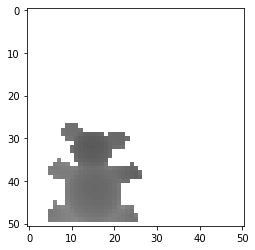

In [72]:
#Epochs
n_epochs = 400

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    k = 0

    #Training
    print("nb batch:", len(depthmap_merged_training_stack))
    print("nb batch minus last one :", len(depthmap_merged_training_stack[:-1]))
    for data in depthmap_merged_training_stack:
        print("training set n°", k )
        batch_images = data.to(device)
        #batch_images = change_grey_dynamic(batch_images, 255)
        plt.imshow(torch.squeeze(batch_images[0, 0, :, :]).cpu(), cmap='gray', vmin=0, vmax=1)
        [outputs, features] = model(batch_images, True)
        #model.zero_grad()
        optimizer.zero_grad()
        #loss = criterion(outputs, batch_images)
        #loss = loss_function(batch_images, outputs, batch_size, height, width)
        #loss = mse_corr(batch_images, outputs)
        #loss = mse_function(batch_images, outputs)
        loss = total_loss(batch_images, model, features, outputs, 0.15, 0.004, 4)
        loss.backward()
        print("conv1.weights grad: ", params[0].grad)
        #print(model.conv1.bias.grad)
        #print(model.conv1.weight.grad)
        optimizer.step()
        train_loss += loss.item()*batch_images.size(0)
        k = k+1
          
    train_loss = train_loss/len(depthmap_merged_training_stack)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

torch.Size([32, 1, 51, 51])
torch.Size([32, 2601])
torch.Size([32, 30])
torch.Size([32, 2601])
torch.Size([32, 1, 51, 51])
torch.Size([32, 30])
Original Images
Reconstructed Images


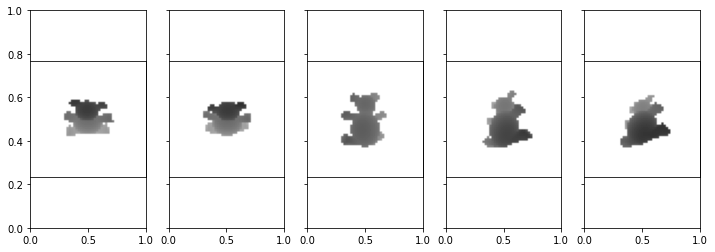

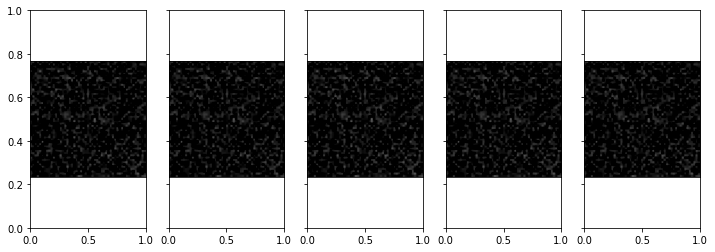

In [73]:
#Batch of test images
batch_test_images = (depthmap_test_stack[0]);

#Sample outputs
[outputs , test_features] = model(torch.FloatTensor(batch_test_images).to(device), True)
print(test_features.size())
outputs = outputs.view(batch_size, 1, height, width)
outputs = outputs.detach().cpu().data.numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(batch_test_images[idx, :, :, :]), cmap='gray', vmin=0, vmax=1)

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(outputs[idx, :,:,:]), cmap='gray', vmin=0, vmax=1)